# Import necessary libraries

In [ ]:
# %% [markdown]
# ## 导入必要模块
import sys
import os

import torch
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json

import classifier_free_guidance
import importlib
importlib.reload(classifier_free_guidance)
from classifier_free_guidance import *

# Configure the environment

In [ ]:
# nohup python -W ignore diff_training.py >> diff_training_SPIDER-thorax_v1_image_transform.log 2>&1 &
organ = "breast"
data_dir = Path(f"../data/SPIDER/SPIDER-{organ}/SPIDER-{organ}")
image_size = 128
image_transform = True  # 是否对图像进行transform

# condition parameters
num_classes       = 0 # 这里的 num_classes 是指基因的数量
gene_normalize = True  # 是否对基因表达进行Layernorm
gene_scale = 1.  # 基因表达的缩放因子, gene_scale will be multiplied to the gene expression values
cond2_input_dim = 0  # 如果不需要第二个条件输入，可以设置为0
cond2_drop = True  # 是否对第二个条件输入进行dropout
cond3_num_classes = 0  # 如果不需要第三个条件输入，可以设置为0
cond3_drop = True # 是否对第三个条件输入进行dropout
 
# training parameters
train_batch_size  = 64
train_num_steps   = 200_000
save_and_sample_every        = 2_500
ema_decay      = 0.999  # EMA衰减率，通常设置为0.999或0.9999
gradient_accumulate_every = 4  # 梯度累积步数，通常设置为1以便于调试和测试
train_lr          = 1e-4
cond_drop_prob    = 0.1
results_folder    = Path(f"./model_save/SPIDER-{organ}_v1_image_transform")  # 模型保存路径
data_folder       = None # "./Train"  # 请确保这里是 ImageFolder 结构

results_folder.mkdir(exist_ok=True, parents=True)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'    # 先隐藏其它卡，只留对应的物理卡
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# adata preprocessing

In [ ]:
import json
import scanpy as sp

organ = "breast"
data_dir = f"../data/SPIDER/SPIDER-{organ}/SPIDER-{organ}"

dataset_ids = []
if organ == "breast":
    dataset_ids += ["TENX68", "TENX53", "TENX39", "TENX24", "TENX23", "TENX14", "TENX13", "NCBI776"]
    dataset_ids += ["TENX99", "TENX98", "TENX97", "TENX96", "TENX95", "TENX94","NCBI785", "NCBI784", "NCBI783"]# Xenium
elif organ == "skin":
    dataset_ids += ["MEND40","MEND39","MEND38","MEND37"]
    dataset_ids += ["NCBI526","NCBI525","NCBI524","NCBI523","NCBI522","NCBI521","NCBI520","NCBI519","NCBI518","NCBI517","NCBI516","NCBI515","NCBI510","NCBI509","NCBI508","NCBI507","NCBI506","NCBI505","NCBI504","NCBI503","NCBI498","NCBI497","NCBI496","NCBI495","NCBI494","NCBI493","NCBI492","NCBI491","NCBI490","NCBI489","NCBI488","NCBI487","NCBI486","NCBI485","NCBI484","NCBI483","NCBI482","NCBI481","NCBI480","NCBI479","NCBI478","NCBI477","NCBI476","NCBI475","NCBI474","NCBI473","NCBI472","NCBI471","NCBI470","NCBI469","NCBI468","NCBI467","NCBI466","NCBI465","NCBI464","NCBI463","NCBI462","NCBI461","NCBI460"]
    dataset_ids += ["TENX158", "TENX123", "TENX122", "TENX117", "TENX115"]# Xenium
elif organ == "thorax": # Lung
    dataset_ids = ["MEND90","MEND89","MEND88","MEND87","MEND86","MEND85"]
    dataset_ids += ["MEND52","MEND51","MEND47","MEND45","MEND41"]
    dataset_ids += ["NCBI537","NCBI536","NCBI535","NCBI534"]
    dataset_ids += ["MISC32","MISC31","MISC30","MISC29","MISC28","MISC27","MISC26","MISC25","MISC24","MISC23","MISC22","MISC21","MISC20","MISC19","MISC18","MISC17","MISC16","MISC15","MISC14","MISC13"]
    dataset_ids += ["NCBI884","NCBI883","NCBI882","NCBI881","NCBI880","NCBI879","NCBI876","NCBI875",
                    "NCBI873","NCBI870","NCBI867","NCBI866","NCBI865","NCBI864","NCBI861","NCBI860",
                    "NCBI859","NCBI858","NCBI857","NCBI856","TENX141","TENX118"]# Xenium
elif organ == "colorectal":
    dataset_ids.extend(["MEND33", "MEND34", "MEND35", "MEND36"]) 
    dataset_ids.extend(["MEND91", "MEND92", "MEND93", "MEND95", "MEND96"]) 
    dataset_ids.extend(["ZEN36", "ZEN37", "ZEN38", "ZEN39", "ZEN40", "ZEN41", "ZEN42", "ZEN43", "ZEN44", "ZEN45", "ZEN46", "ZEN47", "ZEN48", "ZEN49"])
    dataset_ids.extend(["TENX29", "TENX49"])
    dataset_ids.extend([f"MISC{i}" for i in range(33, 74)])
    dataset_ids += ["TENX149", "TENX148", "TENX147", "TENX139", "TENX114", "TENX111"]# Xenium
else:
    raise ValueError("organ not recognized")

## Image transformation

In [ ]:
import os, glob, cv2, numpy as np, staintools
from tqdm import tqdm

# —— 1) 组织掩膜（避免背景影响统计/变换） ——
def tissue_mask_rgb(bgr, sat_thr=0.07, val_max=0.98):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    s = hsv[...,1]/255.0; v = hsv[...,2]/255.0
    return (s > sat_thr) & (v < val_max)

def pick_reference_patch(dir_ref):
    # 简单挑一张：组织覆盖高、中等亮度的 patch（你也可以手动指定）
    cands = glob.glob(os.path.join(dir_ref, "**", "*.png"), recursive=True)
    best = None; best_score = -1
    best_p = None
    for p in cands[:1000]:  # 采样前 1000 张
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        mask = tissue_mask_rgb(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        cov  = mask.mean()
        if cov > best_score:
            best_score = cov; best = img
            best_p = p
    print(f"Selected reference patch: {best_p} with coverage {best_score:.4f}")
    return best

metadata_file = os.path.join(data_dir, "metadata.json")
with open(metadata_file, "r") as f:
    all_records = json.load(f)

# ref_img = pick_reference_patch(f"{data_dir}/images/")
if organ == "colorectal":
    ref_img = cv2.cvtColor(cv2.imread(f"{data_dir}/images/patch_0466331.png"), cv2.COLOR_BGR2RGB)
elif organ == "thorax":
    ref_img = cv2.cvtColor(cv2.imread(f"{data_dir}/images/patch_0136030.png"), cv2.COLOR_BGR2RGB)
elif organ == "skin":
    ref_img = cv2.cvtColor(cv2.imread(f"{data_dir}/images/patch_0017508.png"), cv2.COLOR_BGR2RGB)
elif organ == "breast":
    ref_img = cv2.cvtColor(cv2.imread(f"{data_dir}/images/patch_0065015.png"), cv2.COLOR_BGR2RGB)
else:
    raise NotImplementedError
normalizer = staintools.StainNormalizer(method='macenko')
normalizer.fit(ref_img)
# norm_rgb = normalizer.transform(img_rgb) # img_rgb is a numpy array of shape (H, W, 3)

os.makedirs(f"{data_dir}/images_norm", exist_ok=True)
image_paths = [r["image_name"] for r in all_records]

# import cv2
# for p in tqdm(image_paths):
#     if not os.path.exists(os.path.join(data_dir, "images_norm", p)):
#         img = cv2.cvtColor(cv2.imread(os.path.join(data_dir, "images", p)), cv2.COLOR_BGR2RGB)
#         norm_rgb = normalizer.transform(img)
#         cv2.imwrite(os.path.join(data_dir, "images_norm", p), cv2.cvtColor(norm_rgb, cv2.COLOR_RGB2BGR))

# 'Selected reference patch: ../data/SPIDER/SPIDER-colorectal/SPIDER-colorectal/images/patch_0466331.png with coverage 1.0000'
# 'Selected reference patch: ../data/SPIDER/SPIDER-thorax/SPIDER-thorax/images/patch_0136030.png with coverage 1.0000'
# 'Selected reference patch: ../data/SPIDER/SPIDER-skin/SPIDER-skin/images/patch_0017508.png with coverage 1.0000'
# 'Selected reference patch: ../data/SPIDER/SPIDER-breast/SPIDER-breast/images/patch_0065015.png with coverage 1.0000'

In [ ]:
import os
import zarr
from numcodecs import Blosc
import scanpy as sc
import numpy as np
from tqdm import tqdm
from staintools.tissue_masks.luminosity_threshold_tissue_locator import LuminosityThresholdTissueLocator, TissueMaskException

# 压缩器示例：Blosc (多线程 + 高速)
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.SHUFFLE)
# #Bowel MEND33- MEND36# "MEND91-MEND96" # "ZEN36-ZEN49" # "TENX29" # "TENX49"
samples = dataset_ids
for id in samples:
    if not os.path.exists(f'../GEN/patch_image_visium/{id}.zarr/patch_image'):
        print(f"Loading dataset {id} for patch image zarr conversion")
        adata = sc.read_h5ad(f"../data/hest/adata/{id}.h5ad")
        arr = adata.obsm['patch_image']   # 假设 shape = (N, H, W, C)
        H, W, C = arr.shape[1:]           # 获取单张图像的尺寸

        # 打开一个 Group，实现分块存储
        root = zarr.open_group(f'../GEN/patch_image_visium/{id}.zarr', mode='w')
        # 创建一个 Array，指定 chunk 大小和压缩器
        z = root.create_dataset(
            name='patch_image',
            data=arr,
            chunks=(1, H, W, C),    # 每次只读/写一个样本
            compressor=compressor,
            dtype=arr.dtype,
            overwrite=True
        )
    else:
        print(f"Dataset {id} patch_image already exists.")
        
    if not os.path.exists(f'../GEN/patch_image_visium/{id}.zarr/patch_image_norm'):
        store = f"../GEN/patch_image_visium/{id}.zarr"
        src_key, dst_key = "patch_image", "patch_image_norm"

        g = zarr.open_group(store, mode="a")
        src = g[src_key]  # (B,H,W,C) uint8
        B, H, W, C = src.shape

        # 目标数组（形状、chunks、dtype 与源一致）
        if dst_key in g:
            del g[dst_key]
        dst = g.create(
            name=dst_key,
            shape=src.shape,
            chunks=src.chunks,
            dtype=src.dtype,
            compressor=src.compressor or Blosc(cname="zstd", clevel=3, shuffle=Blosc.SHUFFLE),
        )

        def has_tissue_uint8_rgb(img_uint8, lum_thresh=0.85, min_frac=0.005):
            """
            img_uint8: (H,W,3) uint8 RGB
            返回：是否包含足够组织
            """
            mask = LuminosityThresholdTissueLocator.get_tissue_mask(img_uint8, luminosity_threshold=lum_thresh)
            return (mask.mean() >= min_frac)

        skipped, ok = 0, 0
        for i in tqdm(range(B), desc=f"{id} normalizing"):
            img = src[i]  # (H,W,C) uint8
            # 1) 先快速判断是否有组织
            if img.ndim != 3 or img.shape[2] != 3 or img.dtype != np.uint8:
                # 若格式异常，直接跳过归一化
                dst[i] = img
                skipped += 1
                print(f"Skipping patch {i} due to unexpected shape or dtype: {img.shape}, {img.dtype}")
                continue

            try:
                if has_tissue_uint8_rgb(img, lum_thresh=0.85, min_frac=0.005):
                    img_norm = normalizer.transform(img)  # Macenko 归一化
                    if img_norm.dtype != src.dtype:
                        img_norm = img_norm.astype(src.dtype, copy=False)
                    dst[i] = img_norm
                    ok += 1
                else:
                    # 背景块：不归一化，直接拷贝
                    dst[i] = img
                    skipped += 1
                    print(f"Skipping patch {i} due to insufficient tissue coverage.")
            except:
                # 保险兜底：个别 patch 算 mask 出异常时也跳过
                dst[i] = img
                skipped += 1
                print(f"Skipping patch {i} due to an unexpected error.")

        # 元信息（可选）
        dst.attrs["stain_norm"] = "Macenko"
        dst.attrs["source"] = src_key
        dst.attrs["skip_no_tissue"] = True
        print(f"{id} Done. wrote to {store}/{dst_key} | normalized={ok}, skipped(no tissue)={skipped}")
    else:
        print(f"Dataset {id} patch_image_norm already exists.")

# z = zarr.open(f"../GEN/patch_image_visium/{i}.zarr/patch_image", mode='r')
# z[:10]

In [ ]:
raise 'STOP'

In [ ]:
import zarr, numpy as np
from numcodecs import Blosc
from tqdm import tqdm
from staintools.tissue_masks.luminosity_threshold_tissue_locator import LuminosityThresholdTissueLocator, TissueMaskException
# # #Bowel MEND33- MEND36# "MEND91-MEND96" # "ZEN36-ZEN49" # "TENX29" # "TENX49"
for id in dataset_ids:
    store = f"../GEN/patch_image_visium/{id}.zarr"
    src_key, dst_key = "patch_image", "patch_image_norm"

    g = zarr.open_group(store, mode="a")
    src = g[src_key]  # (B,H,W,C) uint8
    B, H, W, C = src.shape

    # 目标数组（形状、chunks、dtype 与源一致）
    if dst_key in g:
        del g[dst_key]
    dst = g.create(
        name=dst_key,
        shape=src.shape,
        chunks=src.chunks,
        dtype=src.dtype,
        compressor=src.compressor or Blosc(cname="zstd", clevel=3, shuffle=Blosc.SHUFFLE),
    )

    def has_tissue_uint8_rgb(img_uint8, lum_thresh=0.85, min_frac=0.005):
        """
        img_uint8: (H,W,3) uint8 RGB
        返回：是否包含足够组织
        """
        mask = LuminosityThresholdTissueLocator.get_tissue_mask(img_uint8, luminosity_threshold=lum_thresh)
        return (mask.mean() >= min_frac)

    skipped, ok = 0, 0
    for i in tqdm(range(B), desc=f"{id} normalizing"):
        img = src[i]  # (H,W,C) uint8
        # 1) 先快速判断是否有组织
        if img.ndim != 3 or img.shape[2] != 3 or img.dtype != np.uint8:
            # 若格式异常，直接跳过归一化
            dst[i] = img
            skipped += 1
            print(f"Skipping patch {i} due to unexpected shape or dtype: {img.shape}, {img.dtype}")
            continue

        try:
            if has_tissue_uint8_rgb(img, lum_thresh=0.85, min_frac=0.005):
                img_norm = normalizer.transform(img)  # Macenko 归一化
                if img_norm.dtype != src.dtype:
                    img_norm = img_norm.astype(src.dtype, copy=False)
                dst[i] = img_norm
                ok += 1
            else:
                # 背景块：不归一化，直接拷贝
                dst[i] = img
                skipped += 1
                print(f"Skipping patch {i} due to insufficient tissue coverage.")
        except TissueMaskException:
            # 保险兜底：个别 patch 算 mask 出异常时也跳过
            dst[i] = img
            skipped += 1
            print(f"Skipping patch {i} due to TissueMaskException.")

    # 元信息（可选）
    dst.attrs["stain_norm"] = "Macenko"
    dst.attrs["source"] = src_key
    dst.attrs["skip_no_tissue"] = True
    print(f"{id} Done. wrote to {store}/{dst_key} | normalized={ok}, skipped(no tissue)={skipped}")

In [ ]:
# import zarr, numpy as np
# from numcodecs import Blosc
# from tqdm import tqdm
# from staintools.tissue_masks.luminosity_threshold_tissue_locator import LuminosityThresholdTissueLocator, TissueMaskException
# # # #Bowel MEND33- MEND36# "MEND91-MEND96" # "ZEN36-ZEN49" # "TENX29" # "TENX49"
# for id in ['TENX49']:# [f"MEND{i}" for i in range(95, 97)]:# bowel_ids:
#     store = f"/home/imy6771/ST/GEN/patch_image_visium/{id}.zarr"
#     src_key, dst_key = "patch_image", "patch_image_norm"

#     g = zarr.open_group(store, mode="a")
#     src = g[src_key]  # (B,H,W,C) uint8
#     B, H, W, C = src.shape

#     # 目标数组（形状、chunks、dtype 与源一致）
#     if dst_key in g:
#         del g[dst_key]
#     dst = g.create(
#         name=dst_key,
#         shape=src.shape,
#         chunks=src.chunks,
#         dtype=src.dtype,
#         compressor=src.compressor or Blosc(cname="zstd", clevel=3, shuffle=Blosc.SHUFFLE),
#     )

#     def has_tissue_uint8_rgb(img_uint8, lum_thresh=0.85, min_frac=0.005):
#         """
#         img_uint8: (H,W,3) uint8 RGB
#         返回：是否包含足够组织
#         """
#         mask = LuminosityThresholdTissueLocator.get_tissue_mask(img_uint8, luminosity_threshold=lum_thresh)
#         return (mask.mean() >= min_frac)

#     skipped, ok = 0, 0
#     for i in tqdm(range(B), desc=f"{id} normalizing"):
#         img = src[i]  # (H,W,C) uint8
#         # 1) 先快速判断是否有组织
#         if img.ndim != 3 or img.shape[2] != 3 or img.dtype != np.uint8:
#             # 若格式异常，直接跳过归一化
#             dst[i] = img
#             skipped += 1
#             print(f"Skipping patch {i} due to unexpected shape or dtype: {img.shape}, {img.dtype}")
#             continue

#         try:
#             if has_tissue_uint8_rgb(img, lum_thresh=0.85, min_frac=0.005):
#                 img_norm = normalizer.transform(img)  # Macenko 归一化
#                 if img_norm.dtype != src.dtype:
#                     img_norm = img_norm.astype(src.dtype, copy=False)
#                 dst[i] = img_norm
#                 ok += 1
#             else:
#                 # 背景块：不归一化，直接拷贝
#                 dst[i] = img
#                 skipped += 1
#                 print(f"Skipping patch {i} due to insufficient tissue coverage.")
#         except TissueMaskException:
#             # 保险兜底：个别 patch 算 mask 出异常时也跳过
#             dst[i] = img
#             skipped += 1
#             print(f"Skipping patch {i} due to TissueMaskException.")

#     # 元信息（可选）
#     dst.attrs["stain_norm"] = "Macenko"
#     dst.attrs["source"] = src_key
#     dst.attrs["skip_no_tissue"] = True
#     print(f"{id} Done. wrote to {store}/{dst_key} | normalized={ok}, skipped(no tissue)={skipped}")

# MISC33 normalizing: 100%|██████████| 3385/3385 [10:28<00:00,  5.38it/s]
# MISC33 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC33.zarr/patch_image_norm | normalized=3385, skipped(no tissue)=0
# MISC34 normalizing: 100%|██████████| 3705/3705 [11:04<00:00,  5.57it/s]
# MISC34 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC34.zarr/patch_image_norm | normalized=3705, skipped(no tissue)=0
# MISC35 normalizing: 100%|██████████| 3525/3525 [09:58<00:00,  5.89it/s]
# MISC35 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC35.zarr/patch_image_norm | normalized=3525, skipped(no tissue)=0
# MISC36 normalizing: 100%|██████████| 3476/3476 [10:03<00:00,  5.76it/s]
# MISC36 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC36.zarr/patch_image_norm | normalized=3476, skipped(no tissue)=0
# MISC37 normalizing: 100%|██████████| 3551/3551 [10:17<00:00,  5.75it/s]
# MISC37 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC37.zarr/patch_image_norm | normalized=3551, skipped(no tissue)=0
# MISC38 normalizing: 100%|██████████| 1709/1709 [05:23<00:00,  5.29it/s]
# MISC38 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC38.zarr/patch_image_norm | normalized=1709, skipped(no tissue)=0
# MISC39 normalizing: 100%|██████████| 4064/4064 [12:18<00:00,  5.50it/s]
# MISC39 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC39.zarr/patch_image_norm | normalized=4064, skipped(no tissue)=0
# MISC40 normalizing: 100%|██████████| 4102/4102 [12:17<00:00,  5.56it/s]
# MISC40 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC40.zarr/patch_image_norm | normalized=4102, skipped(no tissue)=0
# MISC41 normalizing:  45%|████▍     | 1628/3638 [05:01<04:48,  6.98it/s]
# Skipping patch 1626 due to insufficient tissue coverage.
# MISC41 normalizing: 100%|██████████| 3638/3638 [11:14<00:00,  5.40it/s]
# MISC41 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC41.zarr/patch_image_norm | normalized=3637, skipped(no tissue)=1
# MISC42 normalizing: 100%|██████████| 643/643 [02:02<00:00,  5.23it/s]
# MISC42 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC42.zarr/patch_image_norm | normalized=643, skipped(no tissue)=0
# MISC43 normalizing: 100%|██████████| 1181/1181 [03:43<00:00,  5.28it/s]
# MISC43 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC43.zarr/patch_image_norm | normalized=1181, skipped(no tissue)=0
# MISC44 normalizing: 100%|██████████| 897/897 [02:45<00:00,  5.41it/s]
# MISC44 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC44.zarr/patch_image_norm | normalized=897, skipped(no tissue)=0
# MISC45 normalizing: 100%|██████████| 4108/4108 [13:15<00:00,  5.16it/s]
# MISC45 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC45.zarr/patch_image_norm | normalized=4108, skipped(no tissue)=0
# MISC46 normalizing: 100%|██████████| 4508/4508 [14:56<00:00,  5.03it/s]
# MISC46 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC46.zarr/patch_image_norm | normalized=4508, skipped(no tissue)=0
# MISC47 normalizing: 100%|██████████| 4804/4804 [15:43<00:00,  5.09it/s]
# MISC47 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC47.zarr/patch_image_norm | normalized=4804, skipped(no tissue)=0
# MISC48 normalizing: 100%|██████████| 3567/3567 [11:45<00:00,  5.06it/s]
# MISC48 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC48.zarr/patch_image_norm | normalized=3567, skipped(no tissue)=0
# MISC49 normalizing: 100%|██████████| 4579/4579 [15:09<00:00,  5.03it/s]
# MISC49 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC49.zarr/patch_image_norm | normalized=4579, skipped(no tissue)=0
# MISC50 normalizing:  56%|█████▌    | 2366/4244 [07:43<06:13,  5.03it/s]
# Skipping patch 2366 due to insufficient tissue coverage.
# MISC50 normalizing: 100%|██████████| 4244/4244 [13:52<00:00,  5.10it/s]
# MISC50 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC50.zarr/patch_image_norm | normalized=4243, skipped(no tissue)=1
# MISC51 normalizing: 100%|██████████| 3049/3049 [09:53<00:00,  5.14it/s]
# MISC51 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC51.zarr/patch_image_norm | normalized=3049, skipped(no tissue)=0
# MISC52 normalizing: 100%|██████████| 215/215 [00:39<00:00,  5.45it/s]
# MISC52 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC52.zarr/patch_image_norm | normalized=215, skipped(no tissue)=0
# MISC53 normalizing: 100%|██████████| 816/816 [02:36<00:00,  5.20it/s]
# MISC53 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC53.zarr/patch_image_norm | normalized=816, skipped(no tissue)=0
# MISC54 normalizing: 100%|██████████| 667/667 [02:08<00:00,  5.20it/s]
# MISC54 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC54.zarr/patch_image_norm | normalized=667, skipped(no tissue)=0
# MISC55 normalizing: 100%|██████████| 822/822 [02:35<00:00,  5.30it/s]
# MISC55 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC55.zarr/patch_image_norm | normalized=822, skipped(no tissue)=0
# MISC56 normalizing:  24%|██▍       | 806/3386 [02:36<06:35,  6.52it/s]
# Skipping patch 804 due to insufficient tissue coverage.
# MISC56 normalizing: 100%|██████████| 3386/3386 [10:57<00:00,  5.15it/s]
# MISC56 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC56.zarr/patch_image_norm | normalized=3385, skipped(no tissue)=1
# MISC57 normalizing: 100%|██████████| 975/975 [03:04<00:00,  5.30it/s]
# MISC57 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC57.zarr/patch_image_norm | normalized=975, skipped(no tissue)=0
# MISC58 normalizing: 100%|██████████| 1154/1154 [03:34<00:00,  5.38it/s]
# MISC58 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC58.zarr/patch_image_norm | normalized=1154, skipped(no tissue)=0
# MISC59 normalizing: 100%|██████████| 1287/1287 [04:00<00:00,  5.35it/s]
# MISC59 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC59.zarr/patch_image_norm | normalized=1287, skipped(no tissue)=0
# MISC60 normalizing: 100%|██████████| 993/993 [03:05<00:00,  5.35it/s]
# MISC60 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC60.zarr/patch_image_norm | normalized=993, skipped(no tissue)=0
# MISC61 normalizing: 100%|██████████| 1995/1995 [06:12<00:00,  5.35it/s]
# MISC61 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC61.zarr/patch_image_norm | normalized=1995, skipped(no tissue)=0
# MISC62 normalizing: 100%|██████████| 4129/4129 [13:29<00:00,  5.10it/s]
# MISC62 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC62.zarr/patch_image_norm | normalized=4129, skipped(no tissue)=0
# MISC63 normalizing: 100%|██████████| 3463/3463 [11:16<00:00,  5.12it/s]
# MISC63 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC63.zarr/patch_image_norm | normalized=3463, skipped(no tissue)=0
# MISC64 normalizing: 100%|██████████| 2531/2531 [08:17<00:00,  5.09it/s]
# MISC64 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC64.zarr/patch_image_norm | normalized=2531, skipped(no tissue)=0
# MISC65 normalizing: 100%|██████████| 3261/3261 [10:37<00:00,  5.11it/s]
# MISC65 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC65.zarr/patch_image_norm | normalized=3261, skipped(no tissue)=0
# MISC66 normalizing: 100%|██████████| 3946/3946 [12:04<00:00,  5.44it/s]
# MISC66 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC66.zarr/patch_image_norm | normalized=3946, skipped(no tissue)=0
# MISC67 normalizing: 100%|██████████| 2523/2523 [08:04<00:00,  5.21it/s]
# MISC67 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC67.zarr/patch_image_norm | normalized=2523, skipped(no tissue)=0
# MISC68 normalizing: 100%|██████████| 2708/2708 [08:49<00:00,  5.12it/s]
# MISC68 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC68.zarr/patch_image_norm | normalized=2708, skipped(no tissue)=0
# MISC69 normalizing: 100%|██████████| 3615/3615 [11:43<00:00,  5.14it/s]
# MISC69 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC69.zarr/patch_image_norm | normalized=3615, skipped(no tissue)=0
# MISC70 normalizing: 100%|██████████| 3901/3901 [12:22<00:00,  5.25it/s]
# MISC70 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC70.zarr/patch_image_norm | normalized=3901, skipped(no tissue)=0
# MISC71 normalizing: 100%|██████████| 2984/2984 [09:40<00:00,  5.14it/s]
# MISC71 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC71.zarr/patch_image_norm | normalized=2984, skipped(no tissue)=0
# MISC72 normalizing: 100%|██████████| 4368/4368 [14:15<00:00,  5.11it/s]
# MISC72 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC72.zarr/patch_image_norm | normalized=4368, skipped(no tissue)=0
# MISC73 normalizing: 100%|██████████| 3885/3885 [12:37<00:00,  5.13it/s]
# MISC73 Done. wrote to /home/imy6771/ST/GEN/patch_image_visium/MISC73.zarr/patch_image_norm | normalized=3885, skipped(no tissue)=0

# Dataset

In [ ]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset


class SPIDERDataset(Dataset):
    """
    A PyTorch Dataset that loads stitched images on the fly from flat patch data.

    Assumes the following structure inside data_dir:
      - metadata.json
      - images/         (flat folder containing all patch images)

    The metadata.json file is expected to contain a list of records like:
      {
        "slide_id": "slide_identifier",
        "image_name": "central_patch_filename.png",
        "context_info": {
            "0_0": "patch_filename.png",
            "0_1": "patch_filename.png",
            ...
        },
        "class": "ClassName",
        "split": "train"  // or "test", etc.
      }

    For context sizes > 1, the dataset stitches patches together into one image (of size
    context_size * patch_size by context_size * patch_size). For context size 1, it simply loads
    the central patch.

    The dataset also builds a mapping from class names to numeric labels (and vice versa) which
    can be retrieved via get_class_to_label() and get_label_to_class().

    Args:
        data_dir (str): Directory containing metadata.json and an images folder.
        context_size (int): Context size to use: valid options are 1, 3, or 5.
        split (str): Which split to load ("train", "test", etc.). Only records with matching split are used.
        transform: Optional transform to apply to the stitched PIL image (e.g., a torchvision transform).
    """

    def __init__(self, data_dir, context_size=5, split="train", transform=None,image_transform=False):
        self.data_dir = data_dir
        self.context_size = context_size
        self.split = split
        self.transform = transform

        # Fixed parameter: each patch is 224 pixels.
        self.patch_size = 224

        # The original flattened grid is assumed to be 5x5.
        self.full_grid_size = 5
        self.center_index = self.full_grid_size // 2  # For a 5x5 grid, this is 2.

        # Load metadata.
        metadata_file = os.path.join(data_dir, "metadata.json")
        with open(metadata_file, "r") as f:
            all_records = json.load(f)

        # Filter records by the split.
        self.records = [
            rec for rec in all_records if rec.get("split", "train") == self.split
        ]

        # Build class mappings.
        classes = sorted(set(rec["class"] for rec in self.records))
        self.class_to_label = {cls: idx for idx, cls in enumerate(classes)}
        self.label_to_class = {idx: cls for cls, idx in self.class_to_label.items()}

        # Define images directory.
        if image_transform:
            self.images_dir = os.path.join(data_dir, "images_norm")
        else:
            self.images_dir = os.path.join(data_dir, "images")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, index):
        record = self.records[index]

        # Compute bounds for the desired context.
        lower_bound = (self.full_grid_size - self.context_size) // 2
        upper_bound = lower_bound + self.context_size - 1

        # Create a new blank image for the stitched result.
        stitched_width = self.context_size * self.patch_size
        stitched_height = self.context_size * self.patch_size
        stitched_image = Image.new("RGB", (stitched_width, stitched_height))

        # For context_size of 1, we simply use the center patch (without stitching)
        if self.context_size == 1:
            stitched_image = Image.open(
                os.path.join(self.images_dir, record["image_name"])
            ).convert("RGB")
        else:
            # Loop over grid coordinates to load and paste patches.
            for i in range(lower_bound, upper_bound + 1):
                for j in range(lower_bound, upper_bound + 1):
                    # For the center patch, use record["image_name"]; otherwise, use context_info.
                    if i == self.center_index and j == self.center_index:
                        patch_filename = record["image_name"]
                    else:
                        key = f"{i}_{j}"
                        if key not in record["context_info"]:
                            # If a patch is missing, use a blank image.
                            patch = Image.new("RGB", (self.patch_size, self.patch_size))
                            paste_x = (j - lower_bound) * self.patch_size
                            paste_y = (i - lower_bound) * self.patch_size
                            stitched_image.paste(patch, (paste_x, paste_y))
                            continue
                        patch_filename = record["context_info"][key]

                    patch_path = os.path.join(self.images_dir, patch_filename)
                    try:
                        patch = Image.open(patch_path).convert("RGB")
                    except Exception as e:
                        print(f"Error loading patch {patch_path}: {e}")
                        patch = Image.new("RGB", (self.patch_size, self.patch_size))

                    paste_x = (j - lower_bound) * self.patch_size
                    paste_y = (i - lower_bound) * self.patch_size
                    stitched_image.paste(patch, (paste_x, paste_y))

        # Apply optional transform.
        if self.transform is not None:
            stitched_image = self.transform(stitched_image)

        # Get the numeric label.
        label = self.class_to_label[record["class"]]

        p_i = stitched_image
        g_e = torch.tensor(0.)
        p_e = torch.tensor(0.)
        o_t = torch.tensor(label)
        mean = torch.tensor([0.5, 0.5, 0.5])
        std = torch.tensor([0.5, 0.5, 0.5])
        return p_i, g_e, p_e, o_t, mean, std

    def get_class_to_label(self):
        return self.class_to_label

    def get_label_to_class(self):
        return self.label_to_class

In [ ]:
import torchvision
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.RandomResizedCrop(image_size, scale=(0.6, 1.0)),
])
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(image_size), 
])

train_dataset = SPIDERDataset(
    data_dir=data_dir,
    context_size=1,
    split="train",
    transform=train_transforms,
    image_transform=image_transform
)
test_dataset = SPIDERDataset(
    data_dir=data_dir,
    context_size=1,
    split="test",
    transform=test_transforms,
    image_transform=image_transform
)

# Training

In [ ]:
model = Unet(
    dim            = 64,
    num_classes    = num_classes,
    cond_drop_prob = cond_drop_prob,
    dim_mults      = (1, 2, 4, 8),
    init_dim = None,
    out_dim = None,
    channels = 3,
    resnet_block_groups = 8,
    learned_variance = False,
    learned_sinusoidal_cond = False,
    random_fourier_features = False,
    learned_sinusoidal_dim = 16,
    cond2_input_dim= cond2_input_dim,  # 如果不需要第二个条件输入，可以设置为0
    cond2_drop= cond2_drop,  # 是否对第二个条件输入进行dropout
    gene_normalize= gene_normalize,  # 是否对基因表达进行L2归一化
    gene_scale= gene_scale,  # 基因表达的缩放因子
    cond3_num_classes = cond3_num_classes,  # 如果不需要第三个条件输入，可以设置为0
    cond3_drop= cond3_drop,  # 是否对第三个条件输入进行dropout
).to(device)

diffusion = GaussianDiffusion(
    model              = model,
    image_size         = image_size,
    timesteps          = 1000,
    sampling_timesteps = 250,
    loss_type          = 'l2',
    objective = 'pred_noise',
    beta_schedule = 'cosine',
    ddim_sampling_eta = 1.,
    min_snr_loss_weight = True,
    min_snr_gamma = 5
).to(device)

In [ ]:
trainer = Trainer(
    diffusion_model       = diffusion,
    folder                = None, # when using CoTrainingDataset, folder is not needed
    train_dataset         = train_dataset,
    test_dataset          = test_dataset,
    num_classes           = num_classes,
    train_batch_size      = train_batch_size,
    gradient_accumulate_every = gradient_accumulate_every,
    train_lr              = train_lr,
    train_num_steps       = train_num_steps,
    ema_update_every = 10,
    ema_decay = ema_decay,
    adam_betas = (0.9, 0.999),
    save_and_sample_every = save_and_sample_every,
    results_folder        = str(results_folder),
    amp                   = False,  # Use automatic mixed precision
    fp16                  = False,  # Use 16-bit floating point precision
    split_batches = True,
    cond_scale            = 3.0,
    scheduler = True,  # Use the scheduler defined in the Trainer class
    warmup_steps = 0.05,  # Warmup steps as a fraction of total training steps or int as int(train_num_steps * 0.1
)

In [ ]:
import os
if len(os.listdir(results_folder))>0:
    if not results_folder.name == "test":    
        max_tail = max(int(f.split('-')[1].split('.')[0]) 
                    for f in os.listdir(results_folder) 
                    if '-' in f and f.split('-')[1].split('.')[0].isdigit())
        trainer.load(max_tail)
        print(f"Latest checkpoint loaded: {max_tail}")  # Print the latest checkpoint number loaded
        print(f"Resuming training from step {max_tail} ..., save every {save_and_sample_every} steps.")
    else:
        print("Test mode, no previous checkpoints loaded.")
else:
    print("No previous checkpoints found, starting from scratch.")
# trainer.train()

In [ ]:
trainer.train()

# Type-fine tuning

In [ ]:
ckp_path = Path("./model_save/SPIDER-colorectal_v1_image_transform/model-80.pt")
image_size = 128
n_genes = 0
return_gene_emb = False
gene_emb_dim = 0
fine_tune_annotation = True  # 是否进行病理注释的微调
num_type = 13

# condition parameters
num_classes       = 0 # 这里的 num_classes 是指基因的数量
gene_normalize = True  # 是否对基因表达进行Layernorm
gene_scale = 1.  # 基因表达的缩放因子, gene_scale will be multiplied to the gene expression values
cond2_input_dim = 0  # 如果不需要第二个条件输入，可以设置为0
cond2_drop = True  # 是否对第二个条件输入进行dropout
cond3_num_classes = 0  # 如果不需要第三个条件输入，可以设置为0
cond3_drop = False # 是否对第三个条件输入进行dropout
 
# training parameters
train_batch_size  = 64
train_num_steps   = 10_000 # 80_000
save_and_sample_every        = 2_500
ema_decay      = 0.999  # EMA衰减率，通常设置为0.999或0.9999
gradient_accumulate_every = 4  # 梯度累积步数，通常设置为1以便于调试和测试
train_lr          = 1e-3
weight_decay = 1e-4
cond_drop_prob    = 0.1
image_transform = True
results_folder    = Path("./model_save/SPIDER-colorectal_v1_image_transform_fine_tune_image_transform_type")  # 模型保存路径
data_folder       = None # "./Train"  # 请确保这里是 ImageFolder 结构
cond_scale = 3.
ema_update_every = 10
warmup_steps = 0.03

results_folder.mkdir(exist_ok=True, parents=True)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'    # 先隐藏其它卡，只留对应的物理卡
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"train_lr: {train_lr}, weight_decay: {weight_decay}, cond_drop_prob: {cond_drop_prob}, image_transform: {image_transform}, "
      f"cond_scale: {cond_scale}, ema_decay: {ema_decay}, warmup_steps: {warmup_steps}, save_and_sample_every: {save_and_sample_every}, "
      f"results_folder: {results_folder}, return_gene_emb: {return_gene_emb}, gene_emb_dim: {gene_emb_dim}, "
      f"Fine tuning model: {ckp_path}")

In [ ]:
idx = np.arange(len(test_dataset))
selected_spots_idx = idx[idx % 4 == 0]   # 保留能整除4的
unselected_spots_idx = idx[idx % 4 != 0]   # 去掉能整除4的
train_dataset = torch.utils.data.Subset(test_dataset, selected_spots_idx)
train_dataset.selected_spots_idx = selected_spots_idx
train_dataset.length = len(idx)

test_dataset = torch.utils.data.Subset(test_dataset, unselected_spots_idx)
test_dataset.selected_spots_idx = unselected_spots_idx
test_dataset.length = len(idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
)
dl = cycle(train_loader)  # Use cycle to create an infinite iterator for training

test_loader = DataLoader(
    test_dataset,
    batch_size=train_batch_size,
    shuffle=False,
    num_workers=4,
)
test_dl = cycle(test_loader)  # Use cycle to create an infinite iterator for testing

In [ ]:
# load the checkpoint
diffusion = trainer.ema.ema_model.to(device)
for p in diffusion.parameters():
    p.requires_grad = False
diffusion.model._add_annotation_as_cond(num_type)
ema = EMA(diffusion, beta=ema_decay, update_every=ema_update_every).to(device)

In [ ]:
import torch
import torch.nn as nn

# 兼容不同 PyTorch 版本的 RMSNorm
RMSNorm = getattr(nn, "RMSNorm", tuple())

NORM_TYPES = (
    nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.SyncBatchNorm,
    nn.GroupNorm, nn.LayerNorm, nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d,
    RMSNorm if isinstance(RMSNorm, type) else ()  # 可能不存在
)
EMB_TYPES = (nn.Embedding, nn.EmbeddingBag)

def split_decay_no_decay(module: nn.Module):
    """按类型/形状拆分当前 module 及其子模块的参数到 decay / no_decay。
       - Norm 层参数：no_decay
       - Embedding 权重：no_decay（实践中 Embedding 也不做 wd）
       - 所有 bias：no_decay
       - 形状为 1D 的参数：no_decay（例如缩放/偏置向量）
       - 其余（Conv/Linear 等的权重矩阵）：decay
    """
    decay, no_decay = [], []
    seen = set()  # 避免共享参数重复加入

    for sub in module.modules():
        is_norm = isinstance(sub, NORM_TYPES)
        is_emb  = isinstance(sub, EMB_TYPES)
        for name, p in sub.named_parameters(recurse=False):
            if (not p.requires_grad) or (id(p) in seen):
                continue
            seen.add(id(p))

            if is_norm or is_emb:
                no_decay.append(p)
            elif name.endswith("bias"):
                no_decay.append(p)
            elif p.ndim == 1:
                no_decay.append(p)
            else:
                decay.append(p)
    return decay, no_decay

def extend_groups_for(mod: nn.Module, lr: float, wd: float, groups: list):
    decay, no_decay = split_decay_no_decay(mod)
    if decay:
        groups.append({"params": decay, "lr": lr, "weight_decay": wd})
    if no_decay:
        groups.append({"params": no_decay, "lr": lr, "weight_decay": 0.0})

In [ ]:
# ==== 组装你的 param_groups（顺序/层次跟 Sequential 无关）====
param_groups = []
extend_groups_for(diffusion.model.annot_emb,    lr=train_lr,     wd=0.0, groups=param_groups)
for annot_mlp in diffusion.model.annot_mlps:
    extend_groups_for(annot_mlp,        lr=train_lr,     wd=weight_decay, groups=param_groups)
param_groups.append({"params": [diffusion.model.null_annot_emb], "lr": train_lr*0.3, "weight_decay": 0.0})

optimizer = torch.optim.AdamW(
    param_groups, lr=0.0, betas=(0.9, 0.999), eps=1e-8, weight_decay=weight_decay
)

# 可选：自检
all_params = sum((list(g["params"]) for g in param_groups), [])
assert len(set(map(id, all_params))) == len(all_params), "某些参数被重复加入了 param_groups"
for i,g in enumerate(param_groups):
    print(i, "lr=", g["lr"], "wd=", g["weight_decay"], "n_params=", sum(p.numel() for p in g["params"]))
    
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

warmup_steps = int(train_num_steps * warmup_steps) if isinstance(warmup_steps, float) else warmup_steps
warmup_scheduler = LinearLR(optimizer, start_factor=1e-8, end_factor=1.0, total_iters=warmup_steps)  # 1000 步 warmup
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=train_num_steps - warmup_steps, eta_min=1e-5)        # 同一 eta_min 比例衰减
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_steps])

In [ ]:
cur_step = 0

import os
if len(os.listdir(results_folder))>0:
    if not results_folder.name == "test":    
        max_tail = max(int(f.split('-')[1].split('.')[0]) 
                    for f in os.listdir(results_folder) 
                    if '-' in f and f.split('-')[1].split('.')[0].isdigit())
        ckp_path = results_folder / f'model-{max_tail}.pt'
        ckp = torch.load(ckp_path, map_location="cpu", weights_only=False)
        diffusion.load_state_dict(ckp['model'])
        optimizer.load_state_dict(ckp['optimizer'])
        scheduler.load_state_dict(ckp['scheduler'])
        ema.load_state_dict(ckp['ema'])
        cur_step = ckp['step']
        print(f"Latest checkpoint loaded: {max_tail}")  # Print the latest checkpoint number loaded
        print(f"Resuming training from step {max_tail} ..., save every {save_and_sample_every} steps.")
    else:
        print("Test mode, no previous checkpoints loaded.")
else:
    print("No previous checkpoints found, starting from scratch.")
    
    
for p_i_t, g_e_t, p_e_t, o_t_t, mean_t, std_t in test_dl:
    p_i_t = p_i_t.to(device)
    g_e_t = g_e_t.to(device)
    p_e_t = p_e_t.to(device)
    o_t_t = o_t_t.to(device)
    mean_t = mean_t.to(device)
    std_t = std_t.to(device)
    break

In [ ]:
with tqdm(initial = cur_step, total = train_num_steps) as pbar:
    while cur_step < train_num_steps:
        total_loss = 0.
        diffusion.train()
        for _ in range(gradient_accumulate_every):
            row_data = next(dl)
            p_i, g_e, p_e, o_t, mean, std = row_data
            p_i = p_i.to(device)
            g_e = g_e.to(device)
            p_e = p_e.to(device)
            o_t = o_t.to(device)
            mean = mean.to(device)
            std = std.to(device)

            loss = diffusion(p_i, classes=g_e,cond2 = p_e,cond3 = o_t, mean=mean, std=std)
            loss = loss / gradient_accumulate_every
            total_loss += loss.item()

            loss.backward()

        torch.nn.utils.clip_grad_norm_(diffusion.model.parameters(), 1.0)
        optimizer.step()
        ema.update()
        
        cur_step += 1
        
        if cur_step % save_and_sample_every == 0:
            diffusion.eval()
            with torch.no_grad():
                milestone = cur_step // save_and_sample_every
                #batches = num_to_groups(self.num_samples, self.batch_size)
                #rand_classes_to_sample = torch.randint(0, self.num_classes, (self.num_classes,)).to(device) # classes is like: tensor([1, 1, 5, 3, 4])
                all_images_list = list(ema.ema_model.sample(
                    classes = g_e_t,
                    cond_scale = cond_scale,
                    clip_denoised = True, #clip_denoised,
                    clip_max = 1.,#((1. - mean_t)/ std_t).max().item(),
                    clip_min = -1.,#((0. - mean_t)/ std_t).min().item(),
                    cond2 = p_e_t,
                    cond3 = o_t_t,
                    mean = mean_t,
                    std = std_t
                ))
                all_images_list = all_images_list+list(p_i_t)
            utils.save_image(all_images_list, str(results_folder / f'sample-{milestone}.png'), normalize=True, value_range=(0,1))  
            torch.save({
                'step': cur_step,
                'model': diffusion.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'ema': ema.state_dict(),
                }, str(results_folder / f'model-{milestone}.pt'))
        
        pbar.set_description(f'loss: {total_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.10f}, {optimizer.param_groups[-1]["lr"]:.10f}')
        pbar.update(1)
        scheduler.step() # update learning rate
        optimizer.zero_grad(set_to_none=True)

In [ ]:
del optimizer, scheduler, train_loader, dl, train_dataset, test_loader, test_dl

img_save_dir = f"./image_save/image_transform_fine_tune_type/"

os.makedirs(img_save_dir, exist_ok=True)
batch_size = 512
print(f"batch size {batch_size}, saving images to {img_save_dir} ...")

gen_dataset = train_dataset
gen_loader = DataLoader(
    gen_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
)

import os, zarr
H, W, C = image_size, image_size, 3
store = zarr.DirectoryStore(os.path.join(img_save_dir, "samples.zarr"))
root = zarr.group(store=store, overwrite=True)

ds = root.create_dataset(
    name="images",
    shape=(gen_dataset.length, 0, H, W, C),         # 初始 0 次
    chunks=(1, 1, H, W, C),
    dtype="uint8",
    compressor=zarr.Blosc()
)

# 在同一个 root 下创建 gene_expression
ds2 = root.create_dataset(
    name="type",
    shape=(gen_dataset.length, 0, 1),            # (样本数, 基因表达维度)
    chunks=(1, 1, 1),           # 按“1 个样本 x G 维”切片
    dtype="float32",         # 根据你的数据类型改成 float32/float64
    compressor=zarr.Blosc()  # 可选压缩
)

ema.ema_model.eval()
ema.online_model.eval()
sample_times_max = 10

for sample_times in range(sample_times_max):
    with torch.no_grad():
        for idx,(p_i, g_e,p_e,o_t,mean,std) in enumerate(gen_loader):
            print(f"Sampling {sample_times + 1}/{sample_times_max} times, batch {idx + 1}/{len(gen_loader)} ...")
            # p_i = p_i.to(device)
            g_e = g_e.to(device)
            p_e = p_e.to(device)
            o_t = o_t.to(device)
            mean = mean.to(device)
            std = std.to(device)
            samples = ema.ema_model.sample(classes=g_e, cond_scale=cond_scale, clip_denoised=True,
                                                clip_max = 1.,
                                                clip_min = -1.,
                                                cond2=p_e, cond3=o_t, mean=mean, std=std)

            np_imgs = (samples * 255).detach().cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)
            # for idx_, img_ in enumerate(list(np_imgs)):
            #     os.makedirs(f"{img_save_dir}/{batch_size * idx + idx_}", exist_ok=True)
            #     img_save_path = f"{img_save_dir}/{batch_size * idx + idx_}/{sample_times}.png"
            #     plt.imsave(img_save_path, img_)
            # 扩张 dataset，再写入新数据
            ds.resize((gen_dataset.length, sample_times + 1, H, W, C))
            rows = np.array(gen_dataset.selected_spots_idx[idx*batch_size : idx*batch_size + np_imgs.shape[0]], dtype=np.intp)
            ds2.resize((gen_dataset.length, sample_times + 1, g_e.shape[1] if not fine_tune_annotation else 1))
            for row, img,g,o in zip(rows, np_imgs, g_e,o_t):
                ds[row, sample_times, ...] = img  # 直接赋值
                ds2[row, sample_times, ...] = g.cpu().numpy() if not fine_tune_annotation else o.unsqueeze(0).cpu().numpy()

In [ ]:
# %%
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count
import json

import torch
from torch import nn, einsum
import torch.nn.functional as F

import torchvision
from torch.optim import Adam
from torchvision import transforms as T, utils
from torch.utils.data import DataLoader

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator
from PIL import Image

# %% [markdown]
# ## 导入必要模块
import sys

from classifier_free_guidance import *
import torch
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

# %%
# nohup python /home/imy6771/ST/DIFF/fine_tune.py >> fine_tune.log 2>&1 &

n_genes = 0
fine_tune_annotation = True  
assert n_genes == 0 or not fine_tune_annotation, "When using fine annotations, n_genes should be 0."
data_dir = "../data/hest/adata/"
data_ref_dir = "../data/SPIDER/SPIDER-colorectal/SPIDER-colorectal/"

import os
import numpy as np
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# %%
import zarr
from numcodecs import Blosc

import scanpy as sc
import numpy as np
import torch

class GenDataset(torch.utils.data.Dataset):
    def __init__(self, transform,selected_spots_idx = None,image_transform = False,sample_max = 1):# ,return_each_mean_std=False,return_individual_mean_std=False
        self.selected_spots_idx = selected_spots_idx if selected_spots_idx is not None else None
        
        self.transform = transform
        self.image_transform = image_transform
        self.sample_max = sample_max

        self.lengths = np.array([0] * 2)
        self.gen_image_zarrs = []
        self.gen_target_zarrs = []
        gen_image_zarr_path = f"/home/imy6771/ST/DIFF/image_save/image_transform_fine_tune_type/samples.zarr/images"
        gen_target_zarr_path = f"/home/imy6771/ST/DIFF/image_save/image_transform_fine_tune_type/samples.zarr/type"

        gen_image_zarr = zarr.open(gen_image_zarr_path, mode='r')[:, :sample_max]
        gen_target_zarr = zarr.open(gen_target_zarr_path, mode='r')[:, :sample_max]
        self.selected_spots_idx = np.arange(0, gen_image_zarr.shape[0]) if self.selected_spots_idx is None else self.selected_spots_idx
        self.gen_image_zarrs.append(gen_image_zarr[self.selected_spots_idx])
        self.gen_target_zarrs.append(gen_target_zarr[self.selected_spots_idx])
                
        self.lengths[1] = self.gen_image_zarrs[-1].shape[0] * sample_max
        
        self.edges = self.lengths.cumsum().tolist()
                
    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        local_idx = idx - self.edges[0] 
        
        length = self.gen_image_zarrs[0].shape[0]
        s = local_idx // length
        local_img_idx = local_idx % length
        
        gen_p_i = self.transform(self.gen_image_zarrs[0][local_img_idx,s])  # 随机选择一个生成的图像
        gen_target = torch.tensor(self.gen_target_zarrs[0][local_img_idx,s], dtype=torch.long)
        return gen_p_i, gen_target


class SPIDERDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset that loads stitched images on the fly from flat patch data.

    Assumes the following structure inside data_dir:
      - metadata.json
      - images/         (flat folder containing all patch images)

    The metadata.json file is expected to contain a list of records like:
      {
        "slide_id": "slide_identifier",
        "image_name": "central_patch_filename.png",
        "context_info": {
            "0_0": "patch_filename.png",
            "0_1": "patch_filename.png",
            ...
        },
        "class": "ClassName",
        "split": "train"  // or "test", etc.
      }

    For context sizes > 1, the dataset stitches patches together into one image (of size
    context_size * patch_size by context_size * patch_size). For context size 1, it simply loads
    the central patch.

    The dataset also builds a mapping from class names to numeric labels (and vice versa) which
    can be retrieved via get_class_to_label() and get_label_to_class().

    Args:
        data_dir (str): Directory containing metadata.json and an images folder.
        context_size (int): Context size to use: valid options are 1, 3, or 5.
        split (str): Which split to load ("train", "test", etc.). Only records with matching split are used.
        transform: Optional transform to apply to the stitched PIL image (e.g., a torchvision transform).
    """

    def __init__(self, data_dir, context_size=5, split="train", transform=None,image_transform=False,selected_spots_idx = None):
        self.data_dir = data_dir
        self.context_size = context_size
        self.split = split
        self.transform = transform

        # Fixed parameter: each patch is 224 pixels.
        self.patch_size = 224

        # The original flattened grid is assumed to be 5x5.
        self.full_grid_size = 5
        self.center_index = self.full_grid_size // 2  # For a 5x5 grid, this is 2.

        # Load metadata.
        metadata_file = os.path.join(data_dir, "metadata.json")
        with open(metadata_file, "r") as f:
            all_records = json.load(f)

        # Filter records by the split.
        self.records = [
            rec for rec in all_records if rec.get("split", "train") == self.split
        ]

        # Build class mappings.
        classes = sorted(set(rec["class"] for rec in self.records))
        self.class_to_label = {cls: idx for idx, cls in enumerate(classes)}
        self.label_to_class = {idx: cls for cls, idx in self.class_to_label.items()}

        # Define images directory.
        if image_transform:
            self.images_dir = os.path.join(data_dir, "images_norm")
        else:
            self.images_dir = os.path.join(data_dir, "images")
            
        self.selected_spots_idx = selected_spots_idx
        self.records = self.records if self.selected_spots_idx is None else [self.records[i] for i in self.selected_spots_idx]

    def __len__(self):
        return len(self.records)

    def __getitem__(self, index):
        record = self.records[index]

        # Compute bounds for the desired context.
        lower_bound = (self.full_grid_size - self.context_size) // 2
        upper_bound = lower_bound + self.context_size - 1

        # Create a new blank image for the stitched result.
        stitched_width = self.context_size * self.patch_size
        stitched_height = self.context_size * self.patch_size
        stitched_image = Image.new("RGB", (stitched_width, stitched_height))

        # For context_size of 1, we simply use the center patch (without stitching)
        if self.context_size == 1:
            stitched_image = Image.open(
                os.path.join(self.images_dir, record["image_name"])
            ).convert("RGB")
        else:
            # Loop over grid coordinates to load and paste patches.
            for i in range(lower_bound, upper_bound + 1):
                for j in range(lower_bound, upper_bound + 1):
                    # For the center patch, use record["image_name"]; otherwise, use context_info.
                    if i == self.center_index and j == self.center_index:
                        patch_filename = record["image_name"]
                    else:
                        key = f"{i}_{j}"
                        if key not in record["context_info"]:
                            # If a patch is missing, use a blank image.
                            patch = Image.new("RGB", (self.patch_size, self.patch_size))
                            paste_x = (j - lower_bound) * self.patch_size
                            paste_y = (i - lower_bound) * self.patch_size
                            stitched_image.paste(patch, (paste_x, paste_y))
                            continue
                        patch_filename = record["context_info"][key]

                    patch_path = os.path.join(self.images_dir, patch_filename)
                    try:
                        patch = Image.open(patch_path).convert("RGB")
                    except Exception as e:
                        print(f"Error loading patch {patch_path}: {e}")
                        patch = Image.new("RGB", (self.patch_size, self.patch_size))

                    paste_x = (j - lower_bound) * self.patch_size
                    paste_y = (i - lower_bound) * self.patch_size
                    stitched_image.paste(patch, (paste_x, paste_y))

        # Apply optional transform.
        if self.transform is not None:
            stitched_image = self.transform(stitched_image)

        # Get the numeric label.
        label = self.class_to_label[record["class"]]

        p_i = stitched_image
        o_t = torch.tensor(label)
        return p_i, o_t

    def get_class_to_label(self):
        return self.class_to_label

    def get_label_to_class(self):
        return self.label_to_class

# %%
image_size = 128
image_transform = True

# mixup_alpha = 0.  # Mixup的alpha参数，通常设置为0.2或0.4
# cutmixup_alpha = 0.  # CutMixup的alpha参数，通常设置为1.0
# prob_cutmixup = 0.  # CutMixup的概率，通常设置为0.5
# model_note = "_mixup_alpha_{}_cutmixup_alpha_{}_prob_cutmixup_{}_allmixed".format(mixup_alpha, cutmixup_alpha, prob_cutmixup)

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

  
selected_spots_idx = None
unselected_spots_idx = None

# %%
def get_metrics(model, test_loader, device):
    test_losses = []
    model.eval()
    with torch.no_grad():
        all_logits = []
        all_pred, all_true = [], []
        for p_i, o_t in test_loader:
            p_i = p_i.to(device)
            o_t = o_t.to(device)

            outputs = model(p_i)
            loss = F.cross_entropy(outputs, o_t.squeeze(0))
            test_losses.append(loss.item())
            
            all_logits.append(outputs)
            all_pred.append(outputs.argmax(dim=-1))
            all_true.append(o_t)
        y_logits = torch.cat(all_logits).detach().cpu()
        y_true = torch.cat(all_true).detach().cpu()
        y_pred = torch.cat(all_pred).detach().cpu()
        
        accuracy = (y_true == y_pred).float().mean().item()
        from sklearn.metrics import precision_recall_fscore_support
        from sklearn.metrics import roc_auc_score
        auc = roc_auc_score(y_true.numpy(), F.softmax(y_logits, dim=1).numpy(), multi_class='ovo', average='weighted')
        
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true.numpy(), y_pred.numpy(), average="weighted", zero_division=0
        )
        
        precision = float(prec)
        f1 = float(f1)
        recall = float(rec)
    return test_losses, accuracy, precision, recall, f1, auc

# %%
for sample_max in [1,2,3,4,5,6,7,8,9,10]:
    model_note = '_samplemax{}'.format(sample_max)
    model_type = "resnet50"

    train_lr = 1e-3
    eta_min = 1e-5
    train_epochs = 200
    warmup_epochs = 0.05

    batch_size = 512
    print(f"type_fine_tune {model_note}: Batch size: {batch_size}, Train epochs: {train_epochs}, Warmup epochs: {warmup_epochs}, Train LR: {train_lr}, eta_min: {eta_min}")

    device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    from torchvision import datasets, transforms
    from torchvision.transforms import RandAugment

    # 构造 transform pipeline
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(image_size),
        #transforms.RandomResizedCrop(image_size, scale=(0.5, 1.0)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #RandAugment(num_ops=2, magnitude=9),
        torchvision.transforms.Normalize(mean=[0.7323, 0.5931, 0.7406], std=[0.1353, 0.1842, 0.1277]),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(image_size),
        torchvision.transforms.Normalize(mean=[0.7323, 0.5931, 0.7406], std=[0.1353, 0.1842, 0.1277]),
    ])

    def cycle(dl):
        while True:
            for data in dl:
                yield data

    dataset = SPIDERDataset(data_ref_dir, context_size=1, split="test", transform=test_transform,image_transform=image_transform,selected_spots_idx = None)
    idx = np.arange(len(dataset))
    selected_spots_idx = idx[idx % 4 == 0]   # 保留能整除4的
    unselected_spots_idx = idx[idx % 4 != 0]   # 去掉能整除4的
    truth_train_dataset = torch.utils.data.Subset(dataset, selected_spots_idx)
    truth_test_dataset = torch.utils.data.Subset(dataset, unselected_spots_idx)

    gen_train_dataset = GenDataset(train_transform,selected_spots_idx = selected_spots_idx,image_transform = image_transform,sample_max = sample_max)
    
    gen_train_loader = DataLoader(
        gen_train_dataset,
        batch_size = batch_size,
        shuffle = True,
        num_workers = 4
    )
    c_gen_train_loader = cycle(gen_train_loader)  # 使用 cycle 使得 gen_train_loader 可以无限循环

    truth_train_loader = DataLoader(
        truth_train_dataset,
        batch_size = batch_size,
        shuffle = True,
        num_workers = 4
    )
    c_truth_train_loader = cycle(truth_train_loader)  # 使用 cycle 使得 truth_train_loader 可以无限循环

    truth_test_loader = DataLoader(
        truth_test_dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 4
    )

    def get_lr_schedule(opt, train_epochs, warmup_epochs=0, eta_min_ratio=0.0):
        """
        返回一个支持可选 warmup、cosine 退火（衰减到 eta_min） 的 LambdaLR 调度器。

        参数：
        opt           -- 需要调度的 optimizer
        train_epochs  -- 总训练轮数
        warmup_epochs -- 预热轮数（int）或相对于 train_epochs 的比例（float）；若为 0，则不做 warmup
        eta_min_ratio -- 退火结束时 lr 相对于初始 lr 的最小比例（>=0 且 <1）

        返回：
        torch.optim.lr_scheduler.LambdaLR
        """
        from torch.optim.lr_scheduler import LambdaLR
        import math

        # 支持 warmup_epochs 以比例形式传入
        if isinstance(warmup_epochs, float):
            warmup_epochs = int(train_epochs * warmup_epochs)
        warmup_epochs = int(warmup_epochs)

        assert 0 <= warmup_epochs < train_epochs, "warmup_epochs must be in [0, train_epochs)"

        def lr_lambda(current_epoch):
            # warmup 阶段
            if warmup_epochs > 0 and current_epoch < warmup_epochs:
                return float(current_epoch) / float(max(1, warmup_epochs))

            # 退火阶段：cosine 从 1 -> eta_min
            progress = float(current_epoch - warmup_epochs) / float(max(1, train_epochs - warmup_epochs))
            cosine = 0.5 * (1.0 + math.cos(math.pi * progress))  # 从 1 -> 0
            return eta_min_ratio + (1.0 - eta_min_ratio) * cosine

        return LambdaLR(opt, lr_lambda)

    import torch
    from vit_pytorch import ViT
    from copy import deepcopy

    # # 1) Nano-ViT （超轻量级）
    # v_nano = ViT(
    #     image_size=128, patch_size=16, num_classes=250,
    #     dim=64,           # token 维度
    #     depth=6,          # Transformer 层数
    #     heads=2,          # 注意力头数
    #     mlp_dim=256,      # MLP 隐藏维度
    #     pool='cls', channels=3, dim_head=32,
    #     dropout=0.05, emb_dropout=0.05
    # )

    # # 2) Mini-ViT （更小型）
    # v_mini = ViT(
    #     image_size=128, patch_size=16, num_classes=250,
    #     dim=128,
    #     depth=8,
    #     heads=4,
    #     mlp_dim=512,
    #     pool='cls', channels=3, dim_head=32,
    #     dropout=0.1, emb_dropout=0.1
    # )

    # # 3) Tiny-ViT （轻量级）
    # v_tiny = ViT(
    #     image_size=128, patch_size=16, num_classes=250,
    #     dim=192,
    #     depth=10,
    #     heads=6,
    #     mlp_dim=768,
    #     pool='cls', channels=3, dim_head=64,
    #     dropout=0.1, emb_dropout=0.1
    # )

    # # 4) Small-ViT （小型）
    # v_small = ViT(
    #     image_size=128, patch_size=16, num_classes=250,
    #     dim=384,
    #     depth=12,
    #     heads=8,
    #     mlp_dim=1536,
    #     pool='cls', channels=3, dim_head=64,
    #     dropout=0.1, emb_dropout=0.1
    # )


    # Small
    if model_type == "vit":
        m_gen = ViT(
            image_size=128, patch_size=16, num_classes=13,
            dim=384,
            depth=12,
            heads=8,
            mlp_dim=1536,
            pool='cls', channels=3, dim_head=64,
            dropout=0.1, emb_dropout=0.1
        ).to(device)
    elif "resnet" in model_type:
        import timm
        m_gen = timm.create_model(model_type, pretrained=True, num_classes=13).to(device)  # 自动替换分类头
    else:
        raise NotImplementedError

    init_weight = m_gen.state_dict()
    optimizer_gen = torch.optim.AdamW(m_gen.parameters(), lr=train_lr)
    scheduler_gen = get_lr_schedule(optimizer_gen, train_epochs, warmup_epochs, eta_min_ratio=eta_min/train_lr)

    m_real = deepcopy(m_gen).to(device)
    m_real.load_state_dict(init_weight)  # 初始化为与生成器相同的权重
    optimizer_real = torch.optim.AdamW(m_real.parameters(), lr=train_lr)
    scheduler_real = get_lr_schedule(optimizer_real, train_epochs, warmup_epochs, eta_min_ratio=eta_min/train_lr)

    m_real_gen = deepcopy(m_gen).to(device)
    m_real_gen.load_state_dict(init_weight)  # 初始化为与生成器相同的权重
    optimizer_real_gen = torch.optim.AdamW(m_real_gen.parameters(), lr=train_lr)
    scheduler_real_gen = get_lr_schedule(optimizer_real_gen, train_epochs, warmup_epochs, eta_min_ratio=eta_min/train_lr)

    save_dir = f"./model_save/type_pred/{model_type}{model_note}"
    os.makedirs(save_dir, exist_ok=True)
    print(f"Model save path: {save_dir}")

    best_gen_loss = float('inf')
    best_real_loss = float('inf')
    best_real_gen_loss = float('inf')

    gen_losseses, real_losseses, real_gen_losseses = [], [], []
    test_gen_losseses, test_real_losseses, test_real_gen_losseses = [], [], []
    if fine_tune_annotation:
        test_gen_accses, test_gen_precisionses, test_gen_recallses, test_gen_f1ses = [], [], [], []
        test_real_accses, test_real_precisionses, test_real_recallses, test_real_f1ses = [], [], [], []
        test_real_gen_accses, test_real_gen_precisionses, test_real_gen_recallses, test_real_gen_f1ses = [], [], [], []
        test_gen_aucses, test_real_aucses, test_real_gen_aucses = [], [], []
    start_epoch = 0

    if os.path.exists(f"{save_dir}/last_model.pth"):
        try:
            checkpoint = torch.load(f"{save_dir}/last_model.pth", map_location=device, weights_only=False)
            m_gen.load_state_dict(checkpoint['gen_state_dict'])
            m_real.load_state_dict(checkpoint['real_state_dict'])
            m_real_gen.load_state_dict(checkpoint['real_gen_state_dict'])
            optimizer_gen.load_state_dict(checkpoint['optimizer_gen_state_dict'])
            optimizer_real.load_state_dict(checkpoint['optimizer_real_state_dict'])
            optimizer_real_gen.load_state_dict(checkpoint['optimizer_real_gen_state_dict'])
            scheduler_gen.load_state_dict(checkpoint['scheduler_gen_state_dict'])
            scheduler_real.load_state_dict(checkpoint['scheduler_real_state_dict'])
            scheduler_real_gen.load_state_dict(checkpoint['scheduler_real_gen_state_dict'])
            start_epoch = checkpoint['epoch']
            best_gen_loss = checkpoint.get('best_gen_loss', float('inf'))
            best_real_loss = checkpoint.get('best_real_loss', float('inf'))
            best_real_gen_loss = checkpoint.get('best_real_gen_loss', float('inf'))
            gen_losseses = checkpoint.get('gen_losseses', [])
            real_losseses = checkpoint.get('real_losseses', [])
            real_gen_losseses = checkpoint.get('real_gen_losseses', [])
            test_gen_losseses = checkpoint.get('test_gen_losseses', [])
            test_real_losseses = checkpoint.get('test_real_losseses', [])
            test_real_gen_losseses = checkpoint.get('test_real_gen_losseses', [])
            if fine_tune_annotation:
                test_gen_accses = checkpoint.get('test_gen_accses', [])
                test_gen_precisionses = checkpoint.get('test_gen_precisionses', [])
                test_gen_recallses = checkpoint.get('test_gen_recallses', [])
                test_gen_f1ses = checkpoint.get('test_gen_f1ses', [])
                test_gen_aucses = checkpoint.get('test_gen_aucses', [])
                test_real_accses = checkpoint.get('test_real_accses', [])
                test_real_precisionses = checkpoint.get('test_real_precisionses', [])
                test_real_recallses = checkpoint.get('test_real_recallses', [])
                test_real_f1ses = checkpoint.get('test_real_f1ses', [])
                test_real_aucses = checkpoint.get('test_real_aucses', [])
                test_real_gen_accses = checkpoint.get('test_real_gen_accses', [])
                test_real_gen_precisionses = checkpoint.get('test_real_gen_precisionses', [])
                test_real_gen_recallses = checkpoint.get('test_real_gen_recallses', [])
                test_real_gen_f1ses = checkpoint.get('test_real_gen_f1ses', [])
                test_real_gen_aucses = checkpoint.get('test_real_gen_aucses', [])
                print(f"Resumed from epoch {start_epoch}")
            else:
                print(f"Resumed from epoch {start_epoch}")
        except Exception as e:
            print(f"Failed to load checkpoint: {e}")

    from tqdm.auto import tqdm
    with tqdm(total=train_epochs - start_epoch) as pbar:
        for e in range(start_epoch, train_epochs):
            gen_losses, real_losses, real_gen_losses = [], [], []
            for p_i, target in gen_train_loader:
                p_i = p_i.to(device)
                target = target.to(device)
                
                m_gen.train()    
                optimizer_gen.zero_grad()
                gen_loss = F.l1_loss(m_gen(p_i), target) if not fine_tune_annotation else F.cross_entropy(m_gen(p_i), target.squeeze())
                gen_losses.append(gen_loss.item())
                gen_loss.backward()
                optimizer_gen.step()
                optimizer_gen.zero_grad()
                
                m_real_gen.train()
                optimizer_real_gen.zero_grad()
                real_gen_loss = F.l1_loss(m_real_gen(p_i), target) if not fine_tune_annotation else F.cross_entropy(m_real_gen(p_i), target.squeeze())
                real_gen_losses.append(real_gen_loss.item())
                real_gen_loss.backward()
                optimizer_real_gen.step()
                optimizer_real_gen.zero_grad()
                
            for p_i, target in truth_train_loader:
                p_i = p_i.to(device)
                target = target.to(device)
                    
                m_real.train()
                optimizer_real.zero_grad()
                real_loss = F.l1_loss(m_real(p_i), target) if not fine_tune_annotation else F.cross_entropy(m_real(p_i), target.squeeze())
                real_losses.append(real_loss.item())
                real_loss.backward()
                optimizer_real.step()
                optimizer_real.zero_grad()

                m_real_gen.train()
                optimizer_real_gen.zero_grad()
                real_gen_loss = F.l1_loss(m_real_gen(p_i), target) if not fine_tune_annotation else F.cross_entropy(m_real_gen(p_i), target.squeeze())
                real_gen_losses.append(real_gen_loss.item())
                real_gen_loss.backward()
                optimizer_real_gen.step()
                optimizer_real_gen.zero_grad()
            
            m_gen.eval()
            m_real.eval()
            m_real_gen.eval()
            
            if fine_tune_annotation:
                test_gen_losses, test_gen_accs, test_gen_precisions, test_gen_recalls, test_gen_f1s, test_gen_aucs = get_metrics(m_gen, truth_test_loader, device=device)
                test_real_losses, test_real_accs, test_real_precisions, test_real_recalls, test_real_f1s, test_real_aucs = get_metrics(m_real, truth_test_loader, device=device)
                test_real_gen_losses, test_real_gen_accs, test_real_gen_precisions, test_real_gen_recalls, test_real_gen_f1s, test_real_gen_aucs = get_metrics(m_real_gen, truth_test_loader, device=device)
                # print(f"Epoch {e+1}/{train_epochs}, Test Gen Acc: {test_gen_accs:.4f},{test_gen_precisions:.4f},{test_gen_recalls:.4f},{test_gen_f1s:.4f},{test_gen_aucs:.4f}, Test Real Acc: {test_real_accs:.4f},{test_real_precisions:.4f},{test_real_recalls:.4f},{test_real_f1s:.4f},{test_real_aucs:.4f}, Test Real Gen Acc: {test_real_gen_accs:.4f},{test_real_gen_precisions:.4f},{test_real_gen_recalls:.4f},{test_real_gen_f1s:.4f},{test_real_gen_aucs:.4f}, LR: {scheduler_real_gen.get_last_lr()[0]:.8f}")
                pbar.set_description(f"Epoch {e+1}/{train_epochs}, Test Gen Acc: {test_gen_accs:.4f},{test_gen_precisions:.4f},{test_gen_recalls:.4f},{test_gen_f1s:.4f},{test_gen_aucs:.4f}, Test Real Acc: {test_real_accs:.4f},{test_real_precisions:.4f},{test_real_recalls:.4f},{test_real_f1s:.4f},{test_real_aucs:.4f}, Test Real Gen Acc: {test_real_gen_accs:.4f},{test_real_gen_precisions:.4f},{test_real_gen_recalls:.4f},{test_real_gen_f1s:.4f},{test_real_gen_aucs:.4f}, LR: {scheduler_real_gen.get_last_lr()[0]:.8f}")
                pbar.update(1)
            else:
                test_gen_losses, test_real_losses, test_real_gen_losses = [], [], []    
                with torch.no_grad():
                    for p_i, target in truth_test_loader:
                        p_i = p_i.to(device)
                        target = target.to(device)

                        gen_loss = F.l1_loss(m_gen(p_i), target) if not fine_tune_annotation else F.cross_entropy(m_gen(p_i), target)
                        test_gen_losses.append(gen_loss.item())

                        real_loss = F.l1_loss(m_real(p_i), target) if not fine_tune_annotation else F.cross_entropy(m_real(p_i), target)
                        test_real_losses.append(real_loss.item())

                        real_gen_loss = F.l1_loss(m_real_gen(p_i), target) if not fine_tune_annotation else F.cross_entropy(m_real_gen(p_i), target)
                        test_real_gen_losses.append(real_gen_loss.item())

                # print(f"Epoch {e+1}/{train_epochs}, Test Gen Loss: {np.mean(test_gen_losses):.4f}, Test Real Loss: {np.mean(test_real_losses):.4f}, Test Real Gen Loss: {np.mean(test_real_gen_losses):.4f}, LR: {scheduler_real_gen.get_last_lr()[0]:.8f}")
                pbar.set_description(f"Epoch {e+1}/{train_epochs}, Test Gen Loss: {np.mean(test_gen_losses):.4f}, Test Real Loss: {np.mean(test_real_losses):.4f}, Test Real Gen Loss: {np.mean(test_real_gen_losses):.4f}, LR: {scheduler_real_gen.get_last_lr()[0]:.8f}")
                pbar.update(1)
            if fine_tune_annotation:
                test_gen_accses.append(test_gen_accs)
                test_gen_precisionses.append(test_gen_precisions)
                test_gen_recallses.append(test_gen_recalls)
                test_gen_f1ses.append(test_gen_f1s)
                test_gen_aucses.append(test_gen_aucs)
                test_real_accses.append(test_real_accs)
                test_real_precisionses.append(test_real_precisions)
                test_real_recallses.append(test_real_recalls)
                test_real_f1ses.append(test_real_f1s)
                test_real_aucses.append(test_real_aucs)
                test_real_gen_accses.append(test_real_gen_accs)
                test_real_gen_precisionses.append(test_real_gen_precisions)
                test_real_gen_recallses.append(test_real_gen_recalls)
                test_real_gen_f1ses.append(test_real_gen_f1s)
                test_real_gen_aucses.append(test_real_gen_aucs)
            gen_losseses.append(np.mean(gen_losses))
            real_losseses.append(np.mean(real_losses))
            real_gen_losseses.append(np.mean(real_gen_losses))
            test_gen_losseses.append(np.mean(test_gen_losses))
            test_real_losseses.append(np.mean(test_real_losses))
            test_real_gen_losseses.append(np.mean(test_real_gen_losses))
            if (e+1) % 10 == 0 or (e+1) == train_epochs:
                checkpoint = {
                    'epoch': e + 1,
                    'gen_state_dict': m_gen.state_dict(),
                    'real_state_dict': m_real.state_dict(),
                    'real_gen_state_dict': m_real_gen.state_dict(),
                    'optimizer_gen_state_dict': optimizer_gen.state_dict(),
                    'optimizer_real_state_dict': optimizer_real.state_dict(),
                    'optimizer_real_gen_state_dict': optimizer_real_gen.state_dict(),
                    'scheduler_gen_state_dict': scheduler_gen.state_dict(),
                    'scheduler_real_state_dict': scheduler_real.state_dict(),
                    'scheduler_real_gen_state_dict': scheduler_real_gen.state_dict(),
                    'best_gen_loss': best_gen_loss,
                    'best_real_loss': best_real_loss,
                    'best_real_gen_loss': best_real_gen_loss,
                    'gen_losseses': gen_losseses,
                    'real_losseses': real_losseses,
                    'real_gen_losseses': real_gen_losseses,
                    'test_gen_losseses': test_gen_losseses,
                    'test_real_losseses': test_real_losseses,
                    'test_real_gen_losseses': test_real_gen_losseses,
                }
                if fine_tune_annotation:
                    checkpoint.update({
                        'test_gen_accses': test_gen_accses,
                        'test_gen_precisionses': test_gen_precisionses,
                        'test_gen_recallses': test_gen_recallses,
                        'test_gen_f1ses': test_gen_f1ses,
                        'test_gen_aucses': test_gen_aucses,
                        'test_real_accses': test_real_accses,
                        'test_real_precisionses': test_real_precisionses,
                        'test_real_recallses': test_real_recallses,
                        'test_real_f1ses': test_real_f1ses,
                        'test_real_aucses': test_real_aucses,
                        'test_real_gen_accses': test_real_gen_accses,
                        'test_real_gen_precisionses': test_real_gen_precisionses,
                        'test_real_gen_recallses': test_real_gen_recallses,
                        'test_real_gen_f1ses': test_real_gen_f1ses,
                        'test_real_gen_aucses': test_real_gen_aucses,
                    })
                torch.save(checkpoint, f"{save_dir}/last_model.pth")
            
            scheduler_gen.step()
            scheduler_real.step()
            scheduler_real_gen.step()

# Type

In [ ]:
# %% [markdown]
# ## 导入必要模块
import sys
import os

import torch
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json

import torch
import torch.nn.functional as F

In [ ]:
# nohup python -W ignore diff_training.py >> diff_training_SPIDER-colorectal_v1_image_transform.log 2>&1 &

data_dir = Path("../data/SPIDER/SPIDER-colorectal/SPIDER-colorectal")
image_size = 128
image_transform = True  # 是否对图像进行transform

num_classes = 13  # 13类组织类型

train_epochs = 200
warmup_epochs = 0.05  # 5% 的训练轮数用于 warmup
train_lr = 1e-4
eta_min = 1e-6  # 学习率的最小值

os.environ['CUDA_VISIBLE_DEVICES'] = '2'    # 先隐藏其它卡，只留对应的物理卡
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset

class SPIDERDataset(Dataset):
    """
    A PyTorch Dataset that loads stitched images on the fly from flat patch data.

    Assumes the following structure inside data_dir:
      - metadata.json
      - images/         (flat folder containing all patch images)

    The metadata.json file is expected to contain a list of records like:
      {
        "slide_id": "slide_identifier",
        "image_name": "central_patch_filename.png",
        "context_info": {
            "0_0": "patch_filename.png",
            "0_1": "patch_filename.png",
            ...
        },
        "class": "ClassName",
        "split": "train"  // or "test", etc.
      }

    For context sizes > 1, the dataset stitches patches together into one image (of size
    context_size * patch_size by context_size * patch_size). For context size 1, it simply loads
    the central patch.

    The dataset also builds a mapping from class names to numeric labels (and vice versa) which
    can be retrieved via get_class_to_label() and get_label_to_class().

    Args:
        data_dir (str): Directory containing metadata.json and an images folder.
        context_size (int): Context size to use: valid options are 1, 3, or 5.
        split (str): Which split to load ("train", "test", etc.). Only records with matching split are used.
        transform: Optional transform to apply to the stitched PIL image (e.g., a torchvision transform).
    """

    def __init__(self, data_dir, context_size=5, split="train", transform=None,image_transform=False):
        self.data_dir = data_dir
        self.context_size = context_size
        self.split = split
        self.transform = transform

        # Fixed parameter: each patch is 224 pixels.
        self.patch_size = 224

        # The original flattened grid is assumed to be 5x5.
        self.full_grid_size = 5
        self.center_index = self.full_grid_size // 2  # For a 5x5 grid, this is 2.

        # Load metadata.
        metadata_file = os.path.join(data_dir, "metadata.json")
        with open(metadata_file, "r") as f:
            all_records = json.load(f)

        # Filter records by the split.
        self.records = [
            rec for rec in all_records if rec.get("split", "train") == self.split
        ]

        # Build class mappings.
        classes = sorted(set(rec["class"] for rec in self.records))
        self.class_to_label = {cls: idx for idx, cls in enumerate(classes)}
        self.label_to_class = {idx: cls for cls, idx in self.class_to_label.items()}

        # Define images directory.
        if image_transform:
            self.images_dir = os.path.join(data_dir, "images_norm")
        else:
            self.images_dir = os.path.join(data_dir, "images")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, index):
        record = self.records[index]

        # Compute bounds for the desired context.
        lower_bound = (self.full_grid_size - self.context_size) // 2
        upper_bound = lower_bound + self.context_size - 1

        # Create a new blank image for the stitched result.
        stitched_width = self.context_size * self.patch_size
        stitched_height = self.context_size * self.patch_size
        stitched_image = Image.new("RGB", (stitched_width, stitched_height))

        # For context_size of 1, we simply use the center patch (without stitching)
        if self.context_size == 1:
            stitched_image = Image.open(
                os.path.join(self.images_dir, record["image_name"])
            ).convert("RGB")
        else:
            # Loop over grid coordinates to load and paste patches.
            for i in range(lower_bound, upper_bound + 1):
                for j in range(lower_bound, upper_bound + 1):
                    # For the center patch, use record["image_name"]; otherwise, use context_info.
                    if i == self.center_index and j == self.center_index:
                        patch_filename = record["image_name"]
                    else:
                        key = f"{i}_{j}"
                        if key not in record["context_info"]:
                            # If a patch is missing, use a blank image.
                            patch = Image.new("RGB", (self.patch_size, self.patch_size))
                            paste_x = (j - lower_bound) * self.patch_size
                            paste_y = (i - lower_bound) * self.patch_size
                            stitched_image.paste(patch, (paste_x, paste_y))
                            continue
                        patch_filename = record["context_info"][key]

                    patch_path = os.path.join(self.images_dir, patch_filename)
                    try:
                        patch = Image.open(patch_path).convert("RGB")
                    except Exception as e:
                        print(f"Error loading patch {patch_path}: {e}")
                        patch = Image.new("RGB", (self.patch_size, self.patch_size))

                    paste_x = (j - lower_bound) * self.patch_size
                    paste_y = (i - lower_bound) * self.patch_size
                    stitched_image.paste(patch, (paste_x, paste_y))

        # Apply optional transform.
        if self.transform is not None:
            stitched_image = self.transform(stitched_image)

        # Get the numeric label.
        label = self.class_to_label[record["class"]]

        p_i = stitched_image
        o_t = torch.tensor(label)
        return p_i, o_t

    def get_class_to_label(self):
        return self.class_to_label

    def get_label_to_class(self):
        return self.label_to_class

In [ ]:
import torchvision
# train_transforms = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
#     torchvision.transforms.RandomVerticalFlip(p=0.5),
#     torchvision.transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
# ])
# test_transforms = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Resize(image_size), 
# ])
# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=512,
#     shuffle=True,
#     num_workers=4,
#     pin_memory=True,
# )
# means, stds = [], []
# for images, labels in train_loader:
#     means.append(images.mean(dim=[0, 2, 3]))
#     stds.append(images.std(dim=[0, 2, 3]))
# mean = torch.stack(means).mean(dim=0)
# std = torch.stack(stds).mean(dim=0)
# print("Computed mean:", mean)
# print("Computed std:", std)
# Computed mean: tensor([0.7323, 0.5931, 0.7406])
# Computed std: tensor([0.1353, 0.1842, 0.1277])

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    torchvision.transforms.Normalize(mean=[0.7323, 0.5931, 0.7406], std=[0.1353, 0.1842, 0.1277]),
])
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(image_size), 
    torchvision.transforms.Normalize(mean=[0.7323, 0.5931, 0.7406], std=[0.1353, 0.1842, 0.1277]),
])

train_dataset = SPIDERDataset(
    data_dir=data_dir,
    context_size=1,
    split="train",
    transform=train_transforms,
    image_transform=image_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
test_dataset = SPIDERDataset(
    data_dir=data_dir,
    context_size=1,
    split="test",
    transform=test_transforms,
    image_transform=image_transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

In [ ]:
def get_lr_schedule(opt, train_epochs, warmup_epochs=0, eta_min_ratio=0.0):
    """
    返回一个支持可选 warmup、cosine 退火（衰减到 eta_min） 的 LambdaLR 调度器。

    参数：
      opt           -- 需要调度的 optimizer
      train_epochs  -- 总训练轮数
      warmup_epochs -- 预热轮数（int）或相对于 train_epochs 的比例（float）；若为 0，则不做 warmup
      eta_min_ratio -- 退火结束时 lr 相对于初始 lr 的最小比例（>=0 且 <1）

    返回：
      torch.optim.lr_scheduler.LambdaLR
    """
    from torch.optim.lr_scheduler import LambdaLR
    import math

    # 支持 warmup_epochs 以比例形式传入
    if isinstance(warmup_epochs, float):
        warmup_epochs = int(train_epochs * warmup_epochs)
    warmup_epochs = int(warmup_epochs)

    assert 0 <= warmup_epochs < train_epochs, "warmup_epochs must be in [0, train_epochs)"

    def lr_lambda(current_epoch):
        # warmup 阶段
        if warmup_epochs > 0 and current_epoch < warmup_epochs:
            return float(current_epoch) / float(max(1, warmup_epochs))

        # 退火阶段：cosine 从 1 -> eta_min
        progress = float(current_epoch - warmup_epochs) / float(max(1, train_epochs - warmup_epochs))
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))  # 从 1 -> 0
        return eta_min_ratio + (1.0 - eta_min_ratio) * cosine

    return LambdaLR(opt, lr_lambda)

In [ ]:
# from vit_pytorch import ViT

# model = ViT(
#     image_size=image_size, patch_size=16, num_classes=num_classes,
#     dim=384,
#     depth=12,
#     heads=8,
#     mlp_dim=1536,
#     pool='cls', channels=3, dim_head=64,
#     dropout=0.1, emb_dropout=0.1
# ).to(device)
import timm
num_classes = 13
model = timm.create_model('resnet152', pretrained=False, num_classes=num_classes)  # 自动替换分类头
model = model.to(device)

init_weight = model.state_dict()
optimizer = torch.optim.AdamW(model.parameters(), lr=train_lr)
scheduler = get_lr_schedule(optimizer, train_epochs, warmup_epochs, eta_min_ratio=eta_min/train_lr)

In [ ]:
save_dir = f"./model_save/class_resnet{'_image_transform' if image_transform else ''}/"
os.makedirs(save_dir, exist_ok=True)
print(f"Model save path: {save_dir}")

train_losseses, test_losseses = [], []
accs, precisions, recalls, f1s = [], [], [], []
start_epoch = 0

if os.path.exists(f"{save_dir}/last_model.pth"):
    try:
        checkpoint = torch.load(f"{save_dir}/last_model.pth", map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        train_losseses = checkpoint.get('train_losseses', [])
        test_losseses = checkpoint.get('test_losseses', [])
        accs = checkpoint.get('accs', [])
        precisions = checkpoint.get('precisions', [])
        recalls = checkpoint.get('recalls', [])
        f1s = checkpoint.get('f1s', [])
        print(f"Checkpoint loaded, resuming training from epoch {start_epoch} ...")
    except Exception as e:
        print(f"Failed to load checkpoint: {e}")

for e in range(start_epoch, train_epochs):
    train_losses, test_losses = [], []
    model.train()
    for p_i, o_t in train_loader:
        p_i = p_i.to(device)
        o_t = o_t.to(device)
        
        outputs = model(p_i)
        loss = F.cross_entropy(outputs, o_t) # F.cross_entropy 内部已经包含了 softmax
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        all_pred, all_true = [], []
        for p_i, o_t in test_loader:
            p_i = p_i.to(device)
            o_t = o_t.to(device)

            outputs = model(p_i)
            loss = F.cross_entropy(outputs, o_t)
            test_losses.append(loss.item())
            
            all_pred.append(outputs.argmax(dim=-1))
            all_true.append(o_t)
        y_true = torch.cat(all_true).detach().cpu()
        y_pred = torch.cat(all_pred).detach().cpu()
        
        accuracy = (y_true == y_pred).float().mean().item()
        from sklearn.metrics import precision_recall_fscore_support
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true.numpy(), y_pred.numpy(), average="macro", zero_division=0
        )
        precision = float(prec)
        f1 = float(f1)
        recall = float(rec)
        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    train_losseses.append(np.mean(train_losses))
    test_losseses.append(np.mean(test_losses))
    
    print(f"Epoch {e+1}/{train_epochs}, Train Loss: {np.mean(train_losses):.4f}, Test Loss: {np.mean(test_losses):.4f}, LR: {scheduler.get_last_lr()[0]:.10f}, Acc: {accuracy:.4f}, Prec: {precision:.4f}, Rec: {recall:.4f}, F1: {f1:.4f}")
    
    if (e+1) % 10 == 0 or (e+1) == train_epochs:
        checkpoint = {
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losseses': train_losseses,
            'test_losseses': test_losseses,
            'accs': accs,
            'precisions': precisions,
            'recalls': recalls,
            'f1s': f1s,
            'class_to_label': train_dataset.get_class_to_label(),
            'label_to_class': train_dataset.get_label_to_class(),}
        torch.save(checkpoint, f"{save_dir}/last_model.pth")
    
    scheduler.step()

In [ ]:
raise NotImplementedError("Training loop ended.")

In [ ]:
data_ref_dir = Path("../data/SPIDER/SPIDER-colorectal/SPIDER-colorectal")

# Load metadata.
metadata_file = os.path.join(data_ref_dir, "metadata.json")
with open(metadata_file, "r") as f:
    all_records = json.load(f)
# Filter records by the split.
records = [rec for rec in all_records if rec.get("split", "train")]
# Build class mappings.
classes = sorted(set(rec["class"] for rec in records))
class_to_label = {cls: idx for idx, cls in enumerate(classes)}
label_to_class = {idx: cls for cls, idx in class_to_label.items()}

# Fine Tune

In [ ]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count
import json

import torch
from torch import nn, einsum
import torch.nn.functional as F

import torchvision
from torch.optim import Adam
from torchvision import transforms as T, utils
from torch.utils.data import DataLoader

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator

# %% [markdown]
# ## 导入必要模块
import sys
import os
import numpy as np

from classifier_free_guidance import *
import torch
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

In [ ]:
# import scanpy as sc
# import pandas as pd
# # 左边的 ZEN 编号
# id1s = ["ZEN49","ZEN48","ZEN47","ZEN46","ZEN45","ZEN44","ZEN43","ZEN42","ZEN41","ZEN40","ZEN39","ZEN38","ZEN37","ZEN36"]

# # 右边的样本名
# id2s = ["SN048_A121573_Rep1","SN048_A121573_Rep2","SN048_A416371_Rep1","SN048_A416371_Rep2","SN84_A120838_Rep1","SN84_A120838_Rep2","SN123_A551763_Rep1","SN123_A595688_Rep1","SN123_A798015_Rep1","SN123_A938797_Rep1_X","SN124_A551763_Rep2","SN124_A595688_Rep2","SN124_A798015_Rep2","SN124_A938797_Rep2"]

# for id1, id2 in zip(id1s, id2s):
#     adata = sc.read_h5ad(f"../data/hest/adata/{id1}.h5ad")
#     df = pd.read_csv(f"/home/imy6771/ST/DIFF/dataset/Pathology_SpotAnnotations/Pathologist_Annotations_{id2}.csv", index_col=0)
#     print(id1, adata.shape, df.shape,df.columns)
#     adata.obs['Pathologist_Annotations'] = df.loc[adata.obs_names, df.columns[0]]

#     Pathologist_Annotations2idx = {}
#     unique_annotations = adata.obs.Pathologist_Annotations.unique().tolist()
#     for idx, annotation in enumerate(unique_annotations):
#         Pathologist_Annotations2idx[annotation] = idx
#     print(id1, adata.shape, len(unique_annotations), unique_annotations)
#     adata.obs['Pathologist_Annotations_idx'] = adata.obs.Pathologist_Annotations.map(Pathologist_Annotations2idx).astype('int')
#     adata.write_h5ad(f"../data/hest/adata/{id1}.h5ad")

id2num_Pathologist_Annotations = {"ZEN49":8,"ZEN48":7,"ZEN47":4,"ZEN46":5,"ZEN45":7,"ZEN44":8,"ZEN43":5,"ZEN42":11,"ZEN41":14,"ZEN40":14,"ZEN39":6,"ZEN38":9,"ZEN37":13,"ZEN36":13}

In [ ]:
breast_dataset_ids = ["TENX68", "TENX53", "TENX39", "TENX24", "TENX23", "TENX14", "TENX13", "NCBI776"]
breast_dataset_ids += ["TENX99", "TENX98", "TENX97", "TENX96", "TENX95", "TENX94","NCBI785", "NCBI784", "NCBI783"]# Xenium

skin_dataset_ids = ["MEND40","MEND39","MEND38","MEND37"]
skin_dataset_ids += ["NCBI526","NCBI525","NCBI524","NCBI523","NCBI522","NCBI521","NCBI520","NCBI519","NCBI518","NCBI517","NCBI516","NCBI515","NCBI510","NCBI509","NCBI508","NCBI507","NCBI506","NCBI505","NCBI504","NCBI503","NCBI498","NCBI497","NCBI496","NCBI495","NCBI494","NCBI493","NCBI492","NCBI491","NCBI490","NCBI489","NCBI488","NCBI487","NCBI486","NCBI485","NCBI484","NCBI483","NCBI482","NCBI481","NCBI480","NCBI479","NCBI478","NCBI477","NCBI476","NCBI475","NCBI474","NCBI473","NCBI472","NCBI471","NCBI470","NCBI469","NCBI468","NCBI467","NCBI466","NCBI465","NCBI464","NCBI463","NCBI462","NCBI461","NCBI460"]
skin_dataset_ids += ["TENX158", "TENX123", "TENX122", "TENX117", "TENX115"]# Xenium

thorax_dataset_ids = ["MEND90","MEND89","MEND88","MEND87","MEND86","MEND85"]
thorax_dataset_ids += ["MEND52","MEND51","MEND47","MEND45","MEND41"]
thorax_dataset_ids += ["NCBI537","NCBI536","NCBI535","NCBI534"]
thorax_dataset_ids += ["MISC32","MISC31","MISC30","MISC29","MISC28","MISC27","MISC26","MISC25","MISC24","MISC23","MISC22","MISC21","MISC20","MISC19","MISC18","MISC17","MISC16","MISC15","MISC14","MISC13"]
thorax_dataset_ids += ["NCBI884","NCBI883","NCBI882","NCBI881","NCBI880","NCBI879","NCBI876","NCBI875", "NCBI873","NCBI870","NCBI867","NCBI866","NCBI865","NCBI864","NCBI861","NCBI860", "NCBI859","NCBI858","NCBI857","NCBI856","TENX141","TENX118"]# Xenium

colorectal_dataset_ids = ["MEND33", "MEND34", "MEND35", "MEND36"]
colorectal_dataset_ids += ["MEND91", "MEND92", "MEND93", "MEND95", "MEND96"]
colorectal_dataset_ids += ["ZEN36", "ZEN37", "ZEN38", "ZEN39", "ZEN40", "ZEN41", "ZEN42", "ZEN43", "ZEN44", "ZEN45", "ZEN46", "ZEN47", "ZEN48", "ZEN49"]
colorectal_dataset_ids += ["TENX29", "TENX49"] 
colorectal_dataset_ids += [f"MISC{i}" for i in range(33, 74)]
colorectal_dataset_ids += ["TENX149", "TENX148", "TENX147", "TENX139", "TENX114", "TENX111"]# Xenium

def id2organ(id1,id2 = None):
    idss = [breast_dataset_ids, skin_dataset_ids, thorax_dataset_ids, colorectal_dataset_ids]
    organ2 = None
    for i in idss:
        if id1 in i:
            organ1 = ["breast", "skin", "thorax", "colorectal"][idss.index(i)]
        if id2 is not None:
            if id2 in i:
                organ2 = ["breast", "skin", "thorax", "colorectal"][idss.index(i)]
    if id2 is not None:
        assert organ1 == organ2, f"{id1} {organ1} != {id2} {organ2}"
    return organ1

In [ ]:
# 同一病人的同一组织连续切片
train_dataset_ids = ['MEND90']
test_dataset_ids  = ['MEND90']

organ = id2organ(train_dataset_ids[0],test_dataset_ids[0])# "breast"
keep_gene_m = "expression" # "HVG" or "expression"
selected_spots_percentage = 0.25 # 仅使用部分spot进行训练，剩余用于测试
os.environ['CUDA_VISIBLE_DEVICES'] = '1'    # 先隐藏其它卡，只留对应的物理卡
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train_dataset_ids = ["TENX92","TENX90","ZEN49","ZEN47","ZEN44","ZEN39","ZEN42","ZEN41","MEND96","MEND91","MEND36","MEND34"]
# test_dataset_ids  = ["TENX91","TENX89","ZEN48","ZEN46","ZEN45","ZEN43","ZEN38","ZEN37","MEND93","MEND92","MEND35","MEND33"]

# 来自同一病人的相似切片
# train_dataset_ids  = ["MISC73","MISC71","MISC69","MISC66","MISC65","MISC63","MISC51","MISC46","MISC40","MISC37","MISC35","MISC34"]
# test_dataset_ids   = ["MISC72","MISC70","MISC68","MISC67","MISC64","MISC62","MISC50","MISC45","MISC39","MISC38","MISC36","MISC33"]

In [ ]:
# nohup python /home/imy6771/ST/DIFF/fine_tune.py >> fine_tune.log 2>&1 &

data_dir = "../data/hest/adata/"
data_ref_dir = f"../data/SPIDER/SPIDER-{organ}/SPIDER-{organ}/"

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
ckp_path = f"./model_save/SPIDER-{organ}_v1_image_transform/model-80.pt"
ckp_path = Path(ckp_path) if os.path.exists(ckp_path) else Path(f"./model_save/SPIDER-{organ}_v1_image_transform/model-40.pt")

image_size = 128
n_genes = 250
num_film_layers = 2
add_noise_gen = False  # 是否在生成时基因表达上添加噪声
return_gene_emb = False
gene_emb_dim = 0
fine_tune_annotation = False  # 是否进行病理注释的微调

# condition parameters
num_classes       = 0 # 这里的 num_classes 是指基因的数量
gene_normalize = True  # 是否对基因表达进行Layernorm
gene_scale = 1.  # 基因表达的缩放因子, gene_scale will be multiplied to the gene expression values
cond2_input_dim = 0  # 如果不需要第二个条件输入，可以设置为0
cond2_drop = True  # 是否对第二个条件输入进行dropout
cond3_num_classes = 0  # 如果不需要第三个条件输入，可以设置为0
cond3_drop = False # 是否对第三个条件输入进行dropout
 
# training parameters
train_batch_size  = 32
train_num_steps   = 10_000 # 80_000
save_and_sample_every        = 2_500
ema_decay      = 0.999  # EMA衰减率，通常设置为0.999或0.9999
gradient_accumulate_every = 8  # 梯度累积步数，通常设置为1以便于调试和测试
train_lr          = 1e-3
weight_decay = 1e-4
cond_drop_prob    = 0.1
image_transform = True
results_folder    = Path(f"./model_save/SPIDER-{organ}_v1{'_image_transform' if image_transform else ''}_fine_tune_image_transform_{train_dataset_ids[0]}{test_dataset_ids[0]}_num_film_layers{num_film_layers}{'' if keep_gene_m == 'expression' else '_HVG'}{n_genes if n_genes != 250 else ''}{'_' + str(selected_spots_percentage) if selected_spots_percentage != 0.25 else ''}")  # 模型保存路径
data_folder       = None # "./Train"  # 请确保这里是 ImageFolder 结构
cond_scale = 3.
ema_update_every = 10
warmup_steps = 0.03

results_folder.mkdir(exist_ok=True, parents=True)

print(f"train_lr: {train_lr}, weight_decay: {weight_decay}, cond_drop_prob: {cond_drop_prob}, image_transform: {image_transform}, num_film_layers: {num_film_layers}, \n"
      f"cond_scale: {cond_scale}, ema_decay: {ema_decay}, warmup_steps: {warmup_steps}, save_and_sample_every: {save_and_sample_every}, \n"
      f"results_folder: {results_folder}, return_gene_emb: {return_gene_emb}, gene_emb_dim: {gene_emb_dim}, \n"
      f"Fine tuning model: {ckp_path}, keep_gene_m: {keep_gene_m}")

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd

for train_id,test_id in zip(train_dataset_ids,test_dataset_ids):
    adata1 = sc.read_h5ad(f"{data_dir}/{train_id}.h5ad")
    adata2 = sc.read_h5ad(f"{data_dir}/{test_id}.h5ad")
    adata1.var_names_make_unique()
    adata2.var_names_make_unique()
    common_genes = adata1.var_names.intersection(adata2.var_names)
    adata1 = adata1[:, common_genes]
    if keep_gene_m == "expression":
        selected_genes = np.argsort(adata1.X.sum(0)).tolist()[::-1][:n_genes]
    elif keep_gene_m == "HVG":
        sc.pp.highly_variable_genes(adata1, n_top_genes=n_genes, flavor='seurat', subset=False)
        selected_genes = np.where(adata1.var.highly_variable)[0].tolist()
    else:
        raise ValueError("keep_gene_m should be 'expression' or 'HVG'")

if train_dataset_ids[0] == test_dataset_ids[0]:
    if selected_spots_percentage != 0.25:
        if os.path.exists(f"./{train_dataset_ids[0]}_{selected_spots_percentage}_selected_spots_idx.npz"):
            data = np.load(f"./{train_dataset_ids[0]}_{selected_spots_percentage}_selected_spots_idx.npz", allow_pickle=True)
            selected_spots_idx = data['selected_spots_idx'].tolist()
            unselected_spots_idx = data['unselected_spots_idx'].tolist()
        else:
            selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata1.shape[0]), size=int(selected_spots_percentage * adata1.shape[0]), replace=False))]
            unselected_spots_idx = [np.setdiff1d(np.arange(0, adata1.shape[0]), selected_spots_idx[0])]
            np.savez(f"./{train_dataset_ids[0]}_{selected_spots_percentage}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)
    else:
        if os.path.exists(f"./{train_dataset_ids[0]}_selected_spots_idx.npz"):
            data = np.load(f"./{train_dataset_ids[0]}_selected_spots_idx.npz", allow_pickle=True)
            selected_spots_idx = data['selected_spots_idx'].tolist()
            unselected_spots_idx = data['unselected_spots_idx'].tolist()
        else:
            selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata1.shape[0]), size=int(0.25 * adata1.shape[0]), replace=False))]
            unselected_spots_idx = [np.setdiff1d(np.arange(0, adata1.shape[0]), selected_spots_idx[0])]
            np.savez(f"./{train_dataset_ids[0]}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)
else:   
    selected_spots_idx = None
    unselected_spots_idx = None

In [ ]:
import zarr
from numcodecs import Blosc

import scanpy as sc
import numpy as np
import torch

class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, adata_ids,selected_genes,transform,return_patch_emb=False,add_noise=False, noise_prob=0.5, noise_std=0.1,image_transform=False,return_gene_emb = False,selected_spots_idx=None):
        self.adata_ids = adata_ids
        self.selected_genes = selected_genes
        self.selected_spots_idx = selected_spots_idx if selected_spots_idx is not None else [None]*len(adata_ids)
        
        self.lengths = np.array([0] * (len(adata_ids) + 1))
        self.adatas = []
        self.zarrs = []
        self.mean = torch.tensor([0.5,0.5,0.5])
        self.std = torch.tensor([0.5,0.5,0.5])
        for i in range(len(adata_ids)):
            print(f"Loading dataset {i+1}/{len(adata_ids)}: {adata_ids[i]}")
            adata = sc.read_h5ad(f"../data/hest/adata/{adata_ids[i]}.h5ad")
            # adata.obsm["patch_image"] = np.zeros((adata.shape[0],1), dtype=np.float32)  # make patch_image as 0s to save memory
            adata.var_names_make_unique()
            self.selected_spots_idx[i] = np.arange(0, adata.shape[0]) if self.selected_spots_idx[i] is None else self.selected_spots_idx[i]
            adata = adata[self.selected_spots_idx[i], self.selected_genes]
            self.adatas.append(adata)
            self.lengths[i + 1] = self.adatas[-1].shape[0]
            if image_transform:
                self.zarrs.append(zarr.open(f"../GEN/patch_image_visium/{adata_ids[i]}.zarr/patch_image_norm", mode='r')[self.selected_spots_idx[i]])
            else:
                self.zarrs.append(zarr.open(f"../GEN/patch_image_visium/{adata_ids[i]}.zarr/patch_image", mode='r')[self.selected_spots_idx[i]])
        
        self.edges = self.lengths.cumsum().tolist()
        
        self.transform = transform
        self.return_patch_emb = return_patch_emb
        self.add_noise = add_noise
        self.noise_prob = noise_prob
        self.noise_std = noise_std
        self.image_transform = image_transform
        self.return_gene_emb = return_gene_emb
    
    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        adata_idx = self.find_interval(idx)
        # adata = self.adatas[adata_idx]
        local_idx = idx - self.edges[adata_idx]
        if self.return_gene_emb:
            g_e = torch.from_numpy(self.adatas[adata_idx].obsm[f'half_vae_mu_top{n_genes}_{gene_emb_dim}'][local_idx]).to(torch.float32)
        else:
            g_e = torch.from_numpy(self.adatas[adata_idx].X[local_idx]).to(torch.float32)
        if self.add_noise and random() < self.noise_prob:
            g_e = g_e + torch.randn_like(g_e) * self.noise_std
        p_i = self.transform(self.zarrs[adata_idx][local_idx])
        p_e = torch.from_numpy(self.adatas[adata_idx].obsm['patch_emb_conch'][local_idx]).to(torch.float32) if self.return_patch_emb else torch.zeros(512, dtype=torch.float32)

        o_t = torch.tensor(self.adatas[adata_idx].obs['Pathologist_Annotations_idx'].values[local_idx], dtype=torch.long) if 'Pathologist_Annotations_idx' in self.adatas[adata_idx].obs else torch.tensor(0., dtype=torch.long)
        
        return p_i, g_e, p_e, o_t, self.mean, self.std

    def find_interval(self, idx):
        import bisect
        dataset_idx = bisect.bisect_right(self.edges, idx) - 1
        if dataset_idx < 0 or dataset_idx >= len(self.edges) - 1:
            return None  # 不在任何区间内
        return dataset_idx

In [ ]:
import torchvision

train_transforms = torchvision.transforms.Compose([
    # torchvision.transforms.v2.Lambda(lambda x: normalizer.transform(x) if image_transform else x),  # Apply stain normalization
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.Resize(image_size), 
    # torchvision.transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
])
test_transforms = torchvision.transforms.Compose([
    # torchvision.transforms.Lambda(lambda x: normalizer.transform(x) if image_transform else x),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(image_size), 
])

In [ ]:
train_dataset = TrainingDataset(train_dataset_ids, selected_genes, train_transforms, return_patch_emb=False, add_noise=False, noise_prob=0.5, noise_std=0.1, image_transform=image_transform, return_gene_emb=return_gene_emb, selected_spots_idx=selected_spots_idx)
test_dataset  = TrainingDataset(test_dataset_ids, selected_genes, test_transforms, return_patch_emb=False, add_noise=False, image_transform=image_transform, return_gene_emb=return_gene_emb, selected_spots_idx=unselected_spots_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
)
dl = cycle(train_loader)  # Use cycle to create an infinite iterator for training

test_loader = DataLoader(
    test_dataset,
    batch_size=train_batch_size,
    shuffle=False,
    num_workers=4,
)
test_dl = cycle(test_loader)  # Use cycle to create an infinite iterator for testing

In [ ]:
model = Unet(
    dim            = 64,
    num_classes    = num_classes,
    cond_drop_prob = cond_drop_prob,
    dim_mults      = (1, 2, 4, 8),
    init_dim = None,
    out_dim = None,
    channels = 3,
    resnet_block_groups = 8,
    learned_variance = False,
    learned_sinusoidal_cond = False,
    random_fourier_features = False,
    learned_sinusoidal_dim = 16,
    cond2_input_dim= cond2_input_dim,  # 如果不需要第二个条件输入，可以设置为0
    cond2_drop= cond2_drop,  # 是否对第二个条件输入进行dropout
    gene_normalize= gene_normalize,  # 是否对基因表达进行L2归一化
    gene_scale= gene_scale,  # 基因表达的缩放因子
    cond3_num_classes = cond3_num_classes,  # 如果不需要第三个条件输入，可以设置为0
    cond3_drop= cond3_drop,  # 是否对第三个条件输入进行dropout
).to(device)

diffusion = GaussianDiffusion(
    model              = model,
    image_size         = image_size,
    timesteps          = 1000,
    sampling_timesteps = 250,
    loss_type          = 'l2',
    objective = 'pred_noise',
    beta_schedule = 'cosine',
    ddim_sampling_eta = 1.,
    min_snr_loss_weight = True,
    min_snr_gamma = 5
).to(device)

# load the checkpoint
ckp = torch.load(ckp_path, map_location="cpu", weights_only=False)
ema = EMA(diffusion, beta = ema_decay, update_every = 10)
ema.load_state_dict(ckp['ema'])
diffusion = ema.ema_model.to(device)
for p in diffusion.parameters():
    p.requires_grad = False
# diffusion.model._add_gene_cond_to_time(n_gene=250, gene_normalize=True, gene_scale_=1.)
if n_genes > 0:
    if return_gene_emb:
        diffusion.model._add_gene_emb_as_cond(gene_emb_dim = gene_emb_dim,num_film_layers=num_film_layers)
    else:
        diffusion.model._add_gene_as_cond(n_gene=n_genes, gene_normalize=gene_normalize, gene_scale_=1., num_film_layers=num_film_layers)
if fine_tune_annotation:
    assert n_genes == 0, "When using fine annotations, n_genes should be 0."
    diffusion.model._add_annotation_as_cond(id2num_Pathologist_Annotations[train_dataset_ids[0]],num_film_layers=num_film_layers)
ema = EMA(diffusion, beta=ema_decay, update_every=ema_update_every).to(device)

In [ ]:
import torch
import torch.nn as nn

# 兼容不同 PyTorch 版本的 RMSNorm
RMSNorm = getattr(nn, "RMSNorm", tuple())

NORM_TYPES = (
    nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.SyncBatchNorm,
    nn.GroupNorm, nn.LayerNorm, nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d,
    RMSNorm if isinstance(RMSNorm, type) else ()  # 可能不存在
)
EMB_TYPES = (nn.Embedding, nn.EmbeddingBag)

def split_decay_no_decay(module: nn.Module):
    """按类型/形状拆分当前 module 及其子模块的参数到 decay / no_decay。
       - Norm 层参数：no_decay
       - Embedding 权重：no_decay（实践中 Embedding 也不做 wd）
       - 所有 bias：no_decay
       - 形状为 1D 的参数：no_decay（例如缩放/偏置向量）
       - 其余（Conv/Linear 等的权重矩阵）：decay
    """
    decay, no_decay = [], []
    seen = set()  # 避免共享参数重复加入

    for sub in module.modules():
        is_norm = isinstance(sub, NORM_TYPES)
        is_emb  = isinstance(sub, EMB_TYPES)
        for name, p in sub.named_parameters(recurse=False):
            if (not p.requires_grad) or (id(p) in seen):
                continue
            seen.add(id(p))

            if is_norm or is_emb:
                no_decay.append(p)
            elif name.endswith("bias"):
                no_decay.append(p)
            elif p.ndim == 1:
                no_decay.append(p)
            else:
                decay.append(p)
    return decay, no_decay

def extend_groups_for(mod: nn.Module, lr: float, wd: float, groups: list):
    decay, no_decay = split_decay_no_decay(mod)
    if decay:
        groups.append({"params": decay, "lr": lr, "weight_decay": wd})
    if no_decay:
        groups.append({"params": no_decay, "lr": lr, "weight_decay": 0.0})

# ==== 组装你的 param_groups（顺序/层次跟 Sequential 无关）====
param_groups = []
if n_genes > 0:
    if not return_gene_emb:
        if gene_normalize:
            extend_groups_for(diffusion.model.gene_emb[0], lr=train_lr,     wd=weight_decay,  groups=param_groups)
        extend_groups_for(diffusion.model.gene_emb[-1],    lr=train_lr,     wd=weight_decay, groups=param_groups)
    for gene_mlp in diffusion.model.gene_mlps:
        extend_groups_for(gene_mlp,        lr=train_lr,     wd=weight_decay, groups=param_groups)
    param_groups.append({"params": [diffusion.model.null_gene_emb], "lr": train_lr*0.3, "weight_decay": 0.0})
if fine_tune_annotation:
    extend_groups_for(diffusion.model.annot_emb,    lr=train_lr,     wd=0.0, groups=param_groups)
    for annot_mlp in diffusion.model.annot_mlps:
        extend_groups_for(annot_mlp,        lr=train_lr,     wd=weight_decay, groups=param_groups)
    param_groups.append({"params": [diffusion.model.null_annot_emb], "lr": train_lr*0.3, "weight_decay": 0.0})


# extend_groups_for(diffusion.model.gene_mlp,        lr=train_lr,     wd=1e-4, groups=param_groups)
# extend_groups_for(diffusion.model.time_mlp,        lr=train_lr/10., wd=0.0,  groups=param_groups)

optimizer = torch.optim.AdamW(
    param_groups, lr=0.0, betas=(0.9, 0.999), eps=1e-8, weight_decay=weight_decay
)

# 可选：自检
all_params = sum((list(g["params"]) for g in param_groups), [])
assert len(set(map(id, all_params))) == len(all_params), "某些参数被重复加入了 param_groups"
for i,g in enumerate(param_groups):
    print(i, "lr=", g["lr"], "wd=", g["weight_decay"], "n_params=", sum(p.numel() for p in g["params"]))

In [ ]:
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

warmup_steps = int(train_num_steps * warmup_steps) if isinstance(warmup_steps, float) else warmup_steps
warmup_scheduler = LinearLR(optimizer, start_factor=1e-8, end_factor=1.0, total_iters=warmup_steps)  # 1000 步 warmup
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=train_num_steps - warmup_steps, eta_min=1e-5)        # 同一 eta_min 比例衰减
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_steps])

In [ ]:
cur_step = 0

import os
if len(os.listdir(results_folder))>0:
    if not results_folder.name == "test":    
        max_tail = max(int(f.split('-')[1].split('.')[0]) 
                    for f in os.listdir(results_folder) 
                    if '-' in f and f.split('-')[1].split('.')[0].isdigit())
        ckp_path = results_folder / f'model-{max_tail}.pt'
        ckp = torch.load(ckp_path, map_location="cpu", weights_only=False)
        diffusion.load_state_dict(ckp['model'])
        optimizer.load_state_dict(ckp['optimizer'])
        scheduler.load_state_dict(ckp['scheduler'])
        ema.load_state_dict(ckp['ema'])
        cur_step = ckp['step']
        print(f"Latest checkpoint loaded: {max_tail}")  # Print the latest checkpoint number loaded
        print(f"Resuming training from step {max_tail} ..., save every {save_and_sample_every} steps.")
    else:
        print("Test mode, no previous checkpoints loaded.")
else:
    print("No previous checkpoints found, starting from scratch.")
    
    
for p_i_t, g_e_t, p_e_t, o_t_t, mean_t, std_t in test_dl:
    p_i_t = p_i_t.to(device)
    g_e_t = g_e_t.to(device)
    p_e_t = p_e_t.to(device)
    o_t_t = o_t_t.to(device)
    mean_t = mean_t.to(device)
    std_t = std_t.to(device)
    break

In [ ]:
with tqdm(initial = cur_step, total = train_num_steps) as pbar:
    while cur_step < train_num_steps:
        total_loss = 0.
        diffusion.train()
        for _ in range(gradient_accumulate_every):
            row_data = next(dl)
            p_i, g_e, p_e, o_t, mean, std = row_data
            p_i = p_i.to(device)
            g_e = g_e.to(device)
            p_e = p_e.to(device)
            o_t = o_t.to(device)
            mean = mean.to(device)
            std = std.to(device)

            loss = diffusion(p_i, classes=g_e,cond2 = p_e,cond3 = o_t, mean=mean, std=std)
            loss = loss / gradient_accumulate_every
            total_loss += loss.item()

            loss.backward()

        torch.nn.utils.clip_grad_norm_(diffusion.model.parameters(), 1.0)
        optimizer.step()
        ema.update()
        
        cur_step += 1
        
        if cur_step % save_and_sample_every == 0:
            diffusion.eval()
            with torch.no_grad():
                milestone = cur_step // save_and_sample_every
                #batches = num_to_groups(self.num_samples, self.batch_size)
                #rand_classes_to_sample = torch.randint(0, self.num_classes, (self.num_classes,)).to(device) # classes is like: tensor([1, 1, 5, 3, 4])
                all_images_list = list(ema.ema_model.sample(
                    classes = g_e_t,
                    cond_scale = cond_scale,
                    clip_denoised = True, #clip_denoised,
                    clip_max = 1.,#((1. - mean_t)/ std_t).max().item(),
                    clip_min = -1.,#((0. - mean_t)/ std_t).min().item(),
                    cond2 = p_e_t,
                    cond3 = o_t_t,
                    mean = mean_t,
                    std = std_t
                ))
                all_images_list = all_images_list+list(p_i_t)
            utils.save_image(all_images_list, str(results_folder / f'sample-{milestone}.png'), normalize=True, value_range=(0,1))  
            torch.save({
                'step': cur_step,
                'model': diffusion.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'ema': ema.state_dict(),
                }, str(results_folder / f'model-{milestone}.pt'))
        
        pbar.set_description(f'loss: {total_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.10f}, {optimizer.param_groups[-1]["lr"]:.10f}')
        pbar.update(1)
        scheduler.step() # update learning rate
        optimizer.zero_grad(set_to_none=True)

In [ ]:
aaa

# Gen

In [ ]:
del optimizer, scheduler, train_loader, dl, train_dataset, test_loader, test_dl, test_dataset

class GenDataset(torch.utils.data.Dataset):
    def __init__(self, adata_id,selected_genes,transform,add_noise=False, noise_prob=0.5, noise_std=0.1,return_gene_emb = False,selected_spots_idx=None):
        self.adata_id = adata_id
        self.selected_genes = selected_genes
        self.selected_spots_idx = selected_spots_idx
        
        adata = sc.read_h5ad(f"../data/hest/adata/{adata_id}.h5ad")
        adata.var_names_make_unique()
        self.length = adata.shape[0]
        if self.selected_spots_idx is None:
            self.selected_spots_idx = np.arange(0, adata.shape[0])
        adata = adata[self.selected_spots_idx, self.selected_genes]
        self.adata = adata
        
        self.transform = transform
        self.add_noise = add_noise
        self.noise_prob = noise_prob
        self.noise_std = noise_std
        self.return_gene_emb = return_gene_emb
        self.mean = torch.tensor([0.5,0.5,0.5])
        self.std = torch.tensor([0.5,0.5,0.5])

    def __len__(self):
        return self.adata.shape[0]
    
    def __getitem__(self, idx):
        p_i = torch.zeros(0, dtype=torch.float32)
        if self.return_gene_emb:
            g_e = torch.from_numpy(self.adata.obsm[f'half_vae_mu_top{n_genes}_{gene_emb_dim}'][idx]).to(torch.float32)
        else:
            g_e = torch.from_numpy(self.adata.X[idx]).to(torch.float32)
            if self.add_noise and random() < self.noise_prob:
                g_e = g_e + torch.randn_like(g_e) * self.noise_std
        p_e = torch.zeros(512, dtype=torch.float32)

        o_t = torch.tensor(self.adata.obs['Pathologist_Annotations_idx'].values[idx], dtype=torch.long) if 'Pathologist_Annotations_idx' in self.adata.obs else torch.tensor(0., dtype=torch.long)
        
        return p_i, g_e, p_e, o_t, self.mean, self.std

In [ ]:
raise KeyboardInterrupt

In [ ]:
for test_dataset_id, selected_spots_idx_ in zip(test_dataset_ids, selected_spots_idx):
    suff_transform = "_image_transform" if image_transform else ""
    suff_self = "_self" if train_dataset_ids[0] == test_dataset_ids[0] else ""
    suff_ann = "_ann" if fine_tune_annotation else ""
    suff_noise = "_gen_w_noise" if add_noise_gen else ""
    suff_layers = f"_num_film_layers{num_film_layers}" if num_film_layers != 1 else ""
    suff_gene_m = "" if keep_gene_m == "expression" else f"_{keep_gene_m}"
    suff_n_genes = str(n_genes) if n_genes != 250 else ""
    suff_selected_spots_percentage = f"_{selected_spots_percentage}" if (train_dataset_ids[0] == test_dataset_ids[0] and selected_spots_percentage != 0.25) else ""
    suffix = (suff_transform+ suff_self+ suff_ann+ suff_noise+ suff_layers+ suff_gene_m+ suff_n_genes + suff_selected_spots_percentage)
    img_save_dir = f"../data/hest/GEN/{test_dataset_ids[0]}{suffix}/"

    os.makedirs(img_save_dir, exist_ok=True)
    batch_size = 128
    print(f"Sampling on dataset {test_dataset_id} with batch size {batch_size}, saving images to {img_save_dir} ...")

    test_dataset = GenDataset(
        adata_id = test_dataset_id,
        selected_genes = selected_genes,
        transform=test_transforms,
        add_noise = add_noise_gen,  # 是否添加噪声
        noise_prob = 0.5,  # 添加噪声的概率
        noise_std = 0.1,  # 噪声标准差
        selected_spots_idx = selected_spots_idx_
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 4
    )

    import os, zarr
    H, W, C = image_size, image_size, 3
    store = zarr.DirectoryStore(os.path.join(img_save_dir, "samples.zarr"))
    root = zarr.group(store=store, overwrite=True)

    ds = root.create_dataset(
        name="images",
        shape=(test_dataset.length, 0, H, W, C),         # 初始 0 次
        chunks=(1, 1, H, W, C),
        dtype="uint8",
        compressor=zarr.Blosc()
    )

    # 在同一个 root 下创建 gene_expression
    ds2 = root.create_dataset(
        name="gene_expression" if not fine_tune_annotation else "annotation",
        shape=(test_dataset.length, 0, n_genes if not fine_tune_annotation else 1),            # (样本数, 基因表达维度)
        chunks=(1, 1, n_genes if not fine_tune_annotation else 1),           # 按“1 个样本 x G 维”切片
        dtype="float32",         # 根据你的数据类型改成 float32/float64
        compressor=zarr.Blosc()  # 可选压缩
    )

    ema.ema_model.eval()
    ema.online_model.eval()
    sample_times_max = 10

    for sample_times in range(sample_times_max):
        with torch.no_grad():
            for idx,(p_i, g_e,p_e,o_t,mean,std) in enumerate(test_loader):
                print(f"Sampling {sample_times + 1}/{sample_times_max} times, batch {idx + 1}/{len(test_loader)} ...")
                # p_i = p_i.to(device)
                g_e = g_e.to(device)
                p_e = p_e.to(device)
                o_t = o_t.to(device)
                mean = mean.to(device)
                std = std.to(device)
                samples = ema.ema_model.sample(classes=g_e, cond_scale=cond_scale, clip_denoised=True,
                                                    clip_max = 1.,
                                                    clip_min = -1.,
                                                    cond2=p_e, cond3=o_t, mean=mean, std=std)

                np_imgs = (samples * 255).detach().cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)
                # for idx_, img_ in enumerate(list(np_imgs)):
                #     os.makedirs(f"{img_save_dir}/{batch_size * idx + idx_}", exist_ok=True)
                #     img_save_path = f"{img_save_dir}/{batch_size * idx + idx_}/{sample_times}.png"
                #     plt.imsave(img_save_path, img_)

                # 扩张 dataset，再写入新数据
                ds.resize((test_dataset.length, sample_times + 1, H, W, C))
                rows = np.array(test_dataset.selected_spots_idx[idx*batch_size : idx*batch_size + np_imgs.shape[0]], dtype=np.intp)
                ds2.resize((test_dataset.length, sample_times + 1, g_e.shape[1] if not fine_tune_annotation else 1))
                for row, img,g,o in zip(rows, np_imgs, g_e,o_t):
                    ds[row, sample_times, ...] = img  # 直接赋值
                    ds2[row, sample_times, ...] = g.cpu().numpy() if not fine_tune_annotation else o.unsqueeze(0).cpu().numpy()

In [ ]:
raise KeyboardInterrupt

## Gen plot

In [ ]:
import numpy as np
from PIL import Image

def _np_to_pil(arr):
    # 支持 HxW、HxWx3、HxWx4；float自动映射到0~255
    if arr.dtype.kind == 'f':
        arr = np.clip(arr, 0, 1) * 255
    arr = arr.astype(np.uint8)
    if arr.ndim == 2:
        return Image.fromarray(arr, mode='L').convert('RGB')
    if arr.ndim == 3 and arr.shape[2] in (3, 4):
        img = Image.fromarray(arr[:, :, :3], mode='RGB')
        return img
    raise ValueError("Unsupported array shape.")

def _fit_to_cell(im, cell_size, keep_aspect=True, bg_color=(255, 255, 255)):
    w, h = cell_size
    if keep_aspect:
        im = im.copy()
        im.thumbnail((w, h), Image.Resampling.LANCZOS)
        canvas = Image.new('RGB', (w, h), bg_color)
        off = ((w - im.width) // 2, (h - im.height) // 2)
        canvas.paste(im, off)
        return canvas
    else:
        return im.resize((w, h), Image.Resampling.LANCZOS)

def mosaic_grid(arr_list, rows, cols, cell_size=None, border=2,
                line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=True):
    """
    arr_list: [np.ndarray, ...]
    rows, cols: 网格行列数
    cell_size: (w,h)，不传则取所有图片最大尺寸
    border: 线宽（像素）
    line_color: 分隔线颜色
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    if not cell_size:
        w = max(im.width for im in imgs)
        h = max(im.height for im in imgs)
        cell_size = (w, h)

    # 先把每个图放入等大的 cell
    cells = [_fit_to_cell(im, cell_size, keep_aspect, bg_color) for im in imgs]

    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)  # 背景当作黑色分隔线

    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(cells): break
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cells[idx], (x, y))
            idx += 1
    return out

def mosaic_by_layout(arr_list, layout, cell_size, border=2,
                     line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=False):
    """
    layout: 二维列表，如 [[0,1,2],[None,3,4]]，元素为图片索引或 None（留空）
    cell_size: (w,h)
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    rows, cols = len(layout), len(layout[0])
    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)

    for r in range(rows):
        for c in range(cols):
            idx = layout[r][c]
            if idx is None: 
                continue
            cell = _fit_to_cell(imgs[idx], cell_size, keep_aspect, bg_color)
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cell, (x, y))
    return out

In [ ]:
batch_size = 6
test_dataset_id, selected_spots_idx_ = test_dataset_ids[0], selected_spots_idx[0]
test_dataset = GenDataset(
    adata_id = test_dataset_id,
    selected_genes = selected_genes,
    transform=test_transforms,
    add_noise = add_noise_gen,  # 是否添加噪声
    noise_prob = 0.5,  # 添加噪声的概率
    noise_std = 0.1,  # 噪声标准差
    selected_spots_idx = selected_spots_idx_
)

test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4
)

In [ ]:
import zarr
image_zarr = zarr.open(f"../GEN/patch_image_visium/{test_dataset_id}.zarr/patch_image_norm", mode='r')


display(mosaic_grid(image_zarr[selected_spots_idx_][:6], rows=1, cols=6, cell_size=(128,128), border=2))

In [ ]:
for idx,(p_i, g_e,p_e,o_t,mean,std) in enumerate(test_loader):
    # print(f"Sampling {sample_times + 1}/{sample_times_max} times, batch {idx + 1}/{len(test_loader)} ...")
    # p_i = p_i.to(device)
    g_e = g_e.to(device)
    p_e = p_e.to(device)
    o_t = o_t.to(device)
    mean = mean.to(device)
    std = std.to(device)
    break

In [ ]:
# np.random.seed(42)

n_samples = 2

for xx in [0,5]:
    for _ in range(n_samples):
        imgs = []
        zeros_gens_idx_ = np.random.choice(np.arange(0, n_genes), size=int(n_genes * 0.25), replace=False)
        zeros_gens_idx  = zeros_gens_idx_[:xx]
        g_e_0 = g_e.clone()
        # g_e[:,zeros_gens_idx] = torch.arange(8).unsqueeze(0).to(torch.float32).to(device)  # 测试用，生成基因表达从0到n_genes-1的图像
        g_e_0[:,zeros_gens_idx] = 0.0  # 随机置0部分基因表达为0
        print(zeros_gens_idx)
        with torch.no_grad():
            samples = ema.ema_model.sample(classes=g_e_0, cond_scale=cond_scale, clip_denoised=True,
                                            clip_max = 1.,
                                            clip_min = -1.,
                                            cond2=p_e, cond3=o_t, mean=mean, std=std)
            np_imgs = (samples * 255).detach().cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)
            imgs.extend(np_imgs)
        display(mosaic_grid(imgs, rows=1, cols=6, cell_size=(128,128), border=2))

In [ ]:
raise "STOP"


## GEN images plt

In [ ]:
import zarr
import scanpy as sc

id_ = "MISC72"
gen_images = zarr.open(f"../data/hest/GEN/{id_}_image_transform/samples.zarr", mode='r')
truth_images = zarr.open(f"../GEN/patch_image_visium/{id_}.zarr/patch_image_norm", mode='r')

In [ ]:
import torch
from torch.nn import functional as F
from torchvision import utils
import numpy as np

start = 100
B = 10           # 列数（batch 的样本数）
H, W = 128, 128  # 目标尺寸

blocks = []  # 每个元素 shape: (11, 3, 128, 128) = [norm; 10*gen]

for idx in range(start, start + B):
    # --- 1) norm_image: HWC -> CHW, [0,1], resize 到 128 ---
    norm_image = truth_images[idx]  # HWC
    if isinstance(norm_image, np.ndarray):
        norm_image = torch.from_numpy(norm_image)
    norm_image = norm_image.permute(2, 0, 1).float()  # CHW
    if norm_image.max() > 1.0:
        norm_image = norm_image / 255.0
    norm_image = F.interpolate(
        norm_image.unsqueeze(0), size=(H, W),
        mode='bilinear', align_corners=False
    ).squeeze(0)  # (3,128,128)

    # --- 2) gen_images 的前 10 张: NHWC -> NCHW, [0,1], resize 到 128 ---
    gens = torch.from_numpy(gen_images["images"][idx][:10])  # (10, H0, W0, 3)
    gens = gens.permute(0, 3, 1, 2).float()
    if gens.max() > 1.0:
        gens = gens / 255.0
    gens = F.interpolate(
        gens, size=(H, W),
        mode='bilinear', align_corners=False
    )  # (10,3,128,128)

    # --- 3) 该列的 11 张拼在一起：第 1 行是 norm，2-11 行是 gen ---
    block = torch.cat([norm_image.unsqueeze(0), gens], dim=0)  # (11,3,128,128)
    blocks.append(block)

# === 重排为 (行优先) 的序列，然后按 nrow=B 画网格 ===
# stack: (B, 11, 3, 128, 128)
stack = torch.stack(blocks, dim=0)
# 变成 (11, B, 3, 128, 128)，再展平为 (11*B, 3, 128, 128)
grid_input = stack.permute(1, 0, 2, 3, 4).reshape(11 * B, 3, H, W)

# 第一行: 所有列的 norm_image；第二行：所有列的第 1 张 gen；… 依次类推
grid = utils.make_grid(grid_input, nrow=B, padding=2)  # padding按需调整
# utils.save_image(grid, "grid_rows11_colsB.png")

# 若想直接显示：
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

# Gene pred

In [1]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count
import json

import torch
from torch import nn, einsum
import torch.nn.functional as F

import torchvision
from torch.optim import Adam
from torchvision import transforms as T, utils
from torch.utils.data import DataLoader

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator

# %% [markdown]
# ## 导入必要模块
import sys

from classifier_free_guidance import *
import torch
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

In [ ]:
# nohup python /home/imy6771/ST/DIFF/fine_tune.py >> fine_tune.log 2>&1 &

n_genes = 250
num_film_layers = 2
keep_gene_m = "expression"  # "expression" or "HVG"
add_noise_gen = False  # Whether to add noise to the generated images
fine_tune_annotation = False  
data_aug = False  
pred_annotation = True  # Whether to predict patch annotation instead of gene expression
assert n_genes == 0 or not fine_tune_annotation, "When using fine annotations, n_genes should be 0."
data_dir = "../data/hest/adata/"

import os
import numpy as np
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
# Bowel Cancer['Not otherwise specified','Primary'] or tumor ['Atypia - hyperplasia', 'Premalignant']

# 同一病人的同一组织连续切片
train_dataset_ids = ['MEND40'] # ['ZEN49']
test_dataset_ids  = ['MEND40'] # ['ZEN48']
selected_spots_percentage = 0.25
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# train_dataset_ids = ["TENX92","TENX90","ZEN49","ZEN47","ZEN44","ZEN39","ZEN42","ZEN41","MEND96","MEND91","MEND36","MEND34"]
# test_dataset_ids  = ["TENX91","TENX89","ZEN48","ZEN46","ZEN45","ZEN43","ZEN38","ZEN37","MEND93","MEND92","MEND35","MEND33"]

# 来自同一病人的相似切片
# train_dataset_ids  = ["MISC73","MISC71","MISC69","MISC66","MISC65","MISC63","MISC51","MISC46","MISC40","MISC37","MISC35","MISC34"]
# test_dataset_ids   = ["MISC72","MISC70","MISC68","MISC67","MISC64","MISC62","MISC50","MISC45","MISC39","MISC38","MISC36","MISC33"]

import scanpy as sc
import numpy as np
import pandas as pd

for train_id,test_id in zip(train_dataset_ids,test_dataset_ids):
    adata1 = sc.read_h5ad(f"{data_dir}/{train_id}.h5ad")
    adata2 = sc.read_h5ad(f"{data_dir}/{test_id}.h5ad")
    adata1.var_names_make_unique()
    adata2.var_names_make_unique()
    common_genes = adata1.var_names.intersection(adata2.var_names)
    adata1 = adata1[:, common_genes]
    if keep_gene_m == "expression":
        selected_genes = np.argsort(adata1.X.sum(0)).tolist()[::-1][:n_genes]
    elif keep_gene_m == "HVG":
        sc.pp.highly_variable_genes(adata1, n_top_genes=n_genes, flavor='seurat', subset=False)
        selected_genes = np.where(adata1.var.highly_variable)[0].tolist()
    else:
        raise ValueError("keep_gene_m should be 'expression' or 'HVG'")

# import scanpy as sc
# import pandas as pd
# # 左边的 ZEN 编号
# id1s = ["ZEN49","ZEN48","ZEN47","ZEN46","ZEN45","ZEN44","ZEN43","ZEN42","ZEN41","ZEN40","ZEN39","ZEN38","ZEN37","ZEN36"]

# # 右边的样本名
# id2s = ["SN048_A121573_Rep1","SN048_A121573_Rep2","SN048_A416371_Rep1","SN048_A416371_Rep2","SN84_A120838_Rep1","SN84_A120838_Rep2","SN123_A551763_Rep1","SN123_A595688_Rep1","SN123_A798015_Rep1","SN123_A938797_Rep1_X","SN124_A551763_Rep2","SN124_A595688_Rep2","SN124_A798015_Rep2","SN124_A938797_Rep2"]

# for id1, id2 in zip(id1s, id2s):
#     adata = sc.read_h5ad(f"../data/hest/adata/{id1}.h5ad")
#     df = pd.read_csv(f"/home/imy6771/ST/DIFF/dataset/Pathology_SpotAnnotations/Pathologist_Annotations_{id2}.csv", index_col=0)
#     print(id1, adata.shape, df.shape,df.columns)
#     adata.obs['Pathologist_Annotations'] = df.loc[adata.obs_names, df.columns[0]]

#     Pathologist_Annotations2idx = {}
#     unique_annotations = adata.obs.Pathologist_Annotations.unique().tolist()
#     for idx, annotation in enumerate(unique_annotations):
#         Pathologist_Annotations2idx[annotation] = idx
#     print(id1, adata.shape, len(unique_annotations), unique_annotations)
#     adata.obs['Pathologist_Annotations_idx'] = adata.obs.Pathologist_Annotations.map(Pathologist_Annotations2idx).astype('int')
#     adata.write_h5ad(f"../data/hest/adata/{id1}.h5ad")

id2num_Pathologist_Annotations = {"ZEN49":8,"ZEN48":7,"ZEN47":4,"ZEN46":5,"ZEN45":7,"ZEN44":8,"ZEN43":5,"ZEN42":11,"ZEN41":14,"ZEN40":14,"ZEN39":6,"ZEN38":9,"ZEN37":13,"ZEN36":13}

In [ ]:
import zarr
from numcodecs import Blosc

import scanpy as sc
import numpy as np
import torch

class GenDataset(torch.utils.data.Dataset):
    def __init__(self, adata_ids,transform,selected_spots_idx = None,image_transform = False,sample_max = 1,fine_tune_annotation = False,
                 add_noise_gen = False,num_film_layers = 1,selected_spots_percentage = 0.25,
                 pred_annotation = False):# ,return_each_mean_std=False,return_individual_mean_std=False
        self.adata_ids = adata_ids
        self.selected_spots_idx = selected_spots_idx if selected_spots_idx is not None else [None]*len(adata_ids)
        
        self.transform = transform
        self.image_transform = image_transform
        self.sample_max = sample_max
        self.fine_tune_annotation = fine_tune_annotation
        self.add_noise_gen = add_noise_gen
        self.num_film_layers = num_film_layers
        self.pred_annotation = pred_annotation

        self.lengths = np.array([0] * (len(adata_ids) + 1))
        self.gen_image_zarrs = []
        self.gen_target_zarrs = []
        for i in range(len(adata_ids)):
            suff_transform = "_image_transform" if image_transform else ""
            suff_self = "_self" if train_dataset_ids[0] == test_dataset_ids[0] else ""
            suff_ann = "_ann" if fine_tune_annotation else ""
            suff_noise = "_gen_w_noise" if add_noise_gen else ""
            suff_layers = f"_num_film_layers{num_film_layers}" if num_film_layers != 1 else ""
            suff_gene_m = "" if keep_gene_m == "expression" else f"_{keep_gene_m}"
            suff_n_genes = str(n_genes) if n_genes != 250 else ""
            suff_selected_spots_percentage = f"_{selected_spots_percentage}" if (train_dataset_ids[0] == test_dataset_ids[0] and selected_spots_percentage != 0.25) else ""
            suffix = (suff_transform+ suff_self+ suff_ann+ suff_noise+ suff_layers+ suff_gene_m+ suff_n_genes + suff_selected_spots_percentage)

            gen_image_zarr_path = f"../data/hest/GEN/{adata_ids[i]}{suffix}/samples.zarr/images"
            gen_target_zarr_path = f"../data/hest/GEN/{adata_ids[i]}{suffix}/samples.zarr/gene_expression" if not fine_tune_annotation else f"../data/hest/GEN/{adata_ids[i]}{suffix}/samples.zarr/annotation"
            gen_image_zarr = zarr.open(gen_image_zarr_path, mode='r')[:, :sample_max]
            if not self.pred_annotation:
                gen_target_zarr = zarr.open(gen_target_zarr_path, mode='r')[:, :sample_max]
            else:
                adata_ = sc.read_h5ad(f"../data/hest/adata/{adata_ids[i]}.h5ad")
                adata_.var_names_make_unique()
                target_1d = adata_.obs['Pathologist_Annotations_idx'].values[:]  # shape (1691,)
                gen_target_zarr = np.tile(target_1d[:, None], (1, sample_max))
                
            self.selected_spots_idx[i] = np.arange(0, gen_image_zarr.shape[0]) if self.selected_spots_idx[i] is None else self.selected_spots_idx[i]
            self.gen_image_zarrs.append(gen_image_zarr[self.selected_spots_idx[i]])
            self.gen_target_zarrs.append(gen_target_zarr[self.selected_spots_idx[i]])
                
            self.lengths[i + 1] = self.gen_image_zarrs[-1].shape[0] * sample_max
        
        self.edges = self.lengths.cumsum().tolist()
        print(f"Loaded generated images from {gen_image_zarr_path}")
                
    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        adata_idx = self.find_interval(idx)
        local_idx = idx - self.edges[adata_idx] 
        
        length = self.gen_image_zarrs[adata_idx].shape[0]
        s = local_idx // length
        local_img_idx = local_idx % length
        
        gen_p_i = self.transform(self.gen_image_zarrs[adata_idx][local_img_idx,s])  # 随机选择一个生成的图像
        gen_target = self.gen_target_zarrs[adata_idx][local_img_idx,s]
        if self.fine_tune_annotation or self.pred_annotation:
            gen_target = torch.tensor(gen_target, dtype=torch.long)
        return gen_p_i, gen_target

    def find_interval(self, idx):
        import bisect
        dataset_idx = bisect.bisect_right(self.edges, idx) - 1
        if dataset_idx < 0 or dataset_idx >= len(self.edges) - 1:
            return None  # 不在任何区间内
        return dataset_idx

class TruthDataset(torch.utils.data.Dataset):
    def __init__(self, adata_ids,selected_genes,transform,selected_spots_idx = None,image_transform = False,fine_tune_annotation = False,pred_annotation = False): # ,return_each_mean_std=False,return_individual_mean_std=False
        self.adata_ids = adata_ids
        self.selected_genes = selected_genes
        self.selected_spots_idx = selected_spots_idx
        self.fine_tune_annotation = fine_tune_annotation
        if self.selected_spots_idx is not None and len(self.selected_spots_idx) != len(adata_ids):
            self.selected_spots_idx = self.selected_spots_idx * len(adata_ids)  # 扩展 selected_spots_idx 到与 adata_ids 相同的长度
        

        self.lengths = np.array([0] * (len(adata_ids) + 1))
        self.adatas = []
        self.zarrs = []
        for i in range(len(adata_ids)):
            print(f"Loading dataset {i+1}/{len(adata_ids)}: {adata_ids[i]}")
            if os.path.exists(f"./adata_visium_top250/{adata_ids[i]}.h5ad"):
                adata = sc.read_h5ad(f"./adata_visium_top250/{adata_ids[i]}.h5ad")
                # adata.obsm["patch_image"] = np.zeros((adata.shape[0],1), dtype=np.float32)  # make patch_image as 0s to save memory
                adata.var_names_make_unique()
                if image_transform:
                    self.zarrs.append(zarr.open(f"../GEN/patch_image_visium/{adata_ids[i]}.zarr/patch_image_norm", mode='r'))
                else:
                    self.zarrs.append(zarr.open(f"../GEN/patch_image_visium/{adata_ids[i]}.zarr/patch_image", mode='r'))
            else:
                adata = sc.read_h5ad(f"../data/hest/adata/{adata_ids[i]}.h5ad")
                adata.var_names_make_unique()
                if image_transform:
                    self.zarrs.append(zarr.open(f"../GEN/patch_image_visium/{adata_ids[i]}.zarr/patch_image_norm", mode='r'))
                else:
                    self.zarrs.append(adata.obsm["patch_image"])  # use adata.obsm["patch_image"] as patch image
            
            selected_spots_idx = np.arange(adata.shape[0]) if self.selected_spots_idx is None else self.selected_spots_idx[i]
            if max(selected_spots_idx) >= adata.shape[0]:
                selected_spots_idx = selected_spots_idx[selected_spots_idx < adata.shape[0]]  # 确保索引不超过数据范围
            adata = adata[selected_spots_idx, self.selected_genes]

            self.adatas.append(adata)
            self.lengths[i + 1] = self.adatas[-1].shape[0]

        self.edges = self.lengths.cumsum().tolist()
        
        self.transform = transform
        self.image_transform = image_transform
        self.pred_annotation = pred_annotation
            
    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        adata_idx = self.find_interval(idx)
        # adata = self.adatas[adata_idx]
        local_idx = idx - self.edges[adata_idx] 
        local_img_idx = self.selected_spots_idx[adata_idx][idx - self.edges[adata_idx]] if self.selected_spots_idx is not None else local_idx
        if ((not self.pred_annotation) and (not self.fine_tune_annotation)):
            target = torch.from_numpy(self.adatas[adata_idx].X[local_idx]).to(torch.float32)
        else:
            target = torch.tensor(self.adatas[adata_idx].obs['Pathologist_Annotations_idx'].values[local_idx], dtype=torch.long)
        p_i = self.transform(self.zarrs[adata_idx][local_img_idx])
        
        return p_i, target

    def find_interval(self, idx):
        import bisect
        dataset_idx = bisect.bisect_right(self.edges, idx) - 1
        if dataset_idx < 0 or dataset_idx >= len(self.edges) - 1:
            return None  # 不在任何区间内
        return dataset_idx

In [ ]:
image_size = 128
image_transform = True

model_type = "resnet50"

train_lr = 1e-3
eta_min = 1e-5
train_epochs = 200
warmup_epochs = 0.05

batch_size = 256

# mixup_alpha = 0.  # Mixup的alpha参数，通常设置为0.2或0.4
# cutmixup_alpha = 0.  # CutMixup的alpha参数，通常设置为1.0
# prob_cutmixup = 0.  # CutMixup的概率，通常设置为0.5
# model_note = "_mixup_alpha_{}_cutmixup_alpha_{}_prob_cutmixup_{}_allmixed".format(mixup_alpha, cutmixup_alpha, prob_cutmixup)


if train_dataset_ids[0] == test_dataset_ids[0]:
    if selected_spots_percentage != 0.25:
        if os.path.exists(f"./{train_dataset_ids[0]}_{selected_spots_percentage}_selected_spots_idx.npz"):
            data = np.load(f"./{train_dataset_ids[0]}_{selected_spots_percentage}_selected_spots_idx.npz", allow_pickle=True)
            selected_spots_idx = data['selected_spots_idx'].tolist()
            unselected_spots_idx = data['unselected_spots_idx'].tolist()
        else:
            selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata1.shape[0]), size=int(selected_spots_percentage * adata1.shape[0]), replace=False))]
            unselected_spots_idx = [np.setdiff1d(np.arange(0, adata1.shape[0]), selected_spots_idx[0])]
            np.savez(f"./{train_dataset_ids[0]}_{selected_spots_percentage}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)
    else:
        if os.path.exists(f"./{train_dataset_ids[0]}_selected_spots_idx.npz"):
            data = np.load(f"./{train_dataset_ids[0]}_selected_spots_idx.npz", allow_pickle=True)
            selected_spots_idx = data['selected_spots_idx'].tolist()
            unselected_spots_idx = data['unselected_spots_idx'].tolist()
        else:
            selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata1.shape[0]), size=int(0.25 * adata1.shape[0]), replace=False))]
            unselected_spots_idx = [np.setdiff1d(np.arange(0, adata1.shape[0]), selected_spots_idx[0])]
            np.savez(f"./{train_dataset_ids[0]}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)
else:   
    selected_spots_idx = None
    unselected_spots_idx = None

In [ ]:
def get_metrics(model, test_loader, device):
    test_losses = []
    model.eval()
    with torch.no_grad():
        all_logits = []
        all_pred, all_true = [], []
        for p_i, o_t in test_loader:
            p_i = p_i.to(device)
            o_t = o_t.to(device)

            outputs = model(p_i)
            loss = F.cross_entropy(outputs, o_t.squeeze(0))
            test_losses.append(loss.item())
            
            all_logits.append(outputs)
            all_pred.append(outputs.argmax(dim=-1))
            all_true.append(o_t)
        y_logits = torch.cat(all_logits).detach().cpu()
        y_true = torch.cat(all_true).detach().cpu()
        y_pred = torch.cat(all_pred).detach().cpu()
        
        accuracy = (y_true == y_pred).float().mean().item()
        from sklearn.metrics import precision_recall_fscore_support
        from sklearn.metrics import roc_auc_score
        auc = roc_auc_score(y_true.numpy(), F.softmax(y_logits, dim=1).numpy(), multi_class='ovo', average='weighted')
        
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true.numpy(), y_pred.numpy(), average="weighted", zero_division=0
        )
        
        precision = float(prec)
        f1 = float(f1)
        recall = float(rec)
    return test_losses, accuracy, precision, recall, f1, auc

In [ ]:
for sample_max in [1,2,3,4,5,6,7,8,9,10]:
    model_note = '_samplemax{}'.format(sample_max)
    model_note = f'{model_note}{"_data_aug" if data_aug else ""}'
    print(f"{train_dataset_ids + test_dataset_ids}{model_note}: Batch size: {batch_size}, Train epochs: {train_epochs}, Warmup epochs: {warmup_epochs}, Train LR: {train_lr}, eta_min: {eta_min}, Predict annotation {pred_annotation}")

    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    from torchvision import datasets, transforms
    from torchvision.transforms import RandAugment

    # 构造 transform pipeline
    train_transform = transforms.Compose([
        # transforms.RandAugment(num_ops=2, magnitude=9) if data_aug else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Resize(image_size),
        transforms.RandomResizedCrop(image_size, scale=(0.5, 1.0)) if data_aug else transforms.Lambda(lambda x: x),
        transforms.RandomHorizontalFlip() if data_aug else transforms.Lambda(lambda x: x),
        transforms.RandomVerticalFlip() if data_aug else transforms.Lambda(lambda x: x),
        torchvision.transforms.Normalize(mean=[0.7323, 0.5931, 0.7406], std=[0.1353, 0.1842, 0.1277]),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(image_size),
        torchvision.transforms.Normalize(mean=[0.7323, 0.5931, 0.7406], std=[0.1353, 0.1842, 0.1277]),
    ])

    def cycle(dl):
        while True:
            for data in dl:
                yield data

    gen_train_dataset = GenDataset(train_dataset_ids, train_transform, selected_spots_idx=selected_spots_idx, image_transform=image_transform, sample_max=sample_max, fine_tune_annotation=fine_tune_annotation, add_noise_gen=add_noise_gen, num_film_layers=num_film_layers, selected_spots_percentage=selected_spots_percentage, pred_annotation=pred_annotation)
    truth_train_dataset = TruthDataset(train_dataset_ids, selected_genes, train_transform, selected_spots_idx=selected_spots_idx, image_transform=image_transform, fine_tune_annotation=fine_tune_annotation, pred_annotation=pred_annotation)

    truth_test_dataset = TruthDataset(test_dataset_ids, selected_genes, test_transform, selected_spots_idx=unselected_spots_idx, image_transform=image_transform, fine_tune_annotation=fine_tune_annotation, pred_annotation=pred_annotation)

    gen_train_loader = DataLoader(
        gen_train_dataset,
        batch_size = batch_size,
        shuffle = True,
        num_workers = 4
    )
    c_gen_train_loader = cycle(gen_train_loader)  # 使用 cycle 使得 gen_train_loader 可以无限循环

    truth_train_loader = DataLoader(
        truth_train_dataset,
        batch_size = batch_size,
        shuffle = True,
        num_workers = 4
    )
    c_truth_train_loader = cycle(truth_train_loader)  # 使用 cycle 使得 truth_train_loader 可以无限循环

    truth_test_loader = DataLoader(
        truth_test_dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 4
    )

    def get_lr_schedule(opt, train_epochs, warmup_epochs=0, eta_min_ratio=0.0):
        """
        返回一个支持可选 warmup、cosine 退火（衰减到 eta_min） 的 LambdaLR 调度器。

        参数：
        opt           -- 需要调度的 optimizer
        train_epochs  -- 总训练轮数
        warmup_epochs -- 预热轮数（int）或相对于 train_epochs 的比例（float）；若为 0，则不做 warmup
        eta_min_ratio -- 退火结束时 lr 相对于初始 lr 的最小比例（>=0 且 <1）

        返回：
        torch.optim.lr_scheduler.LambdaLR
        """
        from torch.optim.lr_scheduler import LambdaLR
        import math

        # 支持 warmup_epochs 以比例形式传入
        if isinstance(warmup_epochs, float):
            warmup_epochs = int(train_epochs * warmup_epochs)
        warmup_epochs = int(warmup_epochs)

        assert 0 <= warmup_epochs < train_epochs, "warmup_epochs must be in [0, train_epochs)"

        def lr_lambda(current_epoch):
            # warmup 阶段
            if warmup_epochs > 0 and current_epoch < warmup_epochs:
                return float(current_epoch) / float(max(1, warmup_epochs))

            # 退火阶段：cosine 从 1 -> eta_min
            progress = float(current_epoch - warmup_epochs) / float(max(1, train_epochs - warmup_epochs))
            cosine = 0.5 * (1.0 + math.cos(math.pi * progress))  # 从 1 -> 0
            return eta_min_ratio + (1.0 - eta_min_ratio) * cosine

        return LambdaLR(opt, lr_lambda)

    import torch
    from vit_pytorch import ViT
    from copy import deepcopy

    # # 1) Nano-ViT （超轻量级）
    # v_nano = ViT(
    #     image_size=128, patch_size=16, num_classes=250,
    #     dim=64,           # token 维度
    #     depth=6,          # Transformer 层数
    #     heads=2,          # 注意力头数
    #     mlp_dim=256,      # MLP 隐藏维度
    #     pool='cls', channels=3, dim_head=32,
    #     dropout=0.05, emb_dropout=0.05
    # )

    # # 2) Mini-ViT （更小型）
    # v_mini = ViT(
    #     image_size=128, patch_size=16, num_classes=250,
    #     dim=128,
    #     depth=8,
    #     heads=4,
    #     mlp_dim=512,
    #     pool='cls', channels=3, dim_head=32,
    #     dropout=0.1, emb_dropout=0.1
    # )

    # # 3) Tiny-ViT （轻量级）
    # v_tiny = ViT(
    #     image_size=128, patch_size=16, num_classes=250,
    #     dim=192,
    #     depth=10,
    #     heads=6,
    #     mlp_dim=768,
    #     pool='cls', channels=3, dim_head=64,
    #     dropout=0.1, emb_dropout=0.1
    # )

    # # 4) Small-ViT （小型）
    # v_small = ViT(
    #     image_size=128, patch_size=16, num_classes=250,
    #     dim=384,
    #     depth=12,
    #     heads=8,
    #     mlp_dim=1536,
    #     pool='cls', channels=3, dim_head=64,
    #     dropout=0.1, emb_dropout=0.1
    # )


    # Small
    if model_type == "vit":
        m_gen = ViT(
            image_size=128, patch_size=16, num_classes=n_genes if (not fine_tune_annotation and not pred_annotation) else id2num_Pathologist_Annotations[train_dataset_ids[0]],
            dim=384,
            depth=12,
            heads=8,
            mlp_dim=1536,
            pool='cls', channels=3, dim_head=64,
            dropout=0.1, emb_dropout=0.1
        ).to(device)
    elif "resnet" in model_type:
        import timm
        m_gen = timm.create_model(model_type, pretrained=True, num_classes=n_genes if (not fine_tune_annotation and not pred_annotation) else id2num_Pathologist_Annotations[train_dataset_ids[0]]).to(device)  # 自动替换分类头
    else:
        raise NotImplementedError

    init_weight = m_gen.state_dict()
    optimizer_gen = torch.optim.AdamW(m_gen.parameters(), lr=train_lr)
    scheduler_gen = get_lr_schedule(optimizer_gen, train_epochs, warmup_epochs, eta_min_ratio=eta_min/train_lr)

    m_real = deepcopy(m_gen).to(device)
    m_real.load_state_dict(init_weight)  # 初始化为与生成器相同的权重
    optimizer_real = torch.optim.AdamW(m_real.parameters(), lr=train_lr)
    scheduler_real = get_lr_schedule(optimizer_real, train_epochs, warmup_epochs, eta_min_ratio=eta_min/train_lr)

    m_real_gen = deepcopy(m_gen).to(device)
    m_real_gen.load_state_dict(init_weight)  # 初始化为与生成器相同的权重
    optimizer_real_gen = torch.optim.AdamW(m_real_gen.parameters(), lr=train_lr)
    scheduler_real_gen = get_lr_schedule(optimizer_real_gen, train_epochs, warmup_epochs, eta_min_ratio=eta_min/train_lr)

    suff_transform = "_image_transform" if image_transform else ""
    suff_ann = "_ann" if fine_tune_annotation else ""
    suff_noise = "_wnoise" if add_noise_gen else "_wonoise"
    suff_layers = f"_num_film_layers{num_film_layers}" if num_film_layers != 1 else ""
    suff_gene_m = "" if keep_gene_m == "expression" else f"_{keep_gene_m}"
    suff_n_genes = str(n_genes) if n_genes != 250 else ""
    suff_selected_spots_percentage = f"_{selected_spots_percentage}" if (train_dataset_ids[0] == test_dataset_ids[0] and selected_spots_percentage != 0.25) else ""
    suff_pred_annotation = "_pred_annotation" if pred_annotation else ""
    
    save_dir = f"./model_save/{train_dataset_ids[0]}{test_dataset_ids[0]}_gene_pred_{model_type}{model_note}{suff_transform}{suff_noise}{suff_ann}{suff_layers}{suff_gene_m}{suff_n_genes}{suff_selected_spots_percentage}{suff_pred_annotation}/"
    
    os.makedirs(save_dir, exist_ok=True)
    print(f"Model save path: {save_dir}")

    best_gen_loss = float('inf')
    best_real_loss = float('inf')
    best_real_gen_loss = float('inf')

    gen_losseses, real_losseses, real_gen_losseses = [], [], []
    
    test_gen_losseses, test_real_losseses, test_real_gen_losseses = [], [], []
    if fine_tune_annotation or pred_annotation:
        test_gen_accses, test_gen_precisionses, test_gen_recallses, test_gen_f1ses = [], [], [], []
        test_real_accses, test_real_precisionses, test_real_recallses, test_real_f1ses = [], [], [], []
        test_real_gen_accses, test_real_gen_precisionses, test_real_gen_recallses, test_real_gen_f1ses = [], [], [], []
        test_gen_aucses, test_real_aucses, test_real_gen_aucses = [], [], []
    start_epoch = 0

    if os.path.exists(f"{save_dir}/last_model.pth"):
        try:
            checkpoint = torch.load(f"{save_dir}/last_model.pth", map_location=device, weights_only=False)
            m_gen.load_state_dict(checkpoint['gen_state_dict'])
            m_real.load_state_dict(checkpoint['real_state_dict'])
            m_real_gen.load_state_dict(checkpoint['real_gen_state_dict'])
            optimizer_gen.load_state_dict(checkpoint['optimizer_gen_state_dict'])
            optimizer_real.load_state_dict(checkpoint['optimizer_real_state_dict'])
            optimizer_real_gen.load_state_dict(checkpoint['optimizer_real_gen_state_dict'])
            scheduler_gen.load_state_dict(checkpoint['scheduler_gen_state_dict'])
            scheduler_real.load_state_dict(checkpoint['scheduler_real_state_dict'])
            scheduler_real_gen.load_state_dict(checkpoint['scheduler_real_gen_state_dict'])
            start_epoch = checkpoint['epoch']
            best_gen_loss = checkpoint.get('best_gen_loss', float('inf'))
            best_real_loss = checkpoint.get('best_real_loss', float('inf'))
            best_real_gen_loss = checkpoint.get('best_real_gen_loss', float('inf'))
            gen_losseses = checkpoint.get('gen_losseses', [])
            real_losseses = checkpoint.get('real_losseses', [])
            real_gen_losseses = checkpoint.get('real_gen_losseses', [])
            test_gen_losseses = checkpoint.get('test_gen_losseses', [])
            test_real_losseses = checkpoint.get('test_real_losseses', [])
            test_real_gen_losseses = checkpoint.get('test_real_gen_losseses', [])
            if fine_tune_annotation or pred_annotation:
                test_gen_accses = checkpoint.get('test_gen_accses', [])
                test_gen_precisionses = checkpoint.get('test_gen_precisionses', [])
                test_gen_recallses = checkpoint.get('test_gen_recallses', [])
                test_gen_f1ses = checkpoint.get('test_gen_f1ses', [])
                test_gen_aucses = checkpoint.get('test_gen_aucses', [])
                test_real_accses = checkpoint.get('test_real_accses', [])
                test_real_precisionses = checkpoint.get('test_real_precisionses', [])
                test_real_recallses = checkpoint.get('test_real_recallses', [])
                test_real_f1ses = checkpoint.get('test_real_f1ses', [])
                test_real_aucses = checkpoint.get('test_real_aucses', [])
                test_real_gen_accses = checkpoint.get('test_real_gen_accses', [])
                test_real_gen_precisionses = checkpoint.get('test_real_gen_precisionses', [])
                test_real_gen_recallses = checkpoint.get('test_real_gen_recallses', [])
                test_real_gen_f1ses = checkpoint.get('test_real_gen_f1ses', [])
                test_real_gen_aucses = checkpoint.get('test_real_gen_aucses', [])
                print(f"Resumed from epoch {start_epoch}")
            else:
                print(f"Resumed from epoch {start_epoch}")
        except Exception as e:
            print(f"Failed to load checkpoint: {e}")

    for e in range(start_epoch, train_epochs):
        gen_losses, real_losses, real_gen_losses = [], [], []
        for p_i, target in gen_train_loader:
            p_i = p_i.to(device)
            target = target.to(device)
            
            m_gen.train()    
            optimizer_gen.zero_grad()
            gen_loss = F.l1_loss(m_gen(p_i), target) if (not fine_tune_annotation and not pred_annotation) else F.cross_entropy(m_gen(p_i), target.squeeze())
            gen_losses.append(gen_loss.item())
            gen_loss.backward()
            optimizer_gen.step()
            optimizer_gen.zero_grad()
            
            m_real_gen.train()
            optimizer_real_gen.zero_grad()
            real_gen_loss = F.l1_loss(m_real_gen(p_i), target) if (not fine_tune_annotation and not pred_annotation) else F.cross_entropy(m_real_gen(p_i), target.squeeze())
            real_gen_losses.append(real_gen_loss.item())
            real_gen_loss.backward()
            optimizer_real_gen.step()
            optimizer_real_gen.zero_grad()
            
        for p_i, target in truth_train_loader:
            p_i = p_i.to(device)
            target = target.to(device)
                
            m_real.train()
            optimizer_real.zero_grad()
            real_loss = F.l1_loss(m_real(p_i), target) if (not fine_tune_annotation and not pred_annotation) else F.cross_entropy(m_real(p_i), target.squeeze())
            real_losses.append(real_loss.item())
            real_loss.backward()
            optimizer_real.step()
            optimizer_real.zero_grad()

            m_real_gen.train()
            optimizer_real_gen.zero_grad()
            real_gen_loss = F.l1_loss(m_real_gen(p_i), target) if (not fine_tune_annotation and not pred_annotation) else F.cross_entropy(m_real_gen(p_i), target.squeeze())
            real_gen_losses.append(real_gen_loss.item())
            real_gen_loss.backward()
            optimizer_real_gen.step()
            optimizer_real_gen.zero_grad()
        
        m_gen.eval()
        m_real.eval()
        m_real_gen.eval()
        
        if fine_tune_annotation or pred_annotation:
            test_gen_losses, test_gen_accs, test_gen_precisions, test_gen_recalls, test_gen_f1s, test_gen_aucs = get_metrics(m_gen, truth_test_loader, device=device)
            test_real_losses, test_real_accs, test_real_precisions, test_real_recalls, test_real_f1s, test_real_aucs = get_metrics(m_real, truth_test_loader, device=device)
            test_real_gen_losses, test_real_gen_accs, test_real_gen_precisions, test_real_gen_recalls, test_real_gen_f1s, test_real_gen_aucs = get_metrics(m_real_gen, truth_test_loader, device=device)
            print(f"Epoch {e+1}/{train_epochs}, Test Gen Acc: {test_gen_accs:.4f},{test_gen_precisions:.4f},{test_gen_recalls:.4f},{test_gen_f1s:.4f},{test_gen_aucs:.4f}, Test Real Acc: {test_real_accs:.4f},{test_real_precisions:.4f},{test_real_recalls:.4f},{test_real_f1s:.4f},{test_real_aucs:.4f}, Test Real Gen Acc: {test_real_gen_accs:.4f},{test_real_gen_precisions:.4f},{test_real_gen_recalls:.4f},{test_real_gen_f1s:.4f},{test_real_gen_aucs:.4f}, LR: {scheduler_real_gen.get_last_lr()[0]:.8f}")
        else:
            test_gen_losses, test_real_losses, test_real_gen_losses = [], [], []    
            with torch.no_grad():
                for p_i, target in truth_test_loader:
                    p_i = p_i.to(device)
                    target = target.to(device)

                    gen_loss = F.l1_loss(m_gen(p_i), target) if (not fine_tune_annotation and not pred_annotation) else F.cross_entropy(m_gen(p_i), target)
                    test_gen_losses.append(gen_loss.item())

                    real_loss = F.l1_loss(m_real(p_i), target) if (not fine_tune_annotation and not pred_annotation) else F.cross_entropy(m_real(p_i), target)
                    test_real_losses.append(real_loss.item())

                    real_gen_loss = F.l1_loss(m_real_gen(p_i), target) if (not fine_tune_annotation and not pred_annotation) else F.cross_entropy(m_real_gen(p_i), target)
                    test_real_gen_losses.append(real_gen_loss.item())
                
            print(f"Epoch {e+1}/{train_epochs}, Test Gen Loss: {np.mean(test_gen_losses):.4f}, Test Real Loss: {np.mean(test_real_losses):.4f}, Test Real Gen Loss: {np.mean(test_real_gen_losses):.4f}, LR: {scheduler_real_gen.get_last_lr()[0]:.8f}")
        if fine_tune_annotation or pred_annotation:
            test_gen_accses.append(test_gen_accs)
            test_gen_precisionses.append(test_gen_precisions)
            test_gen_recallses.append(test_gen_recalls)
            test_gen_f1ses.append(test_gen_f1s)
            test_gen_aucses.append(test_gen_aucs)
            test_real_accses.append(test_real_accs)
            test_real_precisionses.append(test_real_precisions)
            test_real_recallses.append(test_real_recalls)
            test_real_f1ses.append(test_real_f1s)
            test_real_aucses.append(test_real_aucs)
            test_real_gen_accses.append(test_real_gen_accs)
            test_real_gen_precisionses.append(test_real_gen_precisions)
            test_real_gen_recallses.append(test_real_gen_recalls)
            test_real_gen_f1ses.append(test_real_gen_f1s)
            test_real_gen_aucses.append(test_real_gen_aucs)
        gen_losseses.append(np.mean(gen_losses))
        real_losseses.append(np.mean(real_losses))
        real_gen_losseses.append(np.mean(real_gen_losses))
        test_gen_losseses.append(np.mean(test_gen_losses))
        test_real_losseses.append(np.mean(test_real_losses))
        test_real_gen_losseses.append(np.mean(test_real_gen_losses))
        if (e+1) % 10 == 0 or (e+1) == train_epochs:
            checkpoint = {
                'epoch': e + 1,
                'gen_state_dict': m_gen.state_dict(),
                'real_state_dict': m_real.state_dict(),
                'real_gen_state_dict': m_real_gen.state_dict(),
                'optimizer_gen_state_dict': optimizer_gen.state_dict(),
                'optimizer_real_state_dict': optimizer_real.state_dict(),
                'optimizer_real_gen_state_dict': optimizer_real_gen.state_dict(),
                'scheduler_gen_state_dict': scheduler_gen.state_dict(),
                'scheduler_real_state_dict': scheduler_real.state_dict(),
                'scheduler_real_gen_state_dict': scheduler_real_gen.state_dict(),
                'best_gen_loss': best_gen_loss,
                'best_real_loss': best_real_loss,
                'best_real_gen_loss': best_real_gen_loss,
                'gen_losseses': gen_losseses,
                'real_losseses': real_losseses,
                'real_gen_losseses': real_gen_losseses,
                'test_gen_losseses': test_gen_losseses,
                'test_real_losseses': test_real_losseses,
                'test_real_gen_losseses': test_real_gen_losseses,
            }
            if fine_tune_annotation or pred_annotation:
                checkpoint.update({
                    'test_gen_accses': test_gen_accses,
                    'test_gen_precisionses': test_gen_precisionses,
                    'test_gen_recallses': test_gen_recallses,
                    'test_gen_f1ses': test_gen_f1ses,
                    'test_gen_aucses': test_gen_aucses,
                    'test_real_accses': test_real_accses,
                    'test_real_precisionses': test_real_precisionses,
                    'test_real_recallses': test_real_recallses,
                    'test_real_f1ses': test_real_f1ses,
                    'test_real_aucses': test_real_aucses,
                    'test_real_gen_accses': test_real_gen_accses,
                    'test_real_gen_precisionses': test_real_gen_precisionses,
                    'test_real_gen_recallses': test_real_gen_recallses,
                    'test_real_gen_f1ses': test_real_gen_f1ses,
                    'test_real_gen_aucses': test_real_gen_aucses,
                })
            torch.save(checkpoint, f"{save_dir}/last_model.pth")
        
        scheduler_gen.step()
        scheduler_real.step()
        scheduler_real_gen.step()

raise RuntimeError("Stop here")

# Type pred plot

In [ ]:
# %config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight', 'pad_inches': 0}
import timm
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt

# ====== 设置全局字体 ======
plt.rcParams['font.family'] = 'STIXGeneral'  # Matplotlib 自带字体
plt.rcParams['font.size'] = 16                 # 全局字号
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题（特别是中文字体时）

# mpl.rcParams.update({
#     'savefig.bbox': 'tight',
#     'savefig.pad_inches': 0,
#     'figure.facecolor': 'none',   # 透明背景，避免白边
#     'axes.facecolor':   'none'
# })

In [ ]:
import zarr
import numpy as np
import os
import scanpy as sc
import pandas as pd

# id = "ZEN48"
# id = "MEND40"
# id = "MEND90"
# id = "TENX13"

id = "ZEN48"
selected_spots_percentage = 0.25
keep_gene_m = "expression" # "HVG" 'expression'
n_genes = 250
id2num_Pathologist_Annotations = {"ZEN49":8,"ZEN48":7,"ZEN47":4,"ZEN46":5,"ZEN45":7,"ZEN44":8,"ZEN43":5,"ZEN42":11,"ZEN41":14,"ZEN40":14,"ZEN39":6,"ZEN38":9,"ZEN37":13,"ZEN36":13}

adata = sc.read_h5ad(f"../data/hest/adata/{id}.h5ad")
print(f'Loaded adata with shape {adata.shape}')
adata.var_names_make_unique()
# adata.obsm['patch_image']  = np.zeros((adata.shape[0], ), dtype=np.uint8)

if keep_gene_m == "expression":
    selected_genes = np.argsort(adata.X.sum(0)).tolist()[::-1][:n_genes]
elif keep_gene_m == "HVG":
    if "highly_variable" in adata.var.columns:
        if adata.var['highly_variable'].sum() == n_genes:
            print("HVG already computed, using existing results.")
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()            
        else:
            sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()
            adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
            print("HVG computed and saved.")
    else:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
        selected_genes = np.where(adata.var.highly_variable)[0].tolist()
        adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
        print("HVG computed and saved.")
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
adata = adata[:, selected_genes]
print(f'Selected {len(selected_genes)} genes using method {keep_gene_m}')

if os.path.exists(f"./{id}_selected_spots_idx.npz"):
    data = np.load(f"./{id}_selected_spots_idx.npz", allow_pickle=True)
    selected_spots_idx = data['selected_spots_idx'].tolist()
    unselected_spots_idx = data['unselected_spots_idx'].tolist()
else:
    selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata.shape[0]), size=int(0.25 * adata.shape[0]), replace=False))]
    unselected_spots_idx = [np.setdiff1d(np.arange(0, adata.shape[0]), selected_spots_idx[0])]
    np.savez(f"./{id}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)

selected_spots_idx = selected_spots_idx[0]
unselected_spots_idx = unselected_spots_idx[0]

In [ ]:
from torchvision import datasets, transforms
import torchvision

image_size = 128
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size),
    torchvision.transforms.Normalize(mean=[0.7323, 0.5931, 0.7406], std=[0.1353, 0.1842, 0.1277]),
])

In [ ]:
import torch
class PredDataset(torch.utils.data.Dataset):
    def __init__(self, adata,id,transform,image_transform = False):
        self.adata = adata
        self.id = id
        if image_transform:
            self.img_zarr = zarr.open(f"../GEN/patch_image_visium/{self.id}.zarr/patch_image_norm", mode='r')
        else:
            self.img_zarr = adata.obsm["patch_image"]  # use adata.obsm["patch_image"] as patch image
        
        self.transform = transform
        
    def __len__(self):
        return self.adata.shape[0]

    def __getitem__(self, idx):
        p_i = self.transform(self.img_zarr[idx])
        target = torch.from_numpy(self.adata.X[idx]).to(torch.float32)
        return p_i, target

In [ ]:
from torch.utils.data import DataLoader

batch_size = 256
pred_dataset = PredDataset(adata, id, transform=test_transform, image_transform=True)

pred_test_loader = DataLoader(
    pred_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4
)

In [ ]:
model_type = 'resnet50'
device = "cuda:1"

pred_matrixs_gens = []
pred_matrixs_reals = []
pred_matrixs_real_gens = []
for samplemax in [1,2,3,4,5,6,7,8,9,10]:
    print(f"Loading model for samplemax={samplemax}")
    ckp = f"./model_save/{id}{id}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_num_film_layers2{'_HVG' if keep_gene_m == 'HVG' else ''}{'_' + str(selected_spots_percentage) if selected_spots_percentage != 0.25 else ''}_pred_annotation/last_model.pth"
    m_gen = timm.create_model(model_type, pretrained=True, num_classes=id2num_Pathologist_Annotations[id]).to(device)  # 自动替换分类头
    m_real = timm.create_model(model_type, pretrained=True, num_classes=id2num_Pathologist_Annotations[id]).to(device)
    m_real_gen = timm.create_model(model_type, pretrained=True, num_classes=id2num_Pathologist_Annotations[id]).to(device)
    
    m_gen.load_state_dict(torch.load(ckp, map_location=device, weights_only=False)['gen_state_dict'])
    m_real.load_state_dict(torch.load(ckp, map_location=device, weights_only=False)['real_state_dict'])
    m_real_gen.load_state_dict(torch.load(ckp, map_location=device, weights_only=False)['real_gen_state_dict'])
    
    m_gen.eval()
    m_real.eval()
    m_real_gen.eval()
    
    pred_matrix_gen = torch.zeros((adata.shape[0], id2num_Pathologist_Annotations[id]), dtype=torch.float32)
    pred_matrix_real = torch.zeros((adata.shape[0], id2num_Pathologist_Annotations[id]), dtype=torch.float32)
    pred_matrix_real_gen = torch.zeros((adata.shape[0], id2num_Pathologist_Annotations[id]), dtype=torch.float32)
    for i, (p_i, target) in enumerate(pred_test_loader):
        p_i = p_i.to(device)
        # target = target.to(device)

        with torch.no_grad():
            pred_matrix_gen[i*batch_size : i*batch_size + batch_size] = m_gen(p_i).cpu()
            pred_matrix_real[i*batch_size : i*batch_size + batch_size] = m_real(p_i).cpu()
            pred_matrix_real_gen[i*batch_size : i*batch_size + batch_size] = m_real_gen(p_i).cpu()

    pred_matrixs_gens.append(pred_matrix_gen)
    pred_matrixs_reals.append(pred_matrix_real)
    pred_matrixs_real_gens.append(pred_matrix_real_gen)

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score
)

def get_metrics(target, logits, auc_multi_class_methods=['ovr', 'ovo']):
    """
    target: torch tensor [N] (long)
    logits: torch tensor [N, C]
    auc_multi_class_methods: list of strings ['ovr', 'ovo'] to compute multi-class AUC
    """
    # 转 numpy
    target_np = target.detach().cpu().numpy()
    probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    y_true_onehot = torch.nn.functional.one_hot(target, num_classes=logits.shape[1]).cpu().numpy()
    
    # Accuracy
    preds = probs.argmax(axis=1)
    acc = accuracy_score(target_np, preds)
    
    # F1, Recall, Precision (macro/micro)
    f1_macro = f1_score(target_np, preds, average='macro')
    f1_micro = f1_score(target_np, preds, average='micro')
    recall_macro = recall_score(target_np, preds, average='macro')
    recall_micro = recall_score(target_np, preds, average='micro')
    precision_macro = precision_score(target_np, preds, average='macro')
    precision_micro = precision_score(target_np, preds, average='micro')
    
    # Multi-class AUC
    auc_dict = {}
    for method in auc_multi_class_methods:
        try:
            auc = roc_auc_score(y_true_onehot, probs, multi_class=method)
        except ValueError:  # 如果某类样本数量太少会报错
            auc = None
        auc_dict[method] = auc

    metrics = {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'recall_macro': recall_macro,
        'recall_micro': recall_micro,
        'precision_macro': precision_macro,
        'precision_micro': precision_micro,
        'auc': auc_dict
    }
    
    return metrics

target = torch.from_numpy(adata.obs['Pathologist_Annotations_idx'].to_numpy())

In [ ]:
for i, samplemax in enumerate(range(1, 11)):
    logits_gen = pred_matrixs_gens[i]
    logits_real = pred_matrixs_reals[i]
    logits_real_gen = pred_matrixs_real_gens[i]
    
    metrics_gen = get_metrics(target[unselected_spots_idx], logits_gen[unselected_spots_idx])
    metrics_real = get_metrics(target[unselected_spots_idx], logits_real[unselected_spots_idx])
    metrics_real_gen = get_metrics(target[unselected_spots_idx], logits_real_gen[unselected_spots_idx])
    
    print(f"Samplemax {samplemax}:GEN: {metrics_gen['accuracy']:.4f},{metrics_gen['precision_macro']:.4f},{metrics_gen['recall_macro']:.4f},{metrics_gen['f1_macro']:.4f},{metrics_gen['auc']['ovo']:.4f} | REAL: {metrics_real['accuracy']:.4f},{metrics_real['precision_macro']:.4f},{metrics_real['recall_macro']:.4f},{metrics_real['f1_macro']:.4f},{metrics_real['auc']['ovo']:.4f} | REAL_GEN: {metrics_real_gen['accuracy']:.4f},{metrics_real_gen['precision_macro']:.4f},{metrics_real_gen['recall_macro']:.4f},{metrics_real_gen['f1_macro']:.4f},{metrics_real_gen['auc']['ovo']:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# ====== 设置全局字体 ======
plt.rcParams['font.family'] = 'STIXGeneral'  # Matplotlib 自带字体
plt.rcParams['font.size'] = 16                 # 全局字号
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题（特别是中文字体时）

# accuracy,f1_macro,recall_macro,precision_macro,auc_ovo
for m,n in zip(['accuracy', 'f1_macro', 'recall_macro', 'precision_macro'],['Accuracy', 'F1 Macro', 'Recall Macro', 'Precision Macro']):
    plt.figure(figsize=(8,6))
    plt.plot(range(1, 11), [get_metrics(target[unselected_spots_idx], pred_matrixs_gens[i][unselected_spots_idx])[m] for i in range(10)], marker='o', label='w/ Synthetic Data')
    plt.axhline(y = np.mean([get_metrics(target[unselected_spots_idx], pred_matrixs_reals[i][unselected_spots_idx])[m] for i in range(10)]), color = 'r', linestyle = '--',label='w/ Real Data')
    plt.plot(range(1, 11), [get_metrics(target[unselected_spots_idx], pred_matrixs_real_gens[i][unselected_spots_idx])[m] for i in range(10)], marker='o', label='w/ Real & Synthetic Data')
    plt.title(f'{n}')
    plt.xlabel('Number of Synthetic Samples per Spot')
    plt.xticks(np.arange(1, 11))
    plt.ylabel(n)
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# ====== 设置全局字体 ======
plt.rcParams['font.family'] = 'STIXGeneral'  # Matplotlib 自带字体
plt.rcParams['font.size'] = 16                 # 全局字号
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题（特别是中文字体时）

# accuracy,f1_macro,recall_macro,precision_macro,auc_ovo
for m,n in zip(['ovo', 'ovr'],['AUC (One-vs-One)', 'AUC (One-vs-Rest)']):
    plt.figure(figsize=(8,6))
    # "ovr", "ovo"
    plt.plot(range(1, 11), [get_metrics(target[unselected_spots_idx], pred_matrixs_gens[i][unselected_spots_idx])['auc'][m] for i in range(10)], marker='o', label='w/ Synthetic Data')
    plt.axhline(y = np.mean([get_metrics(target[unselected_spots_idx], pred_matrixs_reals[i][unselected_spots_idx])['auc'][m] for i in range(10)]), color = 'r', linestyle = '--',label='w/ Real Data')
    plt.plot(range(1, 11), [get_metrics(target[unselected_spots_idx], pred_matrixs_real_gens[i][unselected_spots_idx])['auc'][m] for i in range(10)], marker='o', label='w/ Real & Synthetic Data')
    plt.title(n)
    plt.xlabel('Number of Synthetic Samples per Spot')
    plt.xticks(np.arange(1, 11))
    plt.ylabel('AUC')
    plt.legend()

### improvement

In [ ]:
import torch
from copy import deepcopy

gen_ls, real_ls, real_gen_ls = [], [], []
gen_accs, real_accs, real_gen_accs= [], [], []
gen_aucs, real_aucs, real_gen_aucs= [], [], []
for per_ in ['']:# ["_0.05","_0.1",'',"_0.5"]:
    for samplemax in [1,2,3,4,5,6,7,8,9,10]:
        ids = 'ZEN48ZEN48'  # Breast
        # 'MEND40MEND40'  # skin
        # 'MEND52MEND52' # Lung
        # MEND90MEND90 # Lung
        # 'TENX13TENX13 # Breast
        # 'MEND35MEND35'
        # 'ZEN47ZEN47
        # ZEN48ZEN48
        # ZEN40ZEN40
        
        # MEND35MEND35
        # MEND96MEND96
        # ZEN48ZEN48
        # MISC34MISC34
        # MISC73MISC73
        
        # MEND36MEND35
        # MISC71MISC70    xxxxxx
        # MEND96MEND93    
        # ZEN49ZEN48
        # concat
        try:
            # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_ann/last_model.pth"
            # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wnoise/last_model.pth"
            # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise/last_model.pth"
            # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_num_film_layers2_HVG/last_model.pth"
            # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_num_film_layers2{per_}/last_model.pth"
            ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_num_film_layers2{per_}_pred_annotation/last_model.pth"
            ck = torch.load(ckp, map_location="cpu", weights_only=False)
            gen_losseses = ck['gen_losseses']
            real_losseses = ck['real_losseses']
            
            test_gen_losseses = ck['test_gen_losseses']
            test_real_losseses = ck['test_real_losseses']
            test_real_gen_losseses = ck['test_real_gen_losseses']
            gen_ls.append(test_gen_losseses[-1])
            real_ls.append(test_real_losseses[-1])
            real_gen_ls.append(test_real_gen_losseses[-1])
            try:
                test_gen_accses = ck['test_gen_accses']
                test_real_accses = ck['test_real_accses']
                test_real_gen_accses = ck['test_real_gen_accses']
                gen_accs.append(test_gen_accses[-1])
                real_accs.append(test_real_accses[-1])
                real_gen_accs.append(test_real_gen_accses[-1])
                
                test_gen_aucses = ck['test_gen_aucses']
                test_real_aucses = ck['test_real_aucses']
                test_real_gen_aucses = ck['test_real_gen_aucses']
                gen_aucs.append(test_gen_aucses[-1])
                real_aucs.append(test_real_aucses[-1])
                real_gen_aucs.append(test_real_gen_aucses[-1])
            except:
                pass
        except:
            pass
    
gen_ls_ = deepcopy(gen_ls)
real_ls_ = deepcopy(real_ls)
real_gen_ls_ = deepcopy(real_gen_ls)
gen_accs_ = deepcopy(gen_accs)
real_accs_ = deepcopy(real_accs)
real_gen_accs_ = deepcopy(real_gen_accs)
gen_aucs_ = deepcopy(gen_aucs)
real_aucs_ = deepcopy(real_aucs)
real_gen_aucs_ = deepcopy(real_gen_aucs)


# # mixup 1.0
# ck_mixup = torch.load(f"./model_save/{id_}_gene_pred_mixup_alpha_1.0_cutmixup_alpha_0.0_prob_cutmixup_0.0_allmixed_image_transform/last_model.pth", map_location="cpu", weights_only=False)
# gen_losseses_mixup = ck_mixup['gen_losseses']
# real_losseses_mixup = ck_mixup['real_losseses']
# real_gen_losseses_mixup = ck_mixup['real_gen_losseses']
# test_gen_losseses_mixup = ck_mixup['test_gen_losseses']
# test_real_losseses_mixup = ck_mixup['test_real_losseses']
# test_real_gen_losseses_mixup = ck_mixup['test_real_gen_losseses']

# # # cutmix 1.0
# ck_cutmix = torch.load(f"./model_save/{id_}_gene_pred_mixup_alpha_0.0_cutmixup_alpha_1.0_prob_cutmixup_1.0_allmixed_image_transform/last_model.pth", map_location="cpu", weights_only=False)
# gen_losseses_cutmix = ck_cutmix['gen_losseses']
# real_losseses_cutmix = ck_cutmix['real_losseses']
# real_gen_losseses_cutmix = ck_cutmix['real_gen_losseses']
# test_gen_losseses_cutmix = ck_cutmix['test_gen_losseses']
# test_real_losseses_cutmix = ck_cutmix['test_real_losseses']
# test_real_gen_losseses_cutmix = ck_cutmix['test_real_gen_losseses']

In [ ]:
gen_accs_

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, len(gen_aucs)+1), gen_accs, label="Gen", marker='o')
# plt.plot(real_ls, label="Real")
plt.axhline(y=np.mean(real_accs), color='r', linestyle='--', label='Real Mean')
plt.plot(np.arange(1, len(real_gen_aucs)+1), real_gen_accs, label="Real+Gen", marker='s')
# plt.plot(real_gen_ls, label="Real+Gen")
plt.legend()
plt.xlabel("Number of Synthetic Samples per Real Sample")
plt.ylabel("Cell Type Annotation AUC")
# plt.ylim(0.4, 0.5)
plt.xticks(np.arange(1, len(gen_aucs)+1))
plt.title("Effect of Synthetic Sample Size on Cell Type Annotation Accuracy")
plt.show()

## Gene pred plot

In [1]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight', 'pad_inches': 0}
import timm
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt

# ====== 设置全局字体 ======
plt.rcParams['font.family'] = 'STIXGeneral'  # Matplotlib 自带字体
plt.rcParams['font.size'] = 16                 # 全局字号
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题（特别是中文字体时）

# mpl.rcParams.update({
#     'savefig.bbox': 'tight',
#     'savefig.pad_inches': 0,
#     'figure.facecolor': 'none',   # 透明背景，避免白边
#     'axes.facecolor':   'none'
# })

In [2]:
import zarr
import numpy as np
import os
import scanpy as sc
import pandas as pd

# id = "ZEN48"
# id = "MEND40"
# id = "MEND90"
# id = "TENX13"

id = "ZEN48"
selected_spots_percentage = 0.25
keep_gene_m = "expression" # "HVG" 'expression'
n_genes = 250

adata = sc.read_h5ad(f"../data/hest/adata/{id}.h5ad")
print(f'Loaded adata with shape {adata.shape}')
adata.var_names_make_unique()
# adata.obsm['patch_image']  = np.zeros((adata.shape[0], ), dtype=np.uint8)

if keep_gene_m == "expression":
    selected_genes = np.argsort(adata.X.sum(0)).tolist()[::-1][:n_genes]
elif keep_gene_m == "HVG":
    if "highly_variable" in adata.var.columns:
        if adata.var['highly_variable'].sum() == n_genes:
            print("HVG already computed, using existing results.")
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()            
        else:
            sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()
            adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
            print("HVG computed and saved.")
    else:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
        selected_genes = np.where(adata.var.highly_variable)[0].tolist()
        adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
        print("HVG computed and saved.")
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
adata = adata[:, selected_genes]
print(f'Selected {len(selected_genes)} genes using method {keep_gene_m}')

if os.path.exists(f"./{id}_selected_spots_idx.npz"):
    data = np.load(f"./{id}_selected_spots_idx.npz", allow_pickle=True)
    selected_spots_idx = data['selected_spots_idx'].tolist()
    unselected_spots_idx = data['unselected_spots_idx'].tolist()
else:
    selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata.shape[0]), size=int(0.25 * adata.shape[0]), replace=False))]
    unselected_spots_idx = [np.setdiff1d(np.arange(0, adata.shape[0]), selected_spots_idx[0])]
    np.savez(f"./{id}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)

selected_spots_idx = selected_spots_idx[0]
unselected_spots_idx = unselected_spots_idx[0]

Loaded adata with shape (2385, 36601)
Selected 250 genes using method expression


In [3]:
from torchvision import datasets, transforms
import torchvision

image_size = 128
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size),
    torchvision.transforms.Normalize(mean=[0.7323, 0.5931, 0.7406], std=[0.1353, 0.1842, 0.1277]),
])

In [4]:
import torch
class PredDataset(torch.utils.data.Dataset):
    def __init__(self, adata,id,transform,image_transform = False):
        self.adata = adata
        self.id = id
        if image_transform:
            self.img_zarr = zarr.open(f"../GEN/patch_image_visium/{self.id}.zarr/patch_image_norm", mode='r')
        else:
            self.img_zarr = adata.obsm["patch_image"]  # use adata.obsm["patch_image"] as patch image
        
        self.transform = transform
        
    def __len__(self):
        return self.adata.shape[0]

    def __getitem__(self, idx):
        p_i = self.transform(self.img_zarr[idx])
        target = torch.from_numpy(self.adata.X[idx]).to(torch.float32)
        return p_i, target

In [5]:
from torch.utils.data import DataLoader

batch_size = 256
pred_dataset = PredDataset(adata, id, transform=test_transform, image_transform=True)

pred_test_loader = DataLoader(
    pred_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4
)

In [6]:
model_type = 'resnet50'
device = "cuda:1"

pred_matrixs_gens = []
pred_matrixs_reals = []
pred_matrixs_real_gens = []
for samplemax in [10]:
    print(f"Loading model for samplemax={samplemax}")
    ckp = f"./model_save/{id}{id}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_num_film_layers2{'_HVG' if keep_gene_m == 'HVG' else ''}{'_' + str(selected_spots_percentage) if selected_spots_percentage != 0.25 else ''}/last_model.pth"
    m_gen = timm.create_model(model_type, pretrained=True, num_classes=n_genes).to(device)  # 自动替换分类头
    m_real = timm.create_model(model_type, pretrained=True, num_classes=n_genes).to(device)
    m_real_gen = timm.create_model(model_type, pretrained=True, num_classes=n_genes).to(device)
    
    m_gen.load_state_dict(torch.load(ckp, map_location=device, weights_only=False)['gen_state_dict'])
    m_real.load_state_dict(torch.load(ckp, map_location=device, weights_only=False)['real_state_dict'])
    m_real_gen.load_state_dict(torch.load(ckp, map_location=device, weights_only=False)['real_gen_state_dict'])
    
    m_gen.eval()
    m_real.eval()
    m_real_gen.eval()
    
    pred_matrix_gen = torch.zeros((adata.shape[0], n_genes), dtype=torch.float32)
    pred_matrix_real = torch.zeros((adata.shape[0], n_genes), dtype=torch.float32)
    pred_matrix_real_gen = torch.zeros((adata.shape[0], n_genes), dtype=torch.float32)
    for i, (p_i, target) in enumerate(pred_test_loader):
        p_i = p_i.to(device)
        # target = target.to(device)

        with torch.no_grad():
            pred_matrix_gen[i*batch_size : i*batch_size + batch_size] = m_gen(p_i).cpu()
            pred_matrix_real[i*batch_size : i*batch_size + batch_size] = m_real(p_i).cpu()
            pred_matrix_real_gen[i*batch_size : i*batch_size + batch_size] = m_real_gen(p_i).cpu()

    pred_matrixs_gens.append(pred_matrix_gen)
    pred_matrixs_reals.append(pred_matrix_real)
    pred_matrixs_real_gens.append(pred_matrix_real_gen)

Loading model for samplemax=10


In [7]:
# for i in range(len(pred_matrixs_gens)):
#     error_gen_ = pred_matrixs_gens[i] - adata.X
#     error_real_ = pred_matrixs_reals[i] - adata.X
#     error_real_gen_ = pred_matrixs_real_gens[i] - adata.X
    
#     error_gen = error_gen_[selected_spots_idx]
#     error_real = error_real_[selected_spots_idx]
#     error_real_gen = error_real_gen_[selected_spots_idx]
#     print(f"Training: Samplemax={i+1}: Gen MAE: {np.mean(np.abs(error_gen)):.4f}, Real MAE: {np.mean(np.abs(error_real)):.4f}, Real Gen MAE: {np.mean(np.abs(error_real_gen)):.4f}")
    
#     error_gen = error_gen_[unselected_spots_idx]
#     error_real = error_real_[unselected_spots_idx]
#     error_real_gen = error_real_gen_[unselected_spots_idx]
#     print(f"Testing:  Samplemax={i+1}: Gen MAE: {np.mean(np.abs(error_gen)):.4f}, Real MAE: {np.mean(np.abs(error_real)):.4f}, Real Gen MAE: {np.mean(np.abs(error_real_gen)):.4f}")
# raise RuntimeError("Stop here")

#####0.05
Training: Samplemax=1: Gen MAE: 0.6709, Real MAE: 0.4720, Real Gen MAE: 0.4748
Testing:  Samplemax=1: Gen MAE: 0.6694, Real MAE: 0.5856, Real Gen MAE: 0.5042
Training: Samplemax=2: Gen MAE: 0.5276, Real MAE: 0.4944, Real Gen MAE: 0.4318
Testing:  Samplemax=2: Gen MAE: 0.5222, Real MAE: 0.6094, Real Gen MAE: 0.4823
Training: Samplemax=3: Gen MAE: 0.4838, Real MAE: 0.4722, Real Gen MAE: 0.4002
Testing:  Samplemax=3: Gen MAE: 0.4813, Real MAE: 0.5937, Real Gen MAE: 0.4249
Training: Samplemax=4: Gen MAE: 0.4971, Real MAE: 0.4557, Real Gen MAE: 0.4267
Testing:  Samplemax=4: Gen MAE: 0.4945, Real MAE: 0.5664, Real Gen MAE: 0.4494
Training: Samplemax=5: Gen MAE: 0.5015, Real MAE: 0.4971, Real Gen MAE: 0.4017
Testing:  Samplemax=5: Gen MAE: 0.4964, Real MAE: 0.6210, Real Gen MAE: 0.4217
Training: Samplemax=6: Gen MAE: 0.4584, Real MAE: 0.4626, Real Gen MAE: 0.3972
Testing:  Samplemax=6: Gen MAE: 0.4589, Real MAE: 0.5692, Real Gen MAE: 0.4215
Training: Samplemax=7: Gen MAE: 0.4476, Real MAE: 0.4635, Real Gen MAE: 0.4011
Testing:  Samplemax=7: Gen MAE: 0.4482, Real MAE: 0.5780, Real Gen MAE: 0.4231
Training: Samplemax=8: Gen MAE: 0.4451, Real MAE: 0.4807, Real Gen MAE: 0.3931
Testing:  Samplemax=8: Gen MAE: 0.4477, Real MAE: 0.5994, Real Gen MAE: 0.4171
Training: Samplemax=9: Gen MAE: 0.4329, Real MAE: 0.4930, Real Gen MAE: 0.3899
Testing:  Samplemax=9: Gen MAE: 0.4369, Real MAE: 0.6110, Real Gen MAE: 0.4139
Training: Samplemax=10: Gen MAE: 0.4199, Real MAE: 0.4898, Real Gen MAE: 0.3857
Testing:  Samplemax=10: Gen MAE: 0.4244, Real MAE: 0.6072, Real Gen MAE: 0.4102

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# 定义颜色
colors = ["blue", "white","red"]  # Blue to white to red
colors2 = ["orange","white", "green"]  # orange to white to green
n_bins = 100  # 这决定了颜色的渐变步数

# 创建颜色映射对象
error_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

error_cmap2 = LinearSegmentedColormap.from_list("custom_cmap", colors2, N=n_bins)

import numpy as np
import matplotlib.pyplot as plt

def _figsize_by_aspect(h=5, aspect=1.0):
    return (h/aspect,h)

def _add_rectangles(ax, rectangles):
    """rectangles: list of [x1, x2, y1, y2, color, linewidth]"""
    import matplotlib.patches as patches
    for rect in rectangles:
        x1, x2, y1, y2, color, linewidth = rect
        width = x2 - x1
        height = y2 - y1
        r = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=linewidth, edgecolor=color, facecolor='none'
        )
        ax.add_patch(r)
        
def _plot_gene(gene_matrix, gene_idx=0, s=10, vmax=None, vmin=0,
               gene_cmap="Blues", color_bar=False, crop=None, axis=False, dpi=100,
               rectangles=None):
    x = adata.obs['pxl_col_in_fullres'].to_numpy()
    y = adata.obs['pxl_row_in_fullres'].to_numpy()

    # --- safe vmax/vmin
    if vmax is None:
        vmax = float(np.ceil(np.max(gene_matrix[:, gene_idx])))
    if vmin is None:
        vmin = float(np.floor(np.min(gene_matrix[:, gene_idx])))

    # --- aspect / figsize
    if crop is None:
        x0, x1 = x.min(), x.max()
        y0, y1 = y.min(), y.max()
    else:
        x0, x1, y0, y1 = crop
    aspect = (y1 - y0) / max(1e-6, (x1 - x0))
    fig = plt.figure(figsize=_figsize_by_aspect(h=5 if crop is None else 2.5, aspect=aspect), dpi=dpi)

    # --- Axes 占满整张画布，无边距
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    sc = ax.scatter(x, y, c=gene_matrix[:, gene_idx], s=s, cmap=gene_cmap, vmin=vmin, vmax=vmax, linewidths=0)

    # 视野与外延
    ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
    ax.margins(0)
    if not axis: ax.axis('off')

    if rectangles is not None:
        _add_rectangles(ax, rectangles)
        
    if color_bar:
        # 使用 inset colorbar，避免引入边距
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        cax = inset_axes(ax, width="3%", height="50%", loc="upper right", borderpad=0.5)
        plt.colorbar(sc, cax=cax)

    plt.show()
    print(vmax)

def _plot(error, gene_idx=0, s=10, vmax=None, error_cmap='coolwarm',
          color_bar=False, crop=None, axis=False, dpi=100,
          rectangles=None):
    x = adata.obs['pxl_col_in_fullres'].to_numpy()
    y = adata.obs['pxl_row_in_fullres'].to_numpy()

    if vmax is None:
        vmax = float(np.ceil(np.max(np.abs(error[:, gene_idx]))))

    if crop is None:
        x0, x1 = x.min(), x.max()
        y0, y1 = y.min(), y.max()
    else:
        x0, x1, y0, y1 = crop
    aspect = (y1 - y0) / max(1e-6, (x1 - x0))
    fig = plt.figure(figsize=_figsize_by_aspect(h=5 if crop is None else 2.5, aspect=aspect), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    sc = ax.scatter(x, y, c=error[:, gene_idx], s=s, cmap=error_cmap, vmin=-vmax, vmax=vmax, linewidths=0)

    ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
    ax.margins(0)
    if not axis: ax.axis('off')

    if rectangles is not None:
        _add_rectangles(ax, rectangles)
        
    if color_bar:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        cax = inset_axes(ax, width="3%", height="50%", loc="upper right", borderpad=0.5)
        plt.colorbar(sc, cax=cax)

    plt.show()
    print(vmax)

def _plot_error_abs(error, gene_idx=0, s=10, vmax=None, error_cmap='Greens',
                    color_bar=False, crop=None, axis=False, dpi=100,
                    rectangles=None):
    x = adata.obs['pxl_col_in_fullres'].to_numpy()
    y = adata.obs['pxl_row_in_fullres'].to_numpy()

    if vmax is None:
        vmax = float(np.ceil(np.max(np.abs(error[:, gene_idx]))))

    if crop is None:
        x0, x1 = x.min(), x.max()
        y0, y1 = y.min(), y.max()
    else:
        x0, x1, y0, y1 = crop
    aspect = (y1 - y0) / max(1e-6, (x1 - x0))
    fig = plt.figure(figsize=_figsize_by_aspect(h=5 if crop is None else 2.5, aspect=aspect), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    sc = ax.scatter(x, y, c=np.abs(error[:, gene_idx]), s=s, cmap=error_cmap, vmin=0, vmax=vmax, linewidths=0)

    ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
    ax.margins(0)
    if not axis: ax.axis('off')

    if rectangles is not None:
        _add_rectangles(ax, rectangles)
        
    if color_bar:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        cax = inset_axes(ax, width="3%", height="50%", loc="upper right", borderpad=0.5)
        plt.colorbar(sc, cax=cax)

    plt.show()
    print(vmax)

In [9]:
truth_ = adata.X
real_pred_ = pred_matrixs_reals[-1].numpy()
real_gen_pred_ = pred_matrixs_real_gens[-1].numpy()
gen_pred_ = pred_matrixs_gens[-1].numpy()

error_gen = gen_pred_ - truth_
error_real = real_pred_ - truth_
error_real_gen = real_gen_pred_ - truth_

# real_pred_[selected_spots_idx[0], :] = truth_[selected_spots_idx[0], :]
# real_gen_pred_[selected_spots_idx[0], :] = truth_[selected_spots_idx[0], :]

diff_real_gen = abs(error_real) - abs(error_real_gen)
diff_gen = abs(error_real) - abs(error_gen)

error_gen[selected_spots_idx, :] = 0
error_real[selected_spots_idx, :] = 0
error_real_gen[selected_spots_idx, :] = 0

In [10]:
error_improvement = abs(error_real[unselected_spots_idx]).mean(axis=0) - abs(error_real_gen[unselected_spots_idx]).mean(axis=0)
error_improvement.mean(), error_improvement.std()
print(f"{id} Mean Absolute Error Improvement over {len(unselected_spots_idx)} unselected spots: {error_improvement.mean():.4f} ± {error_improvement.std():.4f}")

ZEN48 Mean Absolute Error Improvement over 1789 unselected spots: 0.0557 ± 0.0227


In [ ]:
# ZEN48 Mean Absolute Error Improvement over 1789 unselected spots: 0.0557 ± 0.0227
# TENX13 Mean Absolute Error Improvement over 2857 unselected spots: 0.0502 ± 0.0217
# MEND40 Mean Absolute Error Improvement over 2087 unselected spots: 0.0473 ± 0.0294
# MEND90 Mean Absolute Error Improvement over 1869 unselected spots: 0.0529 ± 0.0217

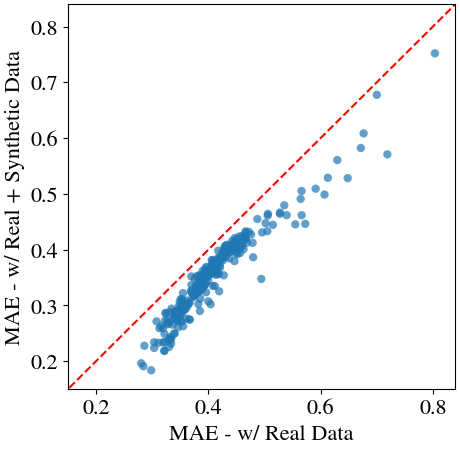

In [11]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight', 'pad_inches': 0.05}

plt.figure(figsize=(5,5))
plt.scatter(abs(error_real[unselected_spots_idx]).mean(axis=0), abs(error_real_gen[unselected_spots_idx]).mean(axis=0),
            alpha=0.7, edgecolors='none')
plt.xlim(0.15, 0.84)
plt.xlabel("MAE - w/ Real Data")
plt.ylabel("MAE - w/ Real + Synthetic Data")
plt.ylim(0.15,0.84)
plt.plot([0,1],[0,1], color='red', linestyle='--')

In [ ]:
raise RuntimeError("Stop here")

In [12]:
adata.var_names[np.argsort(abs(error_real).mean(axis=0) -abs(error_real_gen).mean(axis=0))[::-1][:10]]

Index(['OLFM4', 'PIGR', 'RPS24', 'IGKC', 'HLA-B', 'FCGBP', 'SPINK4', 'B2M',
       'MUC2', 'EEF1A1'],
      dtype='object')

In [13]:
gene_name = {"ZEN48": "B2M", "MEND40":"IGKC", "TENX13": "COX6C","MEND90":"SFTPC"}[id]#  for MEND90
gene_idx = adata.var_names.tolist().index(gene_name)

In [14]:
gene_error_real = error_real[:, gene_idx]
gene_error_real_gen = error_real_gen[:, gene_idx]
print(f"Gene: {gene_name}, Real MAE: {np.mean(np.abs(gene_error_real[unselected_spots_idx])):.4f}, Real+Gen MAE: {np.mean(np.abs(gene_error_real_gen[unselected_spots_idx])):.4f}")

Gene: B2M, Real MAE: 0.3304, Real+Gen MAE: 0.2259


In [ ]:
raise RuntimeError("Stop here")

In [15]:
_plot_gene(adata.X,                             gene_idx=gene_idx, s=s, vmax=vmax,vmin = 0, gene_cmap=gene_cmap,axis=True, color_bar=False)

NameError: name 's' is not defined

In [21]:
len(selected_spots_idx), len(unselected_spots_idx)

(596, 1789)

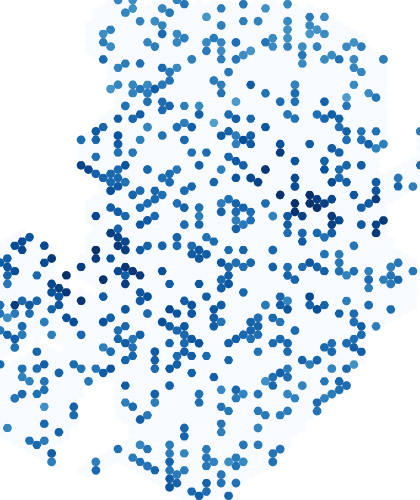

5


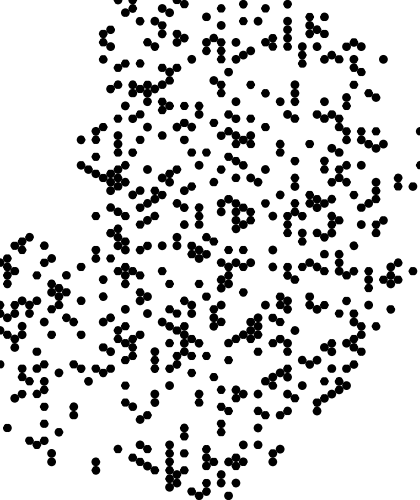

1


In [20]:
sim_ = np.zeros((adata.shape[0], adata.shape[1]))
sim_[selected_spots_idx, gene_idx] = real_pred_[selected_spots_idx, gene_idx]
_plot_gene(sim_,                             gene_idx=gene_idx, s=s, vmax=vmax,vmin = 0, gene_cmap=gene_cmap, rectangles=rectangles)
sim_[selected_spots_idx, gene_idx] = 1
_plot_gene(sim_,                             gene_idx=gene_idx, s=s, vmax=1,vmin = 0, gene_cmap="binary", rectangles=rectangles)

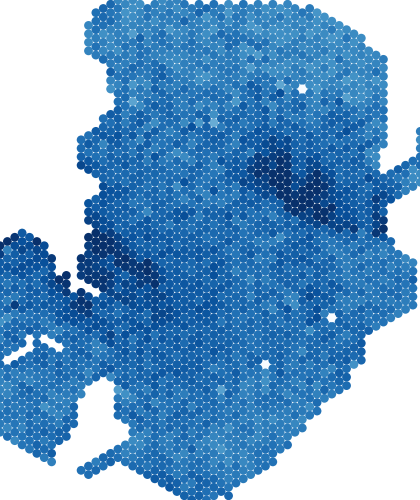

5


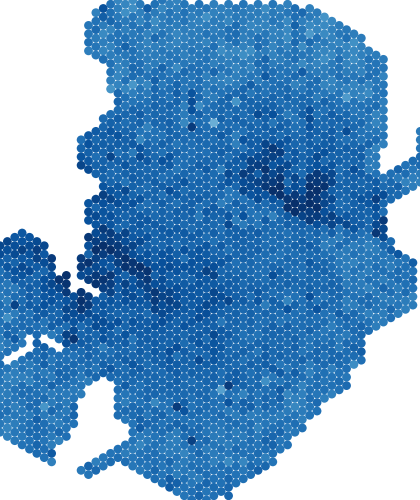

5


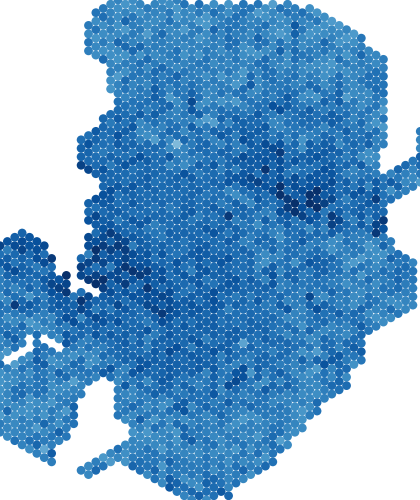

5


In [17]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight', 'pad_inches': 0.}

vmax = {"ZEN48":5,"TENX13":7,"MEND40":6,"MEND90":7}[id]

s = {"ZEN48":40,"TENX13":35,"MEND40":40,"MEND90":35}[id]
x1,x2,y1,y2 = {"ZEN48":[8500,10500,9000,11000],
               "TENX13":[9500,12500,6500,9500],
               "MEND40":[15000,20000,28000,33000],
               "MEND90":[0,0,0,0]
               }[id]
# rectangles = [[x1,x2,y1,y2,'red',2]]
rectangles = None

gene_cmap = "Blues"
_plot_gene(adata.X,                             gene_idx=gene_idx, s=s, vmax=vmax,vmin = 0, gene_cmap=gene_cmap, rectangles=rectangles)
_plot_gene(pred_matrixs_real_gens[-1].numpy(),  gene_idx=gene_idx, s=s, vmax=vmax,vmin = 0, gene_cmap=gene_cmap, rectangles=rectangles)
_plot_gene(pred_matrixs_reals[-1].numpy(),      gene_idx=gene_idx, s=s, vmax=vmax,vmin = 0, gene_cmap=gene_cmap, rectangles=rectangles)

In [ ]:
s_ = {"ZEN48":480,"TENX13":340,"MEND40":520}[id]
crop = [x1, x2, y1, y2]

_plot_gene(adata.X, gene_idx=gene_idx, s=s_, vmax=vmax, gene_cmap=gene_cmap, axis=False, crop=crop)
_plot_gene(pred_matrixs_real_gens[-1], gene_idx=gene_idx, s=s_, vmax=vmax, gene_cmap=gene_cmap, axis=False, crop=crop)
_plot_gene(pred_matrixs_reals[-1], gene_idx=gene_idx, s=s_, vmax=vmax, gene_cmap=gene_cmap, axis=False, crop=crop)

In [ ]:
s_ = 70
x1 = 7750 # 12250
y1 = 8500 # 8500
crop = [x1,x1+4500,y1,y1 + 3500]

_plot_gene(adata.X, gene_idx=gene_idx, s=s_, vmax=vmax, gene_cmap=gene_cmap,axis = False,crop =crop),_plot_gene(pred_matrixs_reals[-1], gene_idx=gene_idx, s=s_, vmax=vmax, gene_cmap=gene_cmap,axis = False,crop = crop),_plot_gene(pred_matrixs_real_gens[-1], gene_idx=gene_idx, s=s_, vmax=vmax, gene_cmap=gene_cmap,axis = False,crop = crop)

In [ ]:
vmax = 3
cmap_ = "Greens"
_plot_error_abs(error_real, gene_idx=gene_idx, s=s, vmax=vmax, error_cmap=cmap_), _plot_error_abs(error_real_gen, gene_idx=gene_idx, s=s, vmax=vmax, error_cmap=cmap_)

In [ ]:
vmax = 3
cmap_ = "Greens"
s_ = 30
x1 = 1500 # 12250
y1 = 6550 # 8500
crop = (x1,x1+4500,y1,y1 + 3500)

_plot_error_abs(error_real, gene_idx=gene_idx, s=s_, vmax=vmax, error_cmap=cmap_,crop =crop), _plot_error_abs(error_real_gen, gene_idx=gene_idx, s=s_, vmax=vmax, error_cmap=cmap_,crop = crop)

In [ ]:
_plot(diff_real_gen, gene_idx=gene_idx, s=s, vmax=None, error_cmap=error_camp2)
raise RuntimeError("Stop here")

### improvement

In [ ]:
import torch
from copy import deepcopy

gen_ls, real_ls, real_gen_ls = [], [], []
gen_accs, real_accs, real_gen_accs= [], [], []
gen_aucs, real_aucs, real_gen_aucs= [], [], []
for per_ in ["_0.05","_0.1",'',"_0.5"]:
    for samplemax in [1,2,3,4,5,6,7,8,9,10]:
        ids = 'TENX13TENX13'  # Breast
        # 'MEND40MEND40'  # skin
        # 'MEND52MEND52' # Lung
        # MEND90MEND90 # Lung
        # 'TENX13TENX13 # Breast
        # 'MEND35MEND35'
        # 'ZEN47ZEN47
        # ZEN48ZEN48
        # ZEN40ZEN40
        
        # MEND35MEND35
        # MEND96MEND96
        # ZEN48ZEN48
        # MISC34MISC34
        # MISC73MISC73
        
        # MEND36MEND35
        # MISC71MISC70    xxxxxx
        # MEND96MEND93    
        # ZEN49ZEN48
        # concat
        try:
            # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_ann/last_model.pth"
            # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wnoise/last_model.pth"
            # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise/last_model.pth"
            # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_num_film_layers2_HVG/last_model.pth"
            ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_num_film_layers2{per_}/last_model.pth"
            ck = torch.load(ckp, map_location="cpu", weights_only=False)
            gen_losseses = ck['gen_losseses']
            real_losseses = ck['real_losseses']
            
            test_gen_losseses = ck['test_gen_losseses']
            test_real_losseses = ck['test_real_losseses']
            test_real_gen_losseses = ck['test_real_gen_losseses']
            gen_ls.append(test_gen_losseses[-1])
            real_ls.append(test_real_losseses[-1])
            real_gen_ls.append(test_real_gen_losseses[-1])
            try:
                test_gen_accses = ck['test_gen_accses']
                test_real_accses = ck['test_real_accses']
                test_real_gen_accses = ck['test_real_gen_accses']
                gen_accs.append(test_gen_accses[-1])
                real_accs.append(test_real_accses[-1])
                real_gen_accs.append(test_real_gen_accses[-1])
                
                test_gen_aucses = ck['test_gen_aucses']
                test_real_aucses = ck['test_real_aucses']
                test_real_gen_aucses = ck['test_real_gen_aucses']
                gen_aucs.append(test_gen_aucses[-1])
                real_aucs.append(test_real_aucses[-1])
                real_gen_aucs.append(test_real_gen_aucses[-1])
            except:
                pass
        except:
            pass
    
gen_ls_ = deepcopy(gen_ls)
real_ls_ = deepcopy(real_ls)
real_gen_ls_ = deepcopy(real_gen_ls)
gen_accs_ = deepcopy(gen_accs)
real_accs_ = deepcopy(real_accs)
real_gen_accs_ = deepcopy(real_gen_accs)
gen_aucs_ = deepcopy(gen_aucs)
real_aucs_ = deepcopy(real_aucs)
real_gen_aucs_ = deepcopy(real_gen_aucs)


# # mixup 1.0
# ck_mixup = torch.load(f"./model_save/{id_}_gene_pred_mixup_alpha_1.0_cutmixup_alpha_0.0_prob_cutmixup_0.0_allmixed_image_transform/last_model.pth", map_location="cpu", weights_only=False)
# gen_losseses_mixup = ck_mixup['gen_losseses']
# real_losseses_mixup = ck_mixup['real_losseses']
# real_gen_losseses_mixup = ck_mixup['real_gen_losseses']
# test_gen_losseses_mixup = ck_mixup['test_gen_losseses']
# test_real_losseses_mixup = ck_mixup['test_real_losseses']
# test_real_gen_losseses_mixup = ck_mixup['test_real_gen_losseses']

# # # cutmix 1.0
# ck_cutmix = torch.load(f"./model_save/{id_}_gene_pred_mixup_alpha_0.0_cutmixup_alpha_1.0_prob_cutmixup_1.0_allmixed_image_transform/last_model.pth", map_location="cpu", weights_only=False)
# gen_losseses_cutmix = ck_cutmix['gen_losseses']
# real_losseses_cutmix = ck_cutmix['real_losseses']
# real_gen_losseses_cutmix = ck_cutmix['real_gen_losseses']
# test_gen_losseses_cutmix = ck_cutmix['test_gen_losseses']
# test_real_losseses_cutmix = ck_cutmix['test_real_losseses']
# test_real_gen_losseses_cutmix = ck_cutmix['test_real_gen_losseses']

In [ ]:
import numpy as np
print(ids[:len(ids)//2])
print(f"0.05: real only {np.mean(real_ls[:10]):.4f}" )
print(f"0.05: w/ synthetic {[round(i,4) for i in gen_ls[:10]]}" )
print(f"0.05: w/ real + synthetic {[round(i,4) for i in real_gen_ls[:10]]}" )

print(f"0.1: real only {np.mean(real_ls[10:20]):.4f}" )
print(f"0.1: w/ synthetic {[round(i,4) for i in gen_ls[10:20]]}" )
print(f"0.1: w/ real + synthetic {[round(i,4) for i in real_gen_ls[10:20]]}" )

print(f"0.25: real only {np.mean(real_ls[20:30]):.4f}" )
print(f"0.25: w/ synthetic {[round(i,4) for i in gen_ls[20:30]]}" )
print(f"0.25: w/ real + synthetic {[round(i,4) for i in real_gen_ls[20:30]]}" )

print(f"0.5: real only {np.mean(real_ls[30:40]):.4f}" )
print(f"0.5: w/ synthetic {[round(i,4) for i in gen_ls[30:40]]}" )
print(f"0.5: w/ real + synthetic {[round(i,4) for i in real_gen_ls[30:40]]}" )

In [ ]:
# ZEN48
# 0.05: real only 0.5944
# 0.05: w/ synthetic [0.6699, 0.524, 0.4817, 0.4947, 0.4982, 0.4592, 0.4488, 0.4477, 0.4368, 0.4245]
# 0.05: w/ real + synthetic [0.5052, 0.4809, 0.4257, 0.4502, 0.4219, 0.4217, 0.4231, 0.4171, 0.4141, 0.4104]
# 0.1: real only 0.4928
# 0.1: w/ synthetic [0.5365, 0.4269, 0.4378, 0.411, 0.3974, 0.4022, 0.3974, 0.3907, 0.3853, 0.3812]
# 0.1: w/ real + synthetic [0.4427, 0.4166, 0.4073, 0.401, 0.3927, 0.3933, 0.3797, 0.383, 0.3789, 0.3792]
# 0.25: real only 0.4115
# 0.25: w/ synthetic [0.4078, 0.4011, 0.3972, 0.3863, 0.3819, 0.3762, 0.3692, 0.3641, 0.3627, 0.3604]
# 0.25: w/ real + synthetic [0.3993, 0.3888, 0.3789, 0.377, 0.3699, 0.3657, 0.3607, 0.3569, 0.3539, 0.3546]
# 0.5: real only 0.3994
# 0.5: w/ synthetic [0.4027, 0.3959, 0.3926, 0.3854, 0.3792, 0.3735, 0.3671, 0.3621, 0.3589, 0.3547]
# 0.5: w/ real + synthetic [0.3827, 0.3856, 0.3788, 0.3744, 0.3665, 0.3607, 0.3558, 0.3535, 0.3511, 0.349]

# TENX13
# 0.05: real only 0.5950
# 0.05: w/ synthetic [0.596, 0.4298, 0.4028, 0.405, 0.3933, 0.3814, 0.3793, 0.3736, 0.3705, 0.3679]
# 0.05: w/ real + synthetic [0.4784, 0.4083, 0.398, 0.3912, 0.3834, 0.3786, 0.3753, 0.3729, 0.3686, 0.368]
# 0.1: real only 0.4240
# 0.1: w/ synthetic [0.4318, 0.404, 0.3886, 0.3808, 0.3728, 0.3681, 0.3637, 0.3584, 0.3566, 0.3553]
# 0.1: w/ real + synthetic [0.3998, 0.3923, 0.3805, 0.3733, 0.3646, 0.3628, 0.3575, 0.3547, 0.3527, 0.3523]
# 0.25: real only 0.3903
# 0.25: w/ synthetic [0.3933, 0.3804, 0.3727, 0.3674, 0.3585, 0.3526, 0.3523, 0.3458, 0.3447, 0.3419]
# 0.25: w/ real + synthetic [0.3755, 0.3636, 0.3628, 0.3559, 0.3511, 0.3463, 0.3462, 0.3405, 0.3386, 0.3391]
# 0.5: real only 0.3819
# 0.5: w/ synthetic [0.3844, 0.3804, 0.3713, 0.3652, 0.3595, 0.3545, 0.3528, 0.3473, 0.3432, 0.3433]
# 0.5: w/ real + synthetic [0.3735, 0.3668, 0.3596, 0.3531, 0.3492, 0.3447, 0.341, 0.3385, 0.338, 0.3369]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
# ====== 设置全局字体 ======
plt.rcParams['font.family'] = 'STIXGeneral'  # Matplotlib 自带字体
plt.rcParams['font.size'] = 16                 # 全局字号
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题（特别是中文字体时）

def plot_grouped_bars(
    gen_ls_, real_ls_, real_gen_ls_,
    ratios=(0.05, 0.10, 0.25, 0.50),
    bars_per_group=10,
    show_values=False,
    values_mode='ends',         # 'ends' 或 'all'
    save_path=None,
    group_gap=0.6,              # ← 新：组间距更小
    bar_w=0.40,                 # 可继续调粗细
    side_pad=0.25               # ← 新：左右留白（单位≈一个柱宽）
):
    color_gen = '#1f77b4'
    color_rg  = '#ff8c00'
    baseline_color = '#d62728'

    fig, ax = plt.subplots(figsize=(20, 10))

    x_start = 0.0
    all_x_positions, all_x_labels = [], []

    # baseline 图例
    ax.plot([], [], linestyle='--', color=baseline_color, linewidth=3,
            label='w/ Real Data (Baseline)')

    for i, r in enumerate(ratios):
        s0, s1 = i * bars_per_group, (i + 1) * bars_per_group
        ls = np.asarray(gen_ls_[s0:s1])
        real_ls = np.asarray(real_ls_[s0:s1])
        real_gen_ls = np.asarray(real_gen_ls_[s0:s1])

        n = int(min(len(ls), len(real_ls), len(real_gen_ls), bars_per_group))
        if n == 0:
            print(f"[WARN] ratio={r:.2f} 无数据，跳过。")
            continue

        ls, real_ls, real_gen_ls = ls[:n], real_ls[:n], real_gen_ls[:n]
        x = np.arange(n) + x_start

        bars_gen = ax.bar(x - bar_w/2, ls, width=bar_w, color=color_gen, alpha=0.9,
                          label='w/ Synthetic Data' if i == 0 else None)
        bars_rg  = ax.bar(x + bar_w/2, real_gen_ls, width=bar_w, color=color_rg, alpha=0.9,
                          label='w/ Real + Synthetic Data' if i == 0 else None)

        mean_real = float(np.mean(real_ls))
        ax.hlines(mean_real, x_start - 0.5, x_start + n - 0.5,
                  colors=baseline_color, linestyles='--', linewidth=3.0)
        ax.text(x_start + (n - 1)/2.0, mean_real + 0.02, f'{int(r*100)}% Real Data Only\nMAE: {mean_real:.3f}',
                ha='center', va='bottom', fontsize=18, color='#444', fontweight='bold')

        if show_values:
            def _annotate(bars, color, which='ends'):
                idxs = range(len(bars)) if which == 'all' else [0, len(bars)-1]
                for k in idxs:
                    b = bars[k]
                    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.01,
                            f"{b.get_height():.3f}",
                            ha='center', va='bottom', fontsize=12, color=color, alpha=0.8)
            _annotate(bars_gen, color_gen, which=values_mode)
            _annotate(bars_rg,  color_rg,  which=values_mode)

        all_x_positions.extend(x)
        all_x_labels.extend([str(i+1) for i in range(n)])
        x_start += n + group_gap   # ← 更小的组间距

    # 轴与外观
    ax.set_xlabel("Number of Synthetic Samples per Real Sample", fontsize=20)
    ax.set_ylabel("MAE", fontsize=22)
    # ax.set_title("Effect of Synthetic Sample Ratio on Gene Prediction Loss", fontsize=25, pad=20, fontweight='bold')
    ax.grid(alpha=0.25, axis='y')
    ax.legend(frameon=False, ncol=3, fontsize=20, loc='upper right')
    ax.set_xticks(all_x_positions, all_x_labels)
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
    ax.set_ylim(bottom=0, top=np.max(gen_ls_)*1.12)

    # ✅ 关键：紧收左右留白
    if all_x_positions:
        min_x, max_x = min(all_x_positions), max(all_x_positions)
        ax.set_xlim(min_x - side_pad-0.6, max_x + side_pad+0.6)
    ax.margins(x=0)  # 关闭自动外延

    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=400, bbox_inches='tight')
        print(f"[INFO] Figure saved to: {save_path}")
    else:
        plt.show()

plot_grouped_bars(gen_ls_, real_ls_, real_gen_ls_)# save_path="synthetic_ratio_loss.png"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 gen_ls_, real_ls_, real_gen_ls_ 都是长度 >= 40 的 list
ratios = [0.05, 0.10, 0.25, 0.5]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(16, 12))

for i, r in enumerate(ratios):
    ls = gen_ls_[i*10:(i+1)*10]
    real_ls = real_ls_[i*10:(i+1)*10]
    real_gen_ls = real_gen_ls_[i*10:(i+1)*10]
    
    plt.plot(np.arange(1, len(ls)+1), ls, marker='o', color=colors[i],
             label=f'Gen (Sampling {r*100}% spots)', linewidth=1.8)
    plt.plot(np.arange(1, len(real_gen_ls)+1), real_gen_ls, marker='s', 
             linestyle='--', color=colors[i],
             label=f'Real+Gen (Sampling {r*100}% spots)', linewidth=1.8)
    plt.axhline(y=np.mean(real_ls), color=colors[i], linestyle=':', linewidth=1.2)

plt.xlabel("Number of Synthetic Samples per Real Sample", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Effect of Synthetic Sample Ratio on Gene Prediction Loss", fontsize=13)
plt.legend(frameon=False, ncol=2)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [ ]:
import torch
from copy import deepcopy

gen_ls, real_ls, real_gen_ls = [], [], []
gen_accs, real_accs, real_gen_accs= [], [], []
gen_aucs, real_aucs, real_gen_aucs= [], [], []

for samplemax in [1,2,3,4,5,6,7,8,9,10]:
    ids = 'TENX13TENX13' 
    # organ = 'skin'
    # 'MEND40MEND40'  # skin
    # 'MEND52MEND52' # Lung
    # MEND90MEND90 # Lung
    # 'TENX13TENX13 # Breast
    # 'MEND35MEND35'
    # 'ZEN47ZEN47
    # ZEN48ZEN48
    # ZEN40ZEN40
    
    # MEND35MEND35
    # MEND96MEND96
    # ZEN48ZEN48
    # MISC34MISC34
    # MISC73MISC73
    
    # MEND36MEND35
    # MISC71MISC70    xxxxxx
    # MEND96MEND93    
    # ZEN49ZEN48
    # concat
    try:
        # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_ann/last_model.pth"
        # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wnoise/last_model.pth"
        # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise/last_model.pth"
        # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_num_film_layers2/last_model.pth"
        # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_num_film_layers2{per_}/last_model.pth"
        ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_num_film_layers21/last_model.pth"
        ck = torch.load(ckp, map_location="cpu", weights_only=False)
        gen_losseses = ck['gen_losseses']
        real_losseses = ck['real_losseses']
        
        test_gen_losseses = ck['test_gen_losseses']
        test_real_losseses = ck['test_real_losseses']
        test_real_gen_losseses = ck['test_real_gen_losseses']
        gen_ls.append(test_gen_losseses[-1])
        real_ls.append(test_real_losseses[-1])
        real_gen_ls.append(test_real_gen_losseses[-1])
        try:
            test_gen_accses = ck['test_gen_accses']
            test_real_accses = ck['test_real_accses']
            test_real_gen_accses = ck['test_real_gen_accses']
            gen_accs.append(test_gen_accses[-1])
            real_accs.append(test_real_accses[-1])
            real_gen_accs.append(test_real_gen_accses[-1])
            
            test_gen_aucses = ck['test_gen_aucses']
            test_real_aucses = ck['test_real_aucses']
            test_real_gen_aucses = ck['test_real_gen_aucses']
            gen_aucs.append(test_gen_aucses[-1])
            real_aucs.append(test_real_aucses[-1])
            real_gen_aucs.append(test_real_gen_aucses[-1])
        except:
            pass
    except:
        pass
    
gen_ls_ = deepcopy(gen_ls)
real_ls_ = deepcopy(real_ls)
real_gen_ls_ = deepcopy(real_gen_ls)
gen_accs_ = deepcopy(gen_accs)
real_accs_ = deepcopy(real_accs)
real_gen_accs_ = deepcopy(real_gen_accs)
gen_aucs_ = deepcopy(gen_aucs)
real_aucs_ = deepcopy(real_aucs)
real_gen_aucs_ = deepcopy(real_gen_aucs)


# # mixup 1.0
# ck_mixup = torch.load(f"./model_save/{id_}_gene_pred_mixup_alpha_1.0_cutmixup_alpha_0.0_prob_cutmixup_0.0_allmixed_image_transform/last_model.pth", map_location="cpu", weights_only=False)
# gen_losseses_mixup = ck_mixup['gen_losseses']
# real_losseses_mixup = ck_mixup['real_losseses']
# real_gen_losseses_mixup = ck_mixup['real_gen_losseses']
# test_gen_losseses_mixup = ck_mixup['test_gen_losseses']
# test_real_losseses_mixup = ck_mixup['test_real_losseses']
# test_real_gen_losseses_mixup = ck_mixup['test_real_gen_losseses']

# # # cutmix 1.0
# ck_cutmix = torch.load(f"./model_save/{id_}_gene_pred_mixup_alpha_0.0_cutmixup_alpha_1.0_prob_cutmixup_1.0_allmixed_image_transform/last_model.pth", map_location="cpu", weights_only=False)
# gen_losseses_cutmix = ck_cutmix['gen_losseses']
# real_losseses_cutmix = ck_cutmix['real_losseses']
# real_gen_losseses_cutmix = ck_cutmix['real_gen_losseses']
# test_gen_losseses_cutmix = ck_cutmix['test_gen_losseses']
# test_real_losseses_cutmix = ck_cutmix['test_real_losseses']
# test_real_gen_losseses_cutmix = ck_cutmix['test_real_gen_losseses']

In [ ]:
import numpy as np
print(f'{ids[:len(ids)//2]}')
print(f"w/ Real Data {np.mean(real_ls):.4f}")
print(f"w/ Synthetic Data {[round(i, 4) for i in gen_ls]}")
print(f"w/ Real & Synthetic Data {[round(i, 4) for i in real_gen_ls]}")

In [ ]:
ZEN48
w/ Real Data 0.4115
w/ Synthetic Data [0.4078, 0.4011, 0.3972, 0.3863, 0.3819, 0.3762, 0.3692, 0.3641, 0.3627, 0.3604]
w/ Real & Synthetic Data [0.3993, 0.3888, 0.3789, 0.377, 0.3699, 0.3657, 0.3607, 0.3569, 0.3539, 0.3546]

TENX13
w/ Real Data 0.3903
w/ Synthetic Data [0.3933, 0.3804, 0.3727, 0.3674, 0.3585, 0.3526, 0.3523, 0.3458, 0.3447, 0.3419]
w/ Real & Synthetic Data [0.3755, 0.3636, 0.3628, 0.3559, 0.3511, 0.3463, 0.3462, 0.3405, 0.3386, 0.3391]

MEND40
w/ Real Data 0.5451
w/ Synthetic Data [0.5492, 0.5333, 0.5241, 0.5148, 0.5084, 0.5057, 0.5193, 0.504, 0.5033, 0.5058]
w/ Real & Synthetic Data [0.5298, 0.5165, 0.5116, 0.5054, 0.5, 0.4969, 0.5074, 0.4962, 0.499, 0.5016]

MEND90
w/ Real Data 0.5030
w/ Synthetic Data [0.4952, 0.4936, 0.4816, 0.477, 0.4704, 0.4629, 0.4639, 0.4559, 0.4542, 0.4524]
w/ Real & Synthetic Data [0.4903, 0.4879, 0.4696, 0.467, 0.4587, 0.4558, 0.4536, 0.4488, 0.4465, 0.4469]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# ====== 设置全局字体 ======
plt.rcParams['font.family'] = 'STIXGeneral'  # Matplotlib 自带字体
plt.rcParams['font.size'] = 16                 # 全局字号
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题（特别是中文字体时）

plt.figure(figsize=(8, 6),dpi=100)
plt.plot(np.arange(1, len(gen_ls)+1),gen_ls, label="w/ Synthetic Data", marker='o', linewidth=1.8)
# plt.plot(real_ls, label="Real")
plt.axhline(y=np.mean(real_ls), color='r', linestyle='--', label='w/ Real Data')
plt.plot(np.arange(1, len(gen_ls)+1),real_gen_ls, label="w/ Real & Synthetic Data", marker='s', linewidth=1.8)
# plt.plot(real_gen_ls, label="Real+Gen")
plt.legend(frameon=False,loc='lower left')
# plt.grid(0.)
plt.xlabel("Number of Synthetic Samples per Real Sample")
plt.ylabel("Mean Absolute Error (MAE)")
# plt.ylim(0.4, 0.5)
plt.xticks(np.arange(1, len(gen_ls)+1))
# plt.title(f"{organ} - {ids[:len(ids)//2]}")
# plt.title("Effect of Synthetic Sample Size on Gene Prediction Loss")
plt.show()

In [ ]:
ck.keys()

In [ ]:
# import torch

# gen_ls, real_ls, real_gen_ls = [], [], []
# gen_accs, real_accs, real_gen_accs= [], [], []
# gen_aucs, real_aucs, real_gen_aucs= [], [], []
# for samplemax in [1,2,3,4,5,6,7,8,9,10]:
#     ids = 'MEND96MEND96'
#     # 'ZEN47ZEN47
#     # ZEN48ZEN48
#     # ZEN40ZEN40
    
#     # MEND35MEND35
#     # MEND96MEND96
#     # ZEN48ZEN48
#     # MISC34MISC34
#     # MISC73MISC73
    
#     # MEND36MEND35
#     # MISC71MISC70    xxxxxx
#     # MEND96MEND93    
#     # ZEN49ZEN48
#     # concat
#     try:
#         # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise_ann/last_model.pth"
#         # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wnoise/last_model.pth"
#         # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_wonoise/last_model.pth"
#         # ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_data_aug_image_transform_wnoise/last_model.pth"
#         ckp = f"./model_save/{ids}_gene_pred_resnet50_samplemax{samplemax}_image_transform_num_film_layers2/last_model.pth"
#         ck = torch.load(ckp, map_location="cpu", weights_only=False)
#         gen_losseses = ck['gen_losseses']
#         real_losseses = ck['real_losseses']
        
#         test_gen_losseses = ck['test_gen_losseses']
#         test_real_losseses = ck['test_real_losseses']
#         test_real_gen_losseses = ck['test_real_gen_losseses']
#         gen_ls.append(test_gen_losseses[-1])
#         real_ls.append(test_real_losseses[-1])
#         real_gen_ls.append(test_real_gen_losseses[-1])
#         try:
#             test_gen_accses = ck['test_gen_accses']
#             test_real_accses = ck['test_real_accses']
#             test_real_gen_accses = ck['test_real_gen_accses']
#             gen_accs.append(test_gen_accses[-1])
#             real_accs.append(test_real_accses[-1])
#             real_gen_accs.append(test_real_gen_accses[-1])
            
#             test_gen_aucses = ck['test_gen_aucses']
#             test_real_aucses = ck['test_real_aucses']
#             test_real_gen_aucses = ck['test_real_gen_aucses']
#             gen_aucs.append(test_gen_aucses[-1])
#             real_aucs.append(test_real_aucses[-1])
#             real_gen_aucs.append(test_real_gen_aucses[-1])
#         except:
#             pass
#     except:
#         pass
    

# # # mixup 1.0
# # ck_mixup = torch.load(f"./model_save/{id_}_gene_pred_mixup_alpha_1.0_cutmixup_alpha_0.0_prob_cutmixup_0.0_allmixed_image_transform/last_model.pth", map_location="cpu", weights_only=False)
# # gen_losseses_mixup = ck_mixup['gen_losseses']
# # real_losseses_mixup = ck_mixup['real_losseses']
# # real_gen_losseses_mixup = ck_mixup['real_gen_losseses']
# # test_gen_losseses_mixup = ck_mixup['test_gen_losseses']
# # test_real_losseses_mixup = ck_mixup['test_real_losseses']
# # test_real_gen_losseses_mixup = ck_mixup['test_real_gen_losseses']

# # # # cutmix 1.0
# # ck_cutmix = torch.load(f"./model_save/{id_}_gene_pred_mixup_alpha_0.0_cutmixup_alpha_1.0_prob_cutmixup_1.0_allmixed_image_transform/last_model.pth", map_location="cpu", weights_only=False)
# # gen_losseses_cutmix = ck_cutmix['gen_losseses']
# # real_losseses_cutmix = ck_cutmix['real_losseses']
# # real_gen_losseses_cutmix = ck_cutmix['real_gen_losseses']
# # test_gen_losseses_cutmix = ck_cutmix['test_gen_losseses']
# # test_real_losseses_cutmix = ck_cutmix['test_real_losseses']
# # test_real_gen_losseses_cutmix = ck_cutmix['test_real_gen_losseses']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, len(gen_accs)+1), gen_accs, label="Gen", marker='o')
# plt.plot(np.arange(1, len(real_accs)+1), real_accs, label="Real", marker='^')
plt.axhline(y=np.mean(real_accs), color='r', linestyle='--', label='Real Mean')
plt.plot(np.arange(1, len(real_gen_accs)+1), real_gen_accs, label="Real+Gen", marker='s')
# plt.plot(real_gen_ls, label="Real+Gen")
plt.legend()
plt.xlabel("Number of Synthetic Samples per Real Sample")
plt.ylabel("Patch Type Annotation Accuracy")
# plt.ylim(0.4, 0.5)
plt.xticks(np.arange(1, len(gen_accs)+1))
plt.title("Effect of Synthetic Sample Size on Patch Type Annotation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, len(gen_aucs)+1), gen_aucs, label="Gen", marker='o')
# plt.plot(real_ls, label="Real")
plt.axhline(y=np.mean(real_aucs), color='r', linestyle='--', label='Real Mean')
plt.plot(np.arange(1, len(real_gen_aucs)+1), real_gen_aucs, label="Real+Gen", marker='s')
# plt.plot(real_gen_ls, label="Real+Gen")
plt.legend()
plt.xlabel("Number of Synthetic Samples per Real Sample")
plt.ylabel("Cell Type Annotation AUC")
# plt.ylim(0.4, 0.5)
plt.xticks(np.arange(1, len(gen_aucs)+1))
plt.title("Effect of Synthetic Sample Size on Cell Type Annotation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

plt.plot(np.arange(1, len(gen_ls_)+1),gen_ls_, label="Gen", marker='o')
# plt.plot(real_ls_, label="Real")
plt.axhline(y=np.mean(real_ls_), color='r', linestyle='--', label='Real Mean')
plt.plot(np.arange(1, len(gen_ls_)+1),real_gen_ls_, label="Real+Gen", marker='s')
# plt.plot(real_gen_ls_, label="Real+Gen")
plt.legend()
plt.xlabel("Number of Synthetic Samples per Real Sample")
plt.ylabel("Loss")
# plt.ylim(0.4, 0.5)
plt.xticks(np.arange(1, len(gen_ls)+1))
plt.title("Effect of Synthetic Sample Size on Gene Prediction Loss")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, len(gen_ls)+1),gen_ls, label="Gen", marker='o')
# plt.plot(real_ls, label="Real")
plt.axhline(y=np.mean(real_ls), color='r', linestyle='--', label='Real Mean')
plt.plot(np.arange(1, len(gen_ls)+1),real_gen_ls, label="Real+Gen", marker='s')
# plt.plot(real_gen_ls, label="Real+Gen")
plt.legend()
plt.xlabel("Number of Synthetic Samples per Real Sample")
plt.ylabel("Loss")
# plt.ylim(0.4, 0.5)
plt.xticks(np.arange(1, len(gen_ls)+1))
plt.title("Effect of Synthetic Sample Size on Gene Prediction Loss")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, len(gen_ls)+1),gen_ls, label="Gen (w/o data aug)", marker='o')
# plt.plot(real_ls, label="Real")
plt.axhline(y=np.mean(real_ls), color='r', linestyle='--', label='Real Mean (w/o data aug)')
plt.plot(np.arange(1, len(gen_ls)+1),real_gen_ls, label="Real+Gen (w/o data aug)", marker='s')
# plt.plot(real_gen_ls, label="Real+Gen")


plt.plot(np.arange(1, len(gen_ls_)+1),gen_ls_, label="Gen (w/ data aug)", marker='^')
plt.axhline(y=np.mean(real_ls_), color='orange', linestyle='--', label='Real Mean (w/ data aug)')
plt.plot(np.arange(1, len(gen_ls_)+1),real_gen_ls_, label="Real+Gen (w/ data aug)", marker='x')


plt.legend()
plt.xlabel("Number of Synthetic Samples per Real Sample")
plt.ylabel("Loss")
# plt.ylim(0.4, 0.5)
plt.xticks(np.arange(1, len(gen_ls)+1))
plt.title("Effect of Synthetic Sample Size on Gene Prediction Loss")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_gen_losseses_concat, label='Gen Test Loss Concat')
plt.plot(test_real_losseses_concat, label='Real Test Loss Concat')
plt.plot(test_real_gen_losseses_concat, label='Real + Gen Test Loss Concat')

# plt.plot(test_gen_losseses_mixup, label='Gen Test Loss Mixup 1.0')
# plt.plot(test_real_losseses_mixup, label='Real Test Loss Mixup 1.0')
# plt.plot(test_real_gen_losseses_mixup, label='Real + Gen Test Loss Mixup 1.0')

# plt.plot(test_gen_losseses_cutmix, label='Gen Test Loss CutMix 1.0')
# plt.plot(test_real_losseses_cutmix, label='Real Test Loss CutMix 1.0')
# plt.plot(test_real_gen_losseses_cutmix, label='Real + Gen Test Loss CutMix 1.0')

plt.ylim(0.3,0.55)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves for {id_}')

In [ ]:
import matplotlib.pyplot as plt

# plt.plot(test_gen_losseses_concat, label='Gen Test Loss Concat')
# plt.plot(test_real_losseses_concat, label='Real Test Loss Concat')
# plt.plot(test_real_gen_losseses_concat, label='Real + Gen Test Loss Concat')

# plt.plot(test_gen_losseses_mixup, label='Gen Test Loss Mixup 1.0')
# plt.plot(test_real_losseses_mixup, label='Real Test Loss Mixup 1.0')
# plt.plot(test_real_gen_losseses_mixup, label='Real + Gen Test Loss Mixup 1.0')

plt.plot(test_gen_losseses_cutmix, label='Gen Test Loss CutMix 1.0')
plt.plot(test_real_losseses_cutmix, label='Real Test Loss CutMix 1.0')
plt.plot(test_real_gen_losseses_cutmix, label='Real + Gen Test Loss CutMix 1.0')

plt.ylim(0.4,0.55)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves for {id_}')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_gen_losseses_mixup, label='Gen Test Loss Mixup 1.0')
plt.plot(test_real_losseses_mixup, label='Real Test Loss Mixup 1.0')
plt.plot(test_real_gen_losseses_mixup, label='Real + Gen Test Loss Mixup 1.0')

# plt.plot(test_gen_losseses_cutmix, label='Gen Test Loss CutMix 1.0')
# plt.plot(test_real_losseses_cutmix, label='Real Test Loss CutMix 1.0')
# plt.plot(test_real_gen_losseses_cutmix, label='Real + Gen Test Loss CutMix 1.0')

plt.ylim(0.4,0.8)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves for {id_}')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_gen_losseses_mixup, label='Gen Test Loss Mixup 1.0')
plt.plot(test_real_losseses_mixup, label='Real Test Loss Mixup 1.0')
plt.plot(test_real_gen_losseses_mixup, label='Real + Gen Test Loss Mixup 1.0')

plt.ylim(0.4,0.8)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves for {id_}')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(gen_losseses_mixup, label='Gen Test Loss Mixup 1.0')
plt.plot(real_losseses_mixup, label='Real Test Loss Mixup 1.0')
plt.plot(real_gen_losseses_mixup, label='Real + Gen Test Loss Mixup 1.0')

plt.ylim(0.1,0.55)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves for {id_}')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(gen_losseses_concat, label='Train Gen Loss (Concat)', color='blue', linestyle='-')
plt.plot(real_losseses_concat, label='Train Real Loss (Concat)', color='orange', linestyle='-')
plt.plot(real_gen_losseses_concat, label='Train Real Gen Loss (Concat)', color='green', linestyle='-')

plt.ylim(0.1,0.5)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves for {id_}')

In [ ]:
plt.plot(test_gen_losseses_concat, label='Test Gen Loss (Concat)', color='blue', linestyle='-')
plt.plot(test_real_losseses_concat, label='Test Real Loss (Concat)', color='orange', linestyle='-')
plt.plot(test_real_gen_losseses_concat, label='Test Real Gen Loss (Concat)', color='green', linestyle='-')
plt.ylim(0.4, 0.6)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves for {id_}')

# plt


## frmework

In [1]:
# %% [markdown]
# ## 导入必要模块
import sys
import os
from PIL import Image
import torch
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json

import classifier_free_guidance
import importlib
importlib.reload(classifier_free_guidance)
from classifier_free_guidance import *
data_dir = Path("../data/SPIDER/SPIDER-colorectal/SPIDER-colorectal")
img = Image.open(os.path.join(data_dir, "images_norm","patch_0045862.png"))
img3 = Image.fromarray((((np.random.randn(*np.array(img).shape)*0.5).clip(-1, 1) +1) / 2 * 255).astype(np.uint8))

s = [Image.fromarray(((((np.array(img)/255.0*2-1) * (1-i/10) + np.random.randn(*np.array(img).shape) * (i/10)).clip(-1, 1) +1) / 2 * 255).astype(np.uint8)) for i in range(10)]

In [2]:
with open(os.path.join(data_dir, "metadata.json")) as f:
    ann = json.load(f)

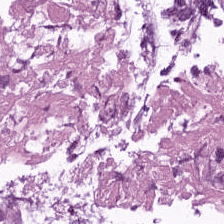

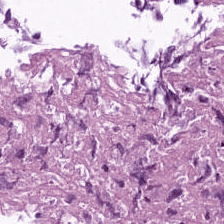

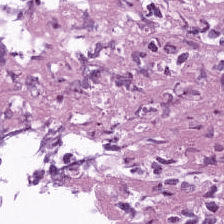

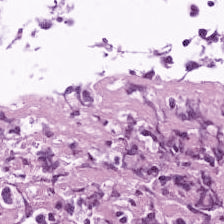

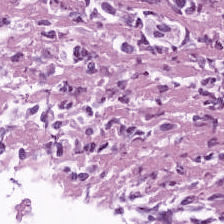

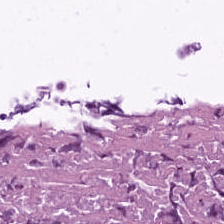

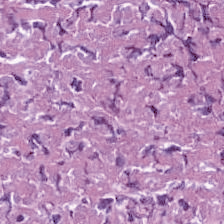

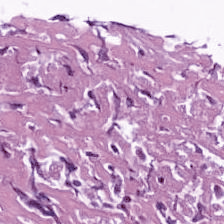

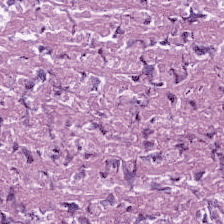

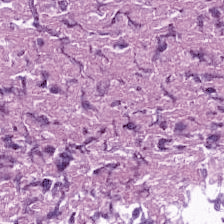

In [3]:
for i in range(10):
    img = Image.open(os.path.join(data_dir, "images_norm",ann[i]['image_name']))
    display(img)

In [4]:
import zarr
import numpy as np
import os
import scanpy as sc
id = "ZEN48"

adata = sc.read_h5ad(f"../data/hest/adata/{id}.h5ad")
if os.path.exists(f"./{id}_selected_spots_idx.npz"):
    data = np.load(f"./{id}_selected_spots_idx.npz", allow_pickle=True)
    selected_spots_idx = data['selected_spots_idx'].tolist()
    unselected_spots_idx = data['unselected_spots_idx'].tolist()
else:
    selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata.shape[0]), size=int(0.25 * adata.shape[0]), replace=False))]
    unselected_spots_idx = [np.setdiff1d(np.arange(0, adata.shape[0]), selected_spots_idx[0])]
    np.savez(f"./{id}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)

selected_spots_idx = selected_spots_idx[0]
unselected_spots_idx = unselected_spots_idx[0]

In [87]:
image_zarr = zarr.open(f"../GEN/patch_image_visium/{id}.zarr/patch_image_norm", mode='r')
image_zarr_gen = zarr.open(f"../data/hest/GEN/{id}_image_transform_self/samples.zarr/images", mode='r')

# for i in selected_spots_idx[:10]:
#     img = Image.fromarray(image_zarr_gen[i][0])
#     display(img)

PathNotFoundError: nothing found at path ''

/tmp/ipykernel_1469345/1062307719.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


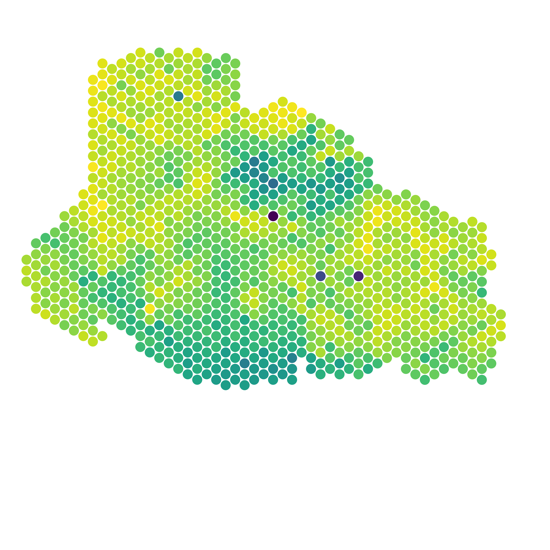

In [95]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import tifffile

width = 40
radius = 100   

# 1. 打开图片
img = np.zeros_like(tifffile.TiffFile("../data/hest/wsis/ZEN44.tif").pages[0].asarray()) + 255
img = Image.fromarray(img)

# 2. 获取画布
draw = ImageDraw.Draw(img)

# 计算所有点的 rowsum
rowsums = np.array(adata.X.sum(axis=1)).flatten()

# 标准化 rowsum 值到 [0, 1] 范围
min_val = rowsums.min()
max_val = rowsums.max()
normalized_rowsums = (rowsums - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(rowsums)

# 使用 viridis 颜色映射（你也可以改为其他如 'plasma', 'inferno', 'cividis' 等）
colormap = cm.get_cmap('viridis')

# 为所有点绘制
all_spots_idx = list(range(len(adata.obs)))

for id in all_spots_idx:
    # 获取坐标
    center_x, center_y = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]#  * adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef']
    
    # 计算左上角和右下角坐标
    left_up = (center_x - radius, center_y - radius)
    right_down = (center_x + radius, center_y + radius)
    
    # 根据 rowsum 获取颜色
    color_value = normalized_rowsums[id]
    rgba_color = colormap(color_value)
    # 转换为 RGB 格式 (0-255)
    rgb_color = tuple(int(c * 255) for c in rgba_color[:3])
    
    # 绘制填充的圆形或矩形
    # 选择圆形或矩形中的一种：
    
    # 圆形（推荐）
    draw.ellipse([left_up, right_down], fill=rgb_color, outline=None,width = width)
    
    # 或者矩形
    # draw.rectangle([left_up, right_down], fill=rgb_color, outline=None,width = width)


# for id in selected_spots_idx[:3]:
#     # 获取坐标
#     center_x, center_y = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]#  * adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef']
    
#     # 计算左上角和右下角坐标
#     left_up = (center_x - radius, center_y - radius)
#     right_down = (center_x + radius, center_y + radius)
    
#     # 根据 rowsum 获取颜色
#     color_value = normalized_rowsums[id]
#     rgba_color = colormap(color_value)
#     # 转换为 RGB 格式 (0-255)
#     rgb_color = tuple(int(c * 255) for c in rgba_color[:3])
    
#     # 绘制填充的圆形或矩形
#     # 选择圆形或矩形中的一种：
    
#     # 圆形（推荐）
#     # draw.ellipse([left_up, right_down], fill=rgb_color, outline=rgb_color,width = width)
    
#     # 或者矩形
#     draw.rectangle([left_up, right_down], fill=rgb_color, outline="red",width = width)

# for id in unselected_spots_idx[:5]:
#     # 获取坐标
#     center_x, center_y = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]#  * adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef']
    
#     # 计算左上角和右下角坐标
#     left_up = (center_x - radius, center_y - radius)
#     right_down = (center_x + radius, center_y + radius)
    
#     # 根据 rowsum 获取颜色
#     color_value = normalized_rowsums[id]
#     rgba_color = colormap(color_value)
#     # 转换为 RGB 格式 (0-255)
#     rgb_color = tuple(int(c * 255) for c in rgba_color[:3])
    
#     # 绘制填充的圆形或矩形
#     # 选择圆形或矩形中的一种：
    
#     # 圆形（推荐）
#     # draw.ellipse([left_up, right_down], fill=rgb_color, outline=rgb_color,width = width)
    
#     # 或者矩形
#     draw.rectangle([left_up, right_down], fill=rgb_color, outline="blue",width = width)
    
    
# 显示或保存
# 4. 显示或保存
# img.crop((70,100,70+800,100+800))
x1 = int(3050)#  * adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef'])
x2 = int(1500) # * adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef'])
e1 = int(11000)# * adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef'])
e2 = int(11000)# * adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef'])
resize_r = 20

img.crop((x1,x2,x1+e1 ,x2+e2 )).resize((e1//resize_r,e2//resize_r))

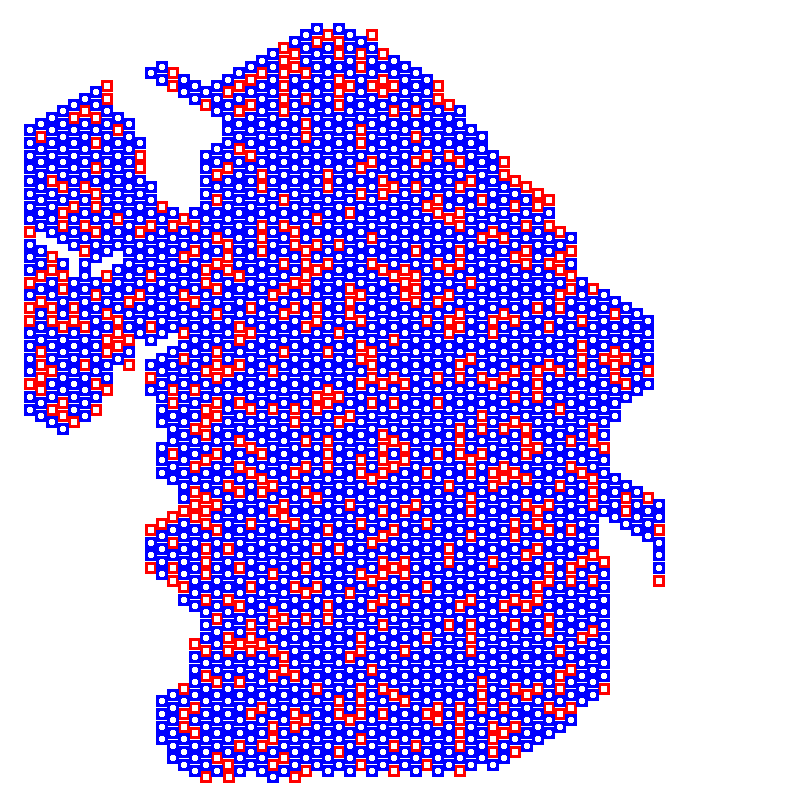

In [75]:
from PIL import Image, ImageDraw

# 1. 打开图片
img = Image.fromarray(np.zeros(
    (adata.uns['spatial']['ST']['images']['downscaled_fullres'].shape[0],
     adata.uns['spatial']['ST']['images']['downscaled_fullres'].shape[1], 3), dtype=np.uint8) + 255)

# 2. 获取画布
draw = ImageDraw.Draw(img)

# 指定圆心和半径
for id in selected_spots_idx[:]:
    
    center_x, center_y = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]*adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef'] # 圆心坐标
    # adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]  # 圆心坐标
    radius = 5.5                    # 半径

    # 计算左上角和右下角坐标
    left_up = (center_x - radius, center_y - radius)
    right_down = (center_x + radius, center_y + radius)

    # 3. 画红色空心圆
    # draw.ellipse([left_up, right_down], outline="red", width=3)
    
    # 4. 画正方形
    draw.rectangle([left_up, right_down], outline="red", width=3)

for id in unselected_spots_idx[:]:
    center_x, center_y = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]*adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef'] # 圆心坐标
    # adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]  # 圆心坐标
    # 计算左上角和右下角坐标
    left_up = (center_x - radius, center_y - radius)
    right_down = (center_x + radius, center_y + radius)
    # 3. 画蓝色实心圆
    draw.ellipse([left_up, right_down], outline="blue", width=3)
    
    # 4. 画正方形
    draw.rectangle([left_up, right_down], outline="blue", width=3)

# 4. 显示或保存
img.crop((70,100,70+800,100+800))

In [ ]:
from PIL import Image, ImageDraw

# 1. 打开图片
img = Image.fromarray(adata.uns['spatial']['ST']['images']['downscaled_fullres'])

# 2. 获取画布
draw = ImageDraw.Draw(img)

# 指定圆心和半径
for id in selected_spots_idx[:]:
    
    center_x, center_y = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]*adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef'] # 圆心坐标
    # adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]  # 圆心坐标
    radius = 5.5                    # 半径

    # 计算左上角和右下角坐标
    left_up = (center_x - radius, center_y - radius)
    right_down = (center_x + radius, center_y + radius)

    # 3. 画红色空心圆
    # draw.ellipse([left_up, right_down], outline="red", width=3)
    
    # 4. 画正方形
    draw.rectangle([left_up, right_down], outline="red", width=3)

for id in unselected_spots_idx[:]:
    center_x, center_y = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]*adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef'] # 圆心坐标
    # adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]  # 圆心坐标
    # 计算左上角和右下角坐标
    left_up = (center_x - radius, center_y - radius)
    right_down = (center_x + radius, center_y + radius)
    # 3. 画蓝色实心圆
    # draw.ellipse([left_up, right_down], outline="blue", width=3)
    
    # 4. 画正方形
    draw.rectangle([left_up, right_down], outline="blue", width=3)



# 显示或保存
x1 = 180
x2 = 100
e1 = 600
e2 = 480
resize_r = 1

img.crop((x1,x2,x1+e1 ,x2+e2 )).resize((e1//resize_r,e2//resize_r))

In [ ]:
(adata.obsm['spatial'] - adata.obsm['spatial'].min(0))[((adata.obsm['spatial'] - adata.obsm['spatial'].min(0)) >1)].min()

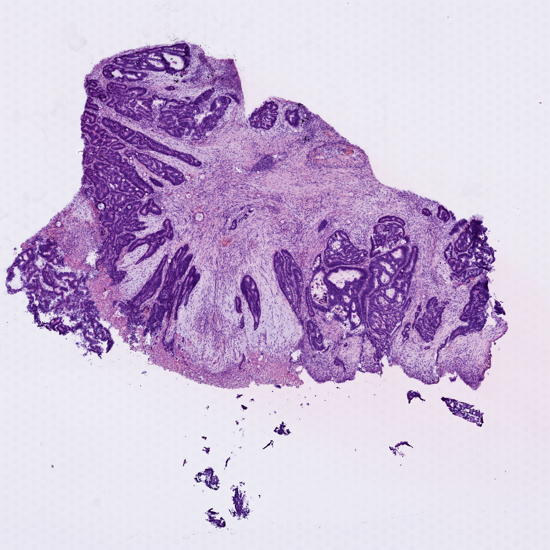

In [97]:
from PIL import Image, ImageDraw
Image.MAX_IMAGE_PIXELS = None
import tifffile

width = 40
radius = 90                    # 半径


# 1. 打开图片
img = Image.fromarray(tifffile.TiffFile("../data/hest/wsis/ZEN44.tif").pages[0].asarray())

# 2. 获取画布
draw = ImageDraw.Draw(img)

# 指定圆心和半径
# for id in selected_spots_idx[:3]:
    
#     center_x, center_y = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]# *#adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef'] # 圆心坐标
#     # adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]  # 圆心坐标
    

#     # 计算左上角和右下角坐标
#     left_up = (center_x - radius, center_y - radius)
#     right_down = (center_x + radius, center_y + radius)

#     # 3. 画红色空心圆
#     # draw.ellipse([left_up, right_down], outline="red", width=width)
    
#     # 4. 画正方形
#     draw.rectangle([left_up, right_down], outline="red", width=width)

# for id in unselected_spots_idx[:5]:
#     center_x, center_y = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]
#     # adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].iloc[id]  # 圆心坐标
#     # 计算左上角和右下角坐标
#     left_up = (center_x - radius, center_y - radius)
#     right_down = (center_x + radius, center_y + radius)
#     # 3. 画蓝色实心圆
#     # draw.ellipse([left_up, right_down], outline="blue", width=width)
    
#     # 4. 画正方形
#     draw.rectangle([left_up, right_down], outline="blue", width=width)



# 4. 显示或保存
# img.crop((70,100,70+800,100+800))
x1 = 3050
x2 = 1500
e1 = 11000
e2 = 11000

img.crop((x1,x2,x1+e1 ,x2+e2 )).resize((e1//20,e2//20))

In [ ]:
# 4. 显示或保存
# img.crop((70,100,70+800,100+800))
x1 = 4000 
x2 = 2000 
e1 = 5000
e2 = 5000
resize_r = 8

img.crop((x1,x2,x1+e1 ,x2+e2 )).resize((e1//resize_r,e2//resize_r))

In [ ]:
# 4. 显示或保存
# img.crop((70,100,70+800,100+800))
x1 = 3000 +25
x2 = 2000 +25
e1 = 10000
e2 = 7000
resize_r = 6

img.crop((x1,x2,x1+e1 ,x2+e2 )).resize((e1//resize_r,e2//resize_r))

In [ ]:
import numpy as np
from PIL import Image

def _np_to_pil(arr):
    # 支持 HxW、HxWx3、HxWx4；float自动映射到0~255
    if arr.dtype.kind == 'f':
        arr = np.clip(arr, 0, 1) * 255
    arr = arr.astype(np.uint8)
    if arr.ndim == 2:
        return Image.fromarray(arr, mode='L').convert('RGB')
    if arr.ndim == 3 and arr.shape[2] in (3, 4):
        img = Image.fromarray(arr[:, :, :3], mode='RGB')
        return img
    raise ValueError("Unsupported array shape.")

def _fit_to_cell(im, cell_size, keep_aspect=True, bg_color=(255, 255, 255)):
    w, h = cell_size
    if keep_aspect:
        im = im.copy()
        im.thumbnail((w, h), Image.Resampling.LANCZOS)
        canvas = Image.new('RGB', (w, h), bg_color)
        off = ((w - im.width) // 2, (h - im.height) // 2)
        canvas.paste(im, off)
        return canvas
    else:
        return im.resize((w, h), Image.Resampling.LANCZOS)

def mosaic_grid(arr_list, rows, cols, cell_size=None, border=2,
                line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=True):
    """
    arr_list: [np.ndarray, ...]
    rows, cols: 网格行列数
    cell_size: (w,h)，不传则取所有图片最大尺寸
    border: 线宽（像素）
    line_color: 分隔线颜色
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    if not cell_size:
        w = max(im.width for im in imgs)
        h = max(im.height for im in imgs)
        cell_size = (w, h)

    # 先把每个图放入等大的 cell
    cells = [_fit_to_cell(im, cell_size, keep_aspect, bg_color) for im in imgs]

    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)  # 背景当作黑色分隔线

    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(cells): break
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cells[idx], (x, y))
            idx += 1
    return out

def mosaic_by_layout(arr_list, layout, cell_size, border=2,
                     line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=False):
    """
    layout: 二维列表，如 [[0,1,2],[None,3,4]]，元素为图片索引或 None（留空）
    cell_size: (w,h)
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    rows, cols = len(layout), len(layout[0])
    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)

    for r in range(rows):
        for c in range(cols):
            idx = layout[r][c]
            if idx is None: 
                continue
            cell = _fit_to_cell(imgs[idx], cell_size, keep_aspect, bg_color)
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cell, (x, y))
    return out

In [ ]:
# 假设有若干 numpy 图片
imgs = [np.random.randint(0,255,(240,240,3),dtype=np.uint8) for _ in range(5)]

# A. 按 2x3 网格顺序摆放，黑线宽 2 像素
out1 = mosaic_grid(imgs, rows=2, cols=3, cell_size=(240,240), border=2)
out1.save("mosaic_grid.jpg")

# B. 自定义布局（第二行左上空一格）
layout = [[0,1,2],
          [None,3,4]]
out2 = mosaic_by_layout(imgs, layout, cell_size=(240,240), border=2)
# out2.save("mosaic_layout.jpg")

## generate image

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['figure.dpi'] = 200  # 默认一般是 100

In [2]:
import zarr
import numpy as np

import os
import scanpy as sc
import pandas as pd

# id = "ZEN48"
# id = "MEND96"
# id = "MEND35"
# id = "TENX13"

id = "MEND90"
keep_gene_m = "expression" # "HVG" 'expression'
n_genes = 250

adata = sc.read_h5ad(f"../data/hest/adata/{id}.h5ad")
print(f'Loaded adata with shape {adata.shape}')
adata.var_names_make_unique()
# adata.obsm['patch_image']  = np.zeros((adata.shape[0], ), dtype=np.uint8)

if keep_gene_m == "expression":
    selected_genes = np.argsort(adata.X.sum(0)).tolist()[::-1][:n_genes]
elif keep_gene_m == "HVG":
    if "highly_variable" in adata.var.columns:
        if adata.var['highly_variable'].sum() == n_genes:
            print("HVG already computed, using existing results.")
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()            
        else:
            sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()
            adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
            print("HVG computed and saved.")
    else:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
        selected_genes = np.where(adata.var.highly_variable)[0].tolist()
        adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
        print("HVG computed and saved.")
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
adata = adata[:, selected_genes]
print(f'Selected {len(selected_genes)} genes using method {keep_gene_m}')

if os.path.exists(f"./{id}_selected_spots_idx.npz"):
    data = np.load(f"./{id}_selected_spots_idx.npz", allow_pickle=True)
    selected_spots_idx = data['selected_spots_idx'].tolist()
    unselected_spots_idx = data['unselected_spots_idx'].tolist()
else:
    selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata.shape[0]), size=int(0.25 * adata.shape[0]), replace=False))]
    unselected_spots_idx = [np.setdiff1d(np.arange(0, adata.shape[0]), selected_spots_idx[0])]
    np.savez(f"./{id}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)

selected_spots_idx = selected_spots_idx[0]
unselected_spots_idx = unselected_spots_idx[0]
    
image_zarr = zarr.open(f"../GEN/patch_image_visium/{id}.zarr/patch_image_norm", mode='r')
print(f'Loaded original image zarr with shape {image_zarr.shape}')

if keep_gene_m == "HVG":
    gen_dir = f"../data/hest/GEN/{id}_image_transform_self_num_film_layers2_HVG/samples.zarr/"
elif keep_gene_m == "expression":
    gen_dir = f"../data/hest/GEN/{id}_image_transform_self_num_film_layers2/samples.zarr/"    
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
image_zarr_gen = zarr.open(f"{gen_dir}/images", mode='r')    
gene_zarr_gen = zarr.open(f"{gen_dir}/gene_expression", mode='r')

print(f'Loaded generated image zarr with shape {image_zarr_gen.shape}')
# for i in selected_spots_idx[:10]:
#     img = Image.fromarray(image_zarr_gen[i][0])
#     display(img)

Loaded adata with shape (2492, 17943)
Selected 250 genes using method expression
Loaded original image zarr with shape (2492, 224, 224, 3)
Loaded generated image zarr with shape (2492, 10, 128, 128, 3)


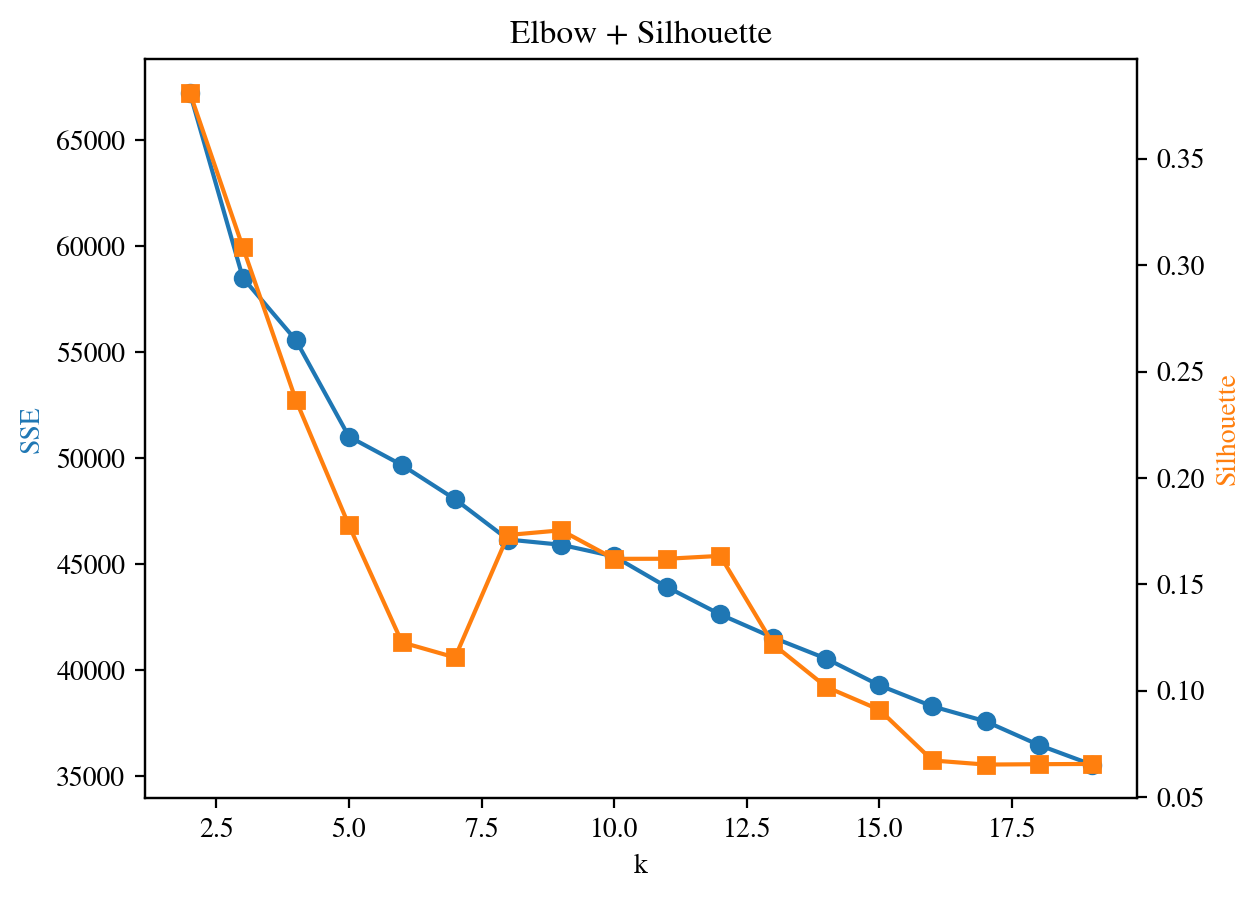

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 标准化
df = pd.DataFrame(gene_zarr_gen[selected_spots_idx,0,:])
X = StandardScaler().fit_transform(df)

# 先降维到 30
X_pca = PCA(n_components=30, random_state=42).fit_transform(X)


def find_k(X, k_range=range(2,20)):
    sse, sil = [], []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42)
        labels = km.fit_predict(X)
        sse.append(km.inertia_)
        sil.append(silhouette_score(X, labels))
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(k_range, sse, 'o-', color='tab:blue', label='SSE')
    ax2.plot(k_range, sil, 's-', color='tab:orange', label='Silhouette')
    ax1.set_xlabel('k')
    ax1.set_ylabel('SSE', color='tab:blue')
    ax2.set_ylabel('Silhouette', color='tab:orange')
    plt.title('Elbow + Silhouette')
    plt.show()
    
find_k(X_pca)

In [ ]:
# if 'Pathologist_Annotations_idx' in adata.obs.columns:
#     labels = adata.obs['Pathologist_Annotations_idx'].values[selected_spots_idx]
#     n_clusters = max(labels) + 1
#     print(adata.obs.iloc[selected_spots_idx,:][['Pathologist_Annotations','Pathologist_Annotations_idx']].value_counts())
# else:
#     n_clusters = 6

#     km = KMeans(n_clusters=n_clusters, random_state=42)
#     labels = km.fit_predict(X_pca)

#     # adata.obs['kmeans'] = labels

#     print(pd.DataFrame(labels).value_counts())
    
# ss = 20
# shift = 0

# selected_class = np.arange(n_clusters)[:-3]
# # selected_class = [1,6]# tumor (1) 与 non neo epithelium (6) 是最典型的对照，代表癌变和正常上皮。 ZEN48,# shift = 1
# # selected_class = [0,1,2,3]# MEND96, n_clusters= 3


# idx2an = {}
# try:
#     for i in adata.obs.iloc[selected_spots_idx]['Pathologist_Annotations_idx'].unique():
#         idx2an[int(i)] = adata.obs.iloc[selected_spots_idx][adata.obs.iloc[selected_spots_idx]['Pathologist_Annotations_idx']==i]['Pathologist_Annotations'].values[0]
#     #idx_ = np.array([[adata.obs.iloc[selected_spots_idx]['Pathologist_Annotations_idx'] == i][shift:ss+shift] for i in selected_class]).flatten()
# except:
#     for i in selected_class:
#         idx2an[int(i)] = f"cluster_{i}"
# print(idx2an)

# assert ss <= min([np.sum(labels==i) for i in selected_class]), f"每个类至少要有 {ss} 个样本"

# idx_raw = [np.array(selected_spots_idx)[labels==i][shift:ss+shift] for i in selected_class]
# idx_sub = np.concat([np.arange(len(selected_spots_idx))[labels==i][shift:ss+shift] for i in selected_class]).flatten()

In [ ]:
# 标准化
df = pd.DataFrame(gene_zarr_gen[selected_spots_idx,0,:])
X = StandardScaler().fit_transform(df)

# 先降维到 30
X_pca = PCA(n_components=30, random_state=42).fit_transform(X)

if keep_gene_m == "HVG":
    id2clusters = {"ZEN48":8,}
elif keep_gene_m == "expression":
    id2clusters = {"MEND96":6, "ZEN48":7, "MEND35":5, "TENX13":5, "MEND40":6,"MEND90":8}
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
n_clusters = id2clusters.get(id, None)


# if n_clusters is None:
#     n_clusters = int(input("请为该数据集指定合适的聚类数："))
#     print(f"你指定的聚类数为 {n_clusters}")

assert n_clusters is not None, "请为该数据集指定合适的聚类数"

km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_pca)

# adata.obs['kmeans'] = labels

print(pd.DataFrame(labels).value_counts())

In [ ]:
ss = 6
shift = 0

if keep_gene_m == "HVG":
    id2seleted_class = {"ZEN48":[0,1,2,4], }    
elif keep_gene_m == "expression":
    id2seleted_class = {"ZEN48":[0,1,2,3], "MEND96":[0,1,2,3], "MEND35":[0,2,3,4], "TENX13":[1,2,3,4], "MEND40":[0,1,2,3,], "MEND90":[1,3,4,6]}
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
selected_class = id2seleted_class.get(id, np.arange(n_clusters).tolist())


idx2an = {}
alphabeta = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J"}
for i in range(len(selected_class)):
    idx2an[int(selected_class[i])] = f"Cluster {alphabeta[i]}"
print(idx2an)

assert selected_class is not None, "selected_class cannot be None"
assert ss <= min([np.sum(labels==i) for i in selected_class]), f"每个类至少要有 {ss} 个样本"

idx_raw = [np.array(selected_spots_idx)[labels==i][shift:ss+shift] for i in selected_class]
idx_sub = np.concatenate([np.arange(len(selected_spots_idx))[labels==i][shift:ss+shift] for i in selected_class]).flatten()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
import numpy as np

def draw_ellipse(points, ax, edgecolor='C0'):
    """根据点的协方差画出95%置信椭圆"""
    cov = np.cov(points.T)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    # 5.991 是卡方分布 2 自由度 95% 分位数
    width, height = 2 * np.sqrt(vals * 5.991)
    mean = points.mean(axis=0)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta,
                      edgecolor=edgecolor, facecolor='none', lw=2)
    ax.add_patch(ellipse)
    
# 假设数据是 df，形状 (n_samples, 250)
# 每一行是一个样本，每一列是一个变量
# 如果你的数据是反过来的（变量在行，样本在列），记得 df = df.T

# 1. 标准化数据（强烈推荐）
df = pd.DataFrame(gene_zarr_gen[selected_spots_idx,0,:])
X = StandardScaler().fit_transform(df)
# X = df.values

# ---------- 1. PCA ----------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,5))
ax = plt.gca()
for i in range(len(selected_class)):
    subset = X_pca[labels == selected_class[i]]
    ax.scatter(subset[:,0], subset[:,1], s=20, alpha=0.7, label=f"{idx2an[selected_class[i]]}")
    draw_ellipse(subset, ax, edgecolor=f"C{i}")
plt.legend()
plt.title("PCA Projection of Gene Expression")
# plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
# plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
# plt.xlabel(f"PC1")
# plt.ylabel(f"PC2")
plt.show()

# ---------- 2. t-SNE ----------
# t-SNE 较慢，建议先 PCA 到 50 维再 t-SNE
X_pca50 = PCA(n_components=50).fit_transform(X)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
X_tsne = tsne.fit_transform(X_pca50)

plt.figure(figsize=(6,5))
ax = plt.gca()
for i in range(len(selected_class)):
    subset = X_tsne[labels == selected_class[i]]
    ax.scatter(subset[:,0], subset[:,1], s=20, alpha=0.7, label=f"{idx2an[selected_class[i]]}")
    draw_ellipse(subset, ax, edgecolor=f"C{i}")
plt.legend()
plt.title("t-SNE Projection of Gene Expression")
plt.show()

# ---------- 3. UMAP ----------
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(6,5))
ax = plt.gca()
for i in range(len(selected_class)):
    subset = X_umap[labels == selected_class[i]]
    ax.scatter(subset[:,0], subset[:,1], s=20, alpha=0.7, label=f"{idx2an[selected_class[i]]}")
    draw_ellipse(subset, ax, edgecolor=f"C{i}")
plt.legend()
plt.title("UMAP Projection of Gene Expression")
plt.show()


In [ ]:
adata_ = adata[selected_spots_idx,:].copy()
adata_.obs['Cluster'] = labels.astype(str)  # 如果你的列名不是 "cluster"，改这里
adata_ = adata_[adata_.obs['Cluster'].isin([str(x) for x in selected_class]), :]
adata_.obs['Cluster'] = [idx2an[i] for i in adata_.obs['Cluster'].astype(int).tolist()]  # 映射为注释名称

In [ ]:
import scanpy as sc
import seaborn as sns
import pandas as pd  # ★ 新增

# （可选，但推荐）把 view 转成 copy，避免 ImplicitModificationWarning
adata_ = adata_.copy()  # ★ 新增（若内存紧张可删掉）

# 确保分组列为分类类型
if adata_.obs["Cluster"].dtype.name != "category":  # ★ 新增（稳妥）
    adata_.obs["Cluster"] = adata_.obs["Cluster"].astype("category")

sc.tl.rank_genes_groups(
    adata_, groupby="Cluster",
    method="wilcoxon", use_raw=False, corr_method="benjamini-hochberg"
)

# 收集每个 cluster 的 top 基因（按 p 值 + logFC）
result = adata_.uns['rank_genes_groups']
groups = result['names'].dtype.names

topk = 5
p_cut = 0.05
lfc_cut = 0.25

selected = set()
for g in groups:
    names = pd.Series(result['names'][g])
    pvals = pd.Series(result['pvals_adj'][g]) if 'pvals_adj' in result else pd.Series(result['pvals'][g])
    lfc   = pd.Series(result['logfoldchanges'][g])
    hits  = names[(pvals < p_cut) & (lfc.abs() >= lfc_cut)].head(topk).tolist()
    selected.update(hits)

gs_filtered = sorted(set(selected))
print("显著差异基因（汇总）：", gs_filtered)

# 关键修复：先计算 dendrogram，并把 n_pcs 设为合法上限
n_pcs_safe = min(adata_.n_obs, adata_.n_vars, 4)  # ★ 新增：4 已足够且避免 50 超界
sc.tl.dendrogram(adata_, groupby="Cluster", n_pcs=n_pcs_safe, use_rep="X")  # ★ 新增

sc.pl.heatmap(
    adata_, var_names=gs_filtered, groupby="Cluster",
    cmap="vlag",
    swap_axes=True, dendrogram=True, use_raw=False
)

In [ ]:
fig_dict = sc.pl.heatmap(
    adata_,
    var_names=gs_filtered,
    groupby="Cluster",
    cmap="coolwarm",
    swap_axes=True,
    dendrogram=True,
    use_raw=False,
    figsize=(8, 5),
    # standard_scale='var',
    show=False,
)
ax_heat = fig_dict["heatmap_ax"]
ax_grp  = fig_dict.get("groupby_ax", None)   # 底部显示 Cluster 标签的轴

# 不显示 xlabel，且让标签保持水平
if ax_grp is not None:
    ax_grp.set_xlabel(None)
    for lab in ax_grp.get_xticklabels():
        lab.set_rotation(20)          # 保持水平
        lab.set_ha('center')
        lab.set_va('top')

ax_heat.set_ylabel("Genes", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from PIL import Image

def _np_to_pil(arr):
    # 支持 HxW、HxWx3、HxWx4；float自动映射到0~255
    if arr.dtype.kind == 'f':
        arr = np.clip(arr, 0, 1) * 255
    arr = arr.astype(np.uint8)
    if arr.ndim == 2:
        return Image.fromarray(arr, mode='L').convert('RGB')
    if arr.ndim == 3 and arr.shape[2] in (3, 4):
        img = Image.fromarray(arr[:, :, :3], mode='RGB')
        return img
    raise ValueError("Unsupported array shape.")

def _fit_to_cell(im, cell_size, keep_aspect=True, bg_color=(255, 255, 255)):
    w, h = cell_size
    if keep_aspect:
        im = im.copy()
        im.thumbnail((w, h), Image.Resampling.LANCZOS)
        canvas = Image.new('RGB', (w, h), bg_color)
        off = ((w - im.width) // 2, (h - im.height) // 2)
        canvas.paste(im, off)
        return canvas
    else:
        return im.resize((w, h), Image.Resampling.LANCZOS)

def mosaic_grid(arr_list, rows, cols, cell_size=None, border=2,
                line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=True):
    """
    arr_list: [np.ndarray, ...]
    rows, cols: 网格行列数
    cell_size: (w,h)，不传则取所有图片最大尺寸
    border: 线宽（像素）
    line_color: 分隔线颜色
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    if not cell_size:
        w = max(im.width for im in imgs)
        h = max(im.height for im in imgs)
        cell_size = (w, h)

    # 先把每个图放入等大的 cell
    cells = [_fit_to_cell(im, cell_size, keep_aspect, bg_color) for im in imgs]

    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)  # 背景当作黑色分隔线

    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(cells): break
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cells[idx], (x, y))
            idx += 1
    return out

def mosaic_by_layout(arr_list, layout, cell_size, border=2,
                     line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=False):
    """
    layout: 二维列表，如 [[0,1,2],[None,3,4]]，元素为图片索引或 None（留空）
    cell_size: (w,h)
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    rows, cols = len(layout), len(layout[0])
    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)

    for r in range(rows):
        for c in range(cols):
            idx = layout[r][c]
            if idx is None: 
                continue
            cell = _fit_to_cell(imgs[idx], cell_size, keep_aspect, bg_color)
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cell, (x, y))
    return out

In [ ]:
gene_zarr_gen[idx_raw[0]][0][0][0],gene_zarr_gen[idx_raw[0]][0][1][0]

In [ ]:
for c in range(len(selected_class)):
    print(f"Class {selected_class[c]} ({idx2an[selected_class[c]]}):")
    draw_idx_raw = idx_raw[c][:6]
    imgs = [image_zarr[i] for i in draw_idx_raw]
    display(mosaic_grid(imgs, rows=1, cols=len(draw_idx_raw), cell_size=(128,128), border=2))
    
    imgs = [image_zarr_gen[i][_] for _ in range(1) for i in draw_idx_raw]
    display(mosaic_grid(imgs, rows=1, cols=len(draw_idx_raw), cell_size=(128,128), border=2))

In [ ]:
raise "Stop here"

## EMB

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# ====== 设置全局字体 ======
plt.rcParams['font.family'] = 'STIXGeneral'  # Matplotlib 自带字体
plt.rcParams['font.size'] = 16                 # 全局字号
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题（特别是中文字体时）

In [ ]:
import numpy as np
from PIL import Image

def _np_to_pil(arr):
    # 支持 HxW、HxWx3、HxWx4；float自动映射到0~255
    if arr.dtype.kind == 'f':
        arr = np.clip(arr, 0, 1) * 255
    arr = arr.astype(np.uint8)
    if arr.ndim == 2:
        return Image.fromarray(arr, mode='L').convert('RGB')
    if arr.ndim == 3 and arr.shape[2] in (3, 4):
        img = Image.fromarray(arr[:, :, :3], mode='RGB')
        return img
    raise ValueError("Unsupported array shape.")

def _fit_to_cell(im, cell_size, keep_aspect=True, bg_color=(255, 255, 255)):
    w, h = cell_size
    if keep_aspect:
        im = im.copy()
        im.thumbnail((w, h), Image.Resampling.LANCZOS)
        canvas = Image.new('RGB', (w, h), bg_color)
        off = ((w - im.width) // 2, (h - im.height) // 2)
        canvas.paste(im, off)
        return canvas
    else:
        return im.resize((w, h), Image.Resampling.LANCZOS)

def mosaic_grid(arr_list, rows, cols, cell_size=None, border=2,
                line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=True):
    """
    arr_list: [np.ndarray, ...]
    rows, cols: 网格行列数
    cell_size: (w,h)，不传则取所有图片最大尺寸
    border: 线宽（像素）
    line_color: 分隔线颜色
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    if not cell_size:
        w = max(im.width for im in imgs)
        h = max(im.height for im in imgs)
        cell_size = (w, h)

    # 先把每个图放入等大的 cell
    cells = [_fit_to_cell(im, cell_size, keep_aspect, bg_color) for im in imgs]

    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)  # 背景当作黑色分隔线

    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(cells): break
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cells[idx], (x, y))
            idx += 1
    return out

def mosaic_by_layout(arr_list, layout, cell_size, border=2,
                     line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=False):
    """
    layout: 二维列表，如 [[0,1,2],[None,3,4]]，元素为图片索引或 None（留空）
    cell_size: (w,h)
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    rows, cols = len(layout), len(layout[0])
    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)

    for r in range(rows):
        for c in range(cols):
            idx = layout[r][c]
            if idx is None: 
                continue
            cell = _fit_to_cell(imgs[idx], cell_size, keep_aspect, bg_color)
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cell, (x, y))
    return out

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import numpy as np

device = "cuda:3"

from conch.open_clip_custom import create_model_from_pretrained
conch, preprocess = create_model_from_pretrained('conch_ViT-B-16', "hf_hub:MahmoodLab/conch", hf_auth_token="xxx")
conch = conch.to(device)


import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login

login("xxx")  # login with your User Access Token, found at https://huggingface.co/settings/tokens

# pretrained=True needed to load UNI2-h weights (and download weights for the first time)
timm_kwargs = {
            'img_size': 224, 
            'patch_size': 14, 
            'depth': 24,
            'num_heads': 24,
            'init_values': 1e-5, 
            'embed_dim': 1536,
            'mlp_ratio': 2.66667*2,
            'num_classes': 0, 
            'no_embed_class': True,
            'mlp_layer': timm.layers.SwiGLUPacked, 
            'act_layer': torch.nn.SiLU, 
            'reg_tokens': 8, 
            'dynamic_img_size': True
        }
uni = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
transform = create_transform(**resolve_data_config(uni.pretrained_cfg, model=uni))


import torch
import timm 
from torchvision import transforms
import scanpy as sc
from PIL import Image
from huggingface_hub import login

login("xxx")
h0 = timm.create_model("hf_hub:bioptimus/H-optimus-0", pretrained=True)

h0_t = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.707223, 0.578729, 0.703617), 
        std=(0.211883, 0.230117, 0.177517)
    ),
])

class ImageDataset(Dataset):
    def __init__(self, img_zarr, transform=None):
        self.img_zarr = img_zarr
        self.transform = transform

    def __len__(self):
        return self.img_zarr.shape[0]

    def __getitem__(self, idx):
        img = Image.fromarray(self.img_zarr[idx])
        if img.size[1] != 128:
            img = img.resize((128,128))
        return self.transform(img)

def get_emb(model,model_out_dim,data,transform,batch_size = 64,device = "cuda:0"):
    model = model.to(device)
    patch_emb = np.zeros((data.shape[0], model_out_dim))
    image_dataset = ImageDataset(data, transform=transform)
    image_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    for i, batch in enumerate(image_loader):
        print(f"Processing {i+1}/{len(image_loader)}", end="\r")
        batch = batch.to(device)
        with torch.no_grad():
            with torch.inference_mode():
                try:
                    image_embs = model.encode_image(batch, proj_contrast=False, normalize=False)  # scale to match gene expression range
                except:
                    image_embs = model(batch)
            patch_emb[i * batch_size:(i + 1) * batch_size] = image_embs.squeeze().detach().cpu().numpy()
    return patch_emb

In [ ]:
import zarr
import numpy as np
import os
import scanpy as sc
import pandas as pd

# id = "ZEN48" # Bowel cancer
# id = "MEND40" #Skin 
# id = "MEND90"# Lung Health
# id = "TENX13"# Breast Cancer

id = "ZEN48"
keep_gene_m = "expression" # "HVG" 'expression'
n_genes = 250

adata = sc.read_h5ad(f"../data/hest/adata/{id}.h5ad")
print(f'Loaded adata with shape {adata.shape}')
adata.var_names_make_unique()
# adata.obsm['patch_image']  = np.zeros((adata.shape[0], ), dtype=np.uint8)

if keep_gene_m == "expression":
    selected_genes = np.argsort(adata.X.sum(0)).tolist()[::-1][:n_genes]
elif keep_gene_m == "HVG":
    if "highly_variable" in adata.var.columns:
        if adata.var['highly_variable'].sum() == n_genes:
            print("HVG already computed, using existing results.")
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()            
        else:
            sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()
            adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
            print("HVG computed and saved.")
    else:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
        selected_genes = np.where(adata.var.highly_variable)[0].tolist()
        adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
        print("HVG computed and saved.")
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
adata = adata[:, selected_genes]
print(f'Selected {len(selected_genes)} genes using method {keep_gene_m}')

if os.path.exists(f"./{id}_selected_spots_idx.npz"):
    data = np.load(f"./{id}_selected_spots_idx.npz", allow_pickle=True)
    selected_spots_idx = data['selected_spots_idx'].tolist()
    unselected_spots_idx = data['unselected_spots_idx'].tolist()
else:
    selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata.shape[0]), size=int(0.25 * adata.shape[0]), replace=False))]
    unselected_spots_idx = [np.setdiff1d(np.arange(0, adata.shape[0]), selected_spots_idx[0])]
    np.savez(f"./{id}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)

selected_spots_idx = selected_spots_idx[0]
unselected_spots_idx = unselected_spots_idx[0]
    
image_zarr = zarr.open(f"../GEN/patch_image_visium/{id}.zarr/patch_image_norm", mode='r')
print(f'Loaded original image zarr with shape {image_zarr.shape}')

if keep_gene_m == "HVG":
    gen_dir = f"../data/hest/GEN/{id}_image_transform_self_num_film_layers2_HVG/samples.zarr/"
elif keep_gene_m == "expression":
    gen_dir = f"../data/hest/GEN/{id}_image_transform_self_num_film_layers2/samples.zarr/"    
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
image_zarr_gen = zarr.open(f"{gen_dir}/images", mode='r')    
gene_zarr_gen = zarr.open(f"{gen_dir}/gene_expression", mode='r')

print(f'Loaded generated image zarr with shape {image_zarr_gen.shape}')
# for i in selected_spots_idx[:10]:
#     img = Image.fromarray(image_zarr_gen[i][0])
#     display(img)

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # 标准化
# df = pd.DataFrame(gene_zarr_gen[selected_spots_idx,0,:])
# X = StandardScaler().fit_transform(df)

# # 先降维到 30
# X_pca = PCA(n_components=30, random_state=42).fit_transform(X)


# def find_k(X, k_range=range(2,20)):
#     sse, sil = [], []
#     for k in k_range:
#         km = KMeans(n_clusters=k, random_state=42)
#         labels = km.fit_predict(X)
#         sse.append(km.inertia_)
#         sil.append(silhouette_score(X, labels))
#     fig, ax1 = plt.subplots()
#     ax2 = ax1.twinx()
#     ax1.plot(k_range, sse, 'o-', color='tab:blue', label='SSE')
#     ax2.plot(k_range, sil, 's-', color='tab:orange', label='Silhouette')
#     ax1.set_xlabel('k')
#     ax1.set_ylabel('SSE', color='tab:blue')
#     ax2.set_ylabel('Silhouette', color='tab:orange')
#     plt.title('Elbow + Silhouette')
#     plt.show()
    
# find_k(X_pca)

In [ ]:
# 标准化
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

df = pd.DataFrame(gene_zarr_gen[selected_spots_idx,0,:])
X = StandardScaler().fit_transform(df)

# 先降维到 30
X_pca = PCA(n_components=30, random_state=42).fit_transform(X)

if keep_gene_m == "HVG":
    id2clusters = {"ZEN48":8,}
elif keep_gene_m == "expression":
    id2clusters = {"MEND96":6, "ZEN48":7, "MEND35":5, "TENX13":5,'MEND40':6,'MEND52':5,"MEND90":8}
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
n_clusters = id2clusters.get(id, None)


# if n_clusters is None:
#     n_clusters = int(input("请为该数据集指定合适的聚类数："))
#     print(f"你指定的聚类数为 {n_clusters}")

assert n_clusters is not None, "请为该数据集指定合适的聚类数"

km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_pca)

# adata.obs['kmeans'] = labels

print(pd.DataFrame(labels).value_counts())

In [ ]:
if keep_gene_m == "HVG":
    id2seleted_class = {"ZEN48":[0,1,2,4], }    
elif keep_gene_m == "expression":
    id2seleted_class = {"ZEN48":[0,1,2,3], "MEND96":[0,1,2,3], "MEND35":[0,2,3,4], "TENX13":[1,2,3,4], "MEND40":[0,1,2,3,], "MEND90":[1,3,4,6]}
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
selected_class = id2seleted_class.get(id, np.arange(n_clusters).tolist())


idx2an = {}
alphabeta = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J"}
for i in range(len(selected_class)):
    idx2an[int(selected_class[i])] = f"cluster_{alphabeta[i]}"
print(idx2an)

assert selected_class is not None, "selected_class cannot be None"

In [ ]:
patch_embs, patch_embs_gen = {}, {}
batch_size = 128

for model_name in ["conch"]: # ["conch", "uni", "h0"]:
    print(f"Processing model: {model_name}")
    model_ = {"conch": conch, "uni": uni, "h0": h0}[model_name]
    dim_ = {"conch": 512, "uni": 1536, "h0": 1536}[model_name]
    transform_ = {"conch": preprocess, "uni": transform, "h0": h0_t}[model_name]
    if not os.path.exists(f"../GEN/patch_image_visium/{id}.zarr/patch_emb_{model_name}/"):
        patch_emb = get_emb(model_, dim_, image_zarr, transform_, batch_size=batch_size, device=device)
        import zarr
        import numpy as np

        # 打开 samples.zarr 根路径
        root = zarr.open(
            f"../GEN/patch_image_visium/{id}.zarr/",
            mode='a'  # 用 'a' 打开以便读写
        )

        # 获取 images 数组的行数
        images = root["patch_image"]
        n_rows = images.shape[0]

        # 创建新数组 'patch_emb_conch'，形状 [n_rows, 512]
        # dtype 可按需调整，比如 float32
        root.create_dataset(
            f"patch_emb_{model_name}",
            shape=(n_rows, dim_),  # Use dim_ for dynamic shape
            chunks=(1, dim_),  # Use dim_ for dynamic chunk size
            dtype="float32",
            overwrite=True  # 若已存在则覆盖
        )

        root[f"patch_emb_{model_name}"][:] = patch_emb
        patch_emb = root[f"patch_emb_{model_name}"][:]
        patch_embs[model_name] = patch_emb
        print(f"✅ patch_emb_{model_name} 创建完成:", root[f"patch_emb_{model_name}"].shape)
        # patch_emb_conch = get_emb(conch,512,image_zarr,preprocess,batch_size = batch_size,device = device)
        # patch_emb_uni = get_emb(uni,1536,image_zarr,transform,batch_size = batch_size,device = device)
        # patch_emb_h0 = get_emb(h0,1536,image_zarr,h0_t,batch_size = batch_size,device = device)
    else:
        patch_emb = zarr.open(f"../GEN/patch_image_visium/{id}.zarr/patch_emb_{model_name}", mode='r')[:]
        patch_embs[model_name] = patch_emb
        print(f'Loaded original patch_emb_{model_name} with shape {patch_emb.shape}')
        
    if not os.path.exists(gen_dir + f"/patch_emb_{model_name}_gen/"):
        patch_emb_conch_gen_ = [get_emb(model_,dim_,image_zarr_gen[selected_spots_idx][:,i],transform_,batch_size = batch_size,device = device) for i in range(10)]
        # 打开 samples.zarr 根路径
        root = zarr.open(
            gen_dir,
            mode='a'  # 用 'a' 打开以便读写
        )
        # 获取 images 数组的行数
        images = root["images"]
        n_rows = images.shape[0]

        # 创建新数组 'patch_emb_conch_gen'，形状 [n_rows, 10,512]
        # dtype 可按需调整，比如 float32
        root.create_dataset(
            f"patch_emb_{model_name}_gen",
            shape=(n_rows, 10, dim_),  # Use dim_ for dynamic shape
            chunks=(1, 10, dim_),  # Use dim_ for dynamic chunk size
            dtype="float32",
            overwrite=True  # 若已存在则覆盖
        )

        root[f"patch_emb_{model_name}_gen"][selected_spots_idx] = np.array(patch_emb_conch_gen_).transpose(1, 0, 2)
        patch_emb_gen = root[f"patch_emb_{model_name}_gen"][:]
        patch_embs_gen[model_name] = patch_emb_gen
        print("✅ patch_emb_gen 创建完成:", root[f"patch_emb_{model_name}_gen"].shape)    
        # patch_emb_conch_gen = [get_emb(conch,512,image_zarr_gen[:,i],preprocess,batch_size = batch_size,device = device) for i in range(image_zarr_gen.shape[1])]
        # patch_emb_uni_gen = [get_emb(uni,1536,image_zarr_gen[:,i],transform,batch_size = batch_size,device = device) for i in range(image_zarr_gen.shape[1])]
        # patch_emb_h0_gen = [get_emb(h0,1536,image_zarr_gen[:,i],h0_t,batch_size = batch_size,device = device) for i in range(image_zarr_gen.shape[1])]
    else:
        patch_emb_gen = zarr.open(f"{gen_dir}/patch_emb_{model_name}_gen", mode='r')[:]
        patch_embs_gen[model_name] = patch_emb_gen
        print(f'Loaded generated patch_emb_gen with shape {patch_emb_gen.shape}')

#### cos sim

In [ ]:
patch_emb = patch_embs["conch"]
patch_emb_gen = patch_embs_gen["conch"]

emb1 = patch_emb[selected_spots_idx]
emb2 = patch_emb_gen[selected_spots_idx].transpose(1, 0, 2).reshape(-1, patch_emb_gen.shape[-1])

from sklearn.metrics.pairwise import cosine_similarity

emb1_ = emb1 / np.linalg.norm(emb1, axis=1, keepdims=True)
emb2_ = emb2 / np.linalg.norm(emb2, axis=1, keepdims=True)

cos_sim = np.zeros((emb1_.shape[0], emb2_.shape[0] // emb1.shape[0]))
for i in range(emb1_.shape[0]):
    for j in range(emb2_.shape[0] // emb1.shape[0]):
        cos_sim[i, j] = cosine_similarity(emb1_[i:i+1], emb2_[j*emb1.shape[0] + i :j*emb1.shape[0] +(i+1), :])[0][0]
    
print(cos_sim)

In [ ]:
cos_sim.mean(),cos_sim.std()

In [ ]:
raise "stop"

In [ ]:
# coords = np.array(np.where(cos_sim > 0.9)).T

# css = []
# for c in selected_class:
#     idx__ = np.where(labels == c)[0]
#     cs = []
#     for i in idx__:
#         tem = coords[coords[:,0] == i]
#         if tem.shape[0] > 0:
#             cs.append(tem[0])
#     css.append(np.array(cs))

In [ ]:
# n_smaple = 6
# print(f"每类随机选 {n_smaple} 个 spot 展示")
# for c in range(len(selected_class)):
#     print(f"Class {selected_class[c]} ({idx2an[selected_class[c]]}):")
#     real_s = [image_zarr[selected_spots_idx[css[c][x,0]]] for x in range(n_smaple)]
#     display(mosaic_grid(real_s, rows=1, cols=n_smaple, cell_size=(128,128), border=2))
#     print(f"Class {selected_class[c]} ({idx2an[selected_class[c]]}) Generated:")
#     gen_s = [image_zarr_gen[selected_spots_idx[css[c][x, 0]]][css[c][x, 1]] for x in range(n_smaple)]
#     display(mosaic_grid(gen_s, rows=1, cols=n_smaple, cell_size=(128,128), border=2))

### emb plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

try:
    import umap  # pip install umap-learn
except ImportError:
    raise ImportError("请先安装 umap-learn：pip install umap-learn")

def plot_coords(coords_a, coords_b, title, labels=('Real Image', 'Synthetic Image')):
    plt.figure(figsize=(7,7),dpi=100)
    plt.scatter(coords_b[:, 0], coords_b[:, 1], s=15, alpha=0.8, label=labels[1])
    plt.scatter(coords_a[:, 0], coords_a[:, 1], s=15, alpha=0.8, label=labels[0])
    plt.xlabel(f'{title} 1')
    plt.ylabel(f'{title} 2')
    # plt.title(f'{title} Projection')
    plt.legend(loc = "lower left", fontsize=12)
    plt.tight_layout()
    plt.show()


for model_name in ["conch"]:
    print(f"Processing model: {model_name}")
    patch_emb = patch_embs[model_name]
    patch_emb_gen = patch_embs_gen[model_name]


    emb1 = patch_emb[selected_spots_idx]
    emb2 = patch_emb_gen[selected_spots_idx].transpose(1, 0, 2).reshape(-1, patch_emb_gen.shape[-1])

    # ---------- 1. 拼接并做 L2 归一化 ----------
    combined = np.concatenate([emb1, emb2], axis=0) 
    norms = np.linalg.norm(combined, axis=1, keepdims=True)
    combined_norm = combined / np.maximum(norms, 1e-12)  # 防止除 0
    # combined_norm = StandardScaler().fit_transform(combined)  # 标准化

    n = emb1.shape[0]
    emb_a = combined_norm[:n]
    emb_b = combined_norm[n:]

    # # ---------- 2. PCA ----------
    # pca = PCA(n_components=2, random_state=0)
    # pca_proj = pca.fit_transform(combined_norm)
    # plot_coords(pca_proj[:n], pca_proj[n:], 'PCA')

    # # ---------- 3. UMAP ----------
    # umap_model = umap.UMAP(n_components=2, random_state=42)
    # umap_proj = umap_model.fit_transform(combined_norm)
    # plot_coords(umap_proj[:n], umap_proj[n:], 'UMAP')

    # ---------- 4. t-SNE ----------
    tsne_model = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                    init='pca', random_state=42)
    tsne_proj = tsne_model.fit_transform(combined_norm)
    plot_coords(tsne_proj[:n], tsne_proj[n:], 't-SNE')

In [ ]:
raise "Stop here"

In [ ]:
# emb1 = np.vstack([i for i in patch_emb_conch_gen])
# emb2 = patch_emb_conch[selected_spots_idx1]
# emb3 = patch_emb_conch[unselected_spots_idx]

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

# try:
#     import umap  # pip install umap-learn
# except ImportError:
#     raise ImportError("请先安装 umap-learn：pip install umap-learn")

# # ---------- 1. 拼接并做 L2 归一化 ----------
# combined = np.concatenate([emb1, emb2, emb3], axis=0) 
# norms = np.linalg.norm(combined, axis=1, keepdims=True)
# combined_norm = combined / np.maximum(norms, 1e-12)  # 防止除 0
# # combined_norm = StandardScaler().fit_transform(combined)  # 标准化

# n = emb1.shape[0]
# m = emb2.shape[0]

# def plot_coords(coords_a, coords_b, coords_c, title, labels=('patch_emb_gen','patch_emb_sampled', 'patch_emb_unsampled')):
#     plt.figure(figsize=(6, 6))
#     plt.scatter(coords_a[:, 0], coords_a[:, 1], s=12, alpha=0.8, label=labels[0])
#     plt.scatter(coords_b[:, 0], coords_b[:, 1], s=12, alpha=0.8, label=labels[1])
#     plt.scatter(coords_c[:, 0], coords_c[:, 1], s=12, alpha=0.8, label=labels[2])
#     plt.xlabel(f'{title} 1')
#     plt.ylabel(f'{title} 2')
#     plt.title(f'{title} Projection')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # ---------- 2. PCA ----------
# pca = PCA(n_components=2, random_state=0)
# pca_proj = pca.fit_transform(combined_norm)
# plot_coords(pca_proj[:n], pca_proj[n:n+m], pca_proj[n+m:], 'PCA')

# # ---------- 3. UMAP ----------
# umap_model = umap.UMAP(n_components=2, random_state=42)
# umap_proj = umap_model.fit_transform(combined_norm)
# plot_coords(umap_proj[:n], umap_proj[n:n+m], umap_proj[n+m:], 'UMAP')

# # ---------- 4. t-SNE ----------
# tsne_model = TSNE(n_components=2, perplexity=30, learning_rate='auto',
#                   init='pca', random_state=42)
# tsne_proj = tsne_model.fit_transform(combined_norm)
# plot_coords(tsne_proj[:n], tsne_proj[n:n+m], tsne_proj[n+m:], 't-SNE')

In [ ]:
raise "Stop here"

## segment

In [ ]:
import zarr
import numpy as np
import os
import scanpy as sc
import pandas as pd

# id = "ZEN48"
# id = "MEND90"
# id = "MEND40"
# id = "TENX13"

id = "MEND90"
keep_gene_m = "expression" # "HVG" 'expression'
n_genes = 250

adata = sc.read_h5ad(f"../data/hest/adata/{id}.h5ad")
print(f'Loaded adata with shape {adata.shape}')
adata.var_names_make_unique()
# adata.obsm['patch_image']  = np.zeros((adata.shape[0], ), dtype=np.uint8)

if keep_gene_m == "expression":
    selected_genes = np.argsort(adata.X.sum(0)).tolist()[::-1][:n_genes]
elif keep_gene_m == "HVG":
    if "highly_variable" in adata.var.columns:
        if adata.var['highly_variable'].sum() == n_genes:
            print("HVG already computed, using existing results.")
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()            
        else:
            sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()
            adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
            print("HVG computed and saved.")
    else:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
        selected_genes = np.where(adata.var.highly_variable)[0].tolist()
        adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
        print("HVG computed and saved.")
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
adata = adata[:, selected_genes]
print(f'Selected {len(selected_genes)} genes using method {keep_gene_m}')

if os.path.exists(f"./{id}_selected_spots_idx.npz"):
    data = np.load(f"./{id}_selected_spots_idx.npz", allow_pickle=True)
    selected_spots_idx = data['selected_spots_idx'].tolist()
    unselected_spots_idx = data['unselected_spots_idx'].tolist()
else:
    selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata.shape[0]), size=int(0.25 * adata.shape[0]), replace=False))]
    unselected_spots_idx = [np.setdiff1d(np.arange(0, adata.shape[0]), selected_spots_idx[0])]
    np.savez(f"./{id}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)

selected_spots_idx = selected_spots_idx[0]
unselected_spots_idx = unselected_spots_idx[0]
    
image_zarr = zarr.open(f"../GEN/patch_image_visium/{id}.zarr/patch_image_norm", mode='r')
print(f'Loaded original image zarr with shape {image_zarr.shape}')

if keep_gene_m == "HVG":
    gen_dir = f"../data/hest/GEN/{id}_image_transform_self_num_film_layers2_HVG/samples.zarr/"
elif keep_gene_m == "expression":
    gen_dir = f"../data/hest/GEN/{id}_image_transform_self_num_film_layers2/samples.zarr/"    
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
image_zarr_gen = zarr.open(f"{gen_dir}/images", mode='r')    
gene_zarr_gen = zarr.open(f"{gen_dir}/gene_expression", mode='r')

print(f'Loaded generated image zarr with shape {image_zarr_gen.shape}')
# for i in selected_spots_idx[:10]:
#     img = Image.fromarray(image_zarr_gen[i][0])
#     display(img)

In [ ]:
"""Import modules required to run the Jupyter notebook."""

# Clear logger to use tiatoolbox.logger
import logging
import warnings

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

import cv2
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from tiatoolbox import logger
from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor
from tiatoolbox.utils.misc import download_data, imread

# We need this function to visualize the nuclear predictions
from tiatoolbox.utils.visualization import (
    overlay_prediction_contours,
)
from tiatoolbox.wsicore.wsireader import WSIReader

warnings.filterwarnings("ignore")
mpl.rcParams["figure.dpi"] = 50  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode
plt.rcParams.update({"font.size": 5})

In [ ]:
# These file name are used for the experimenets
img_file_name = "sample_tile.png"
wsi_file_name = "sample_wsi.svs"


logger.info("Download has started. Please wait...")

# Downloading sample image tile
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/breast_tissue_crop.png",
    img_file_name,
)

# Downloading sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/wsi4_12k_12k.svs",
    wsi_file_name,
)

logger.info("Download is complete.")

In [ ]:
from PIL import Image

image_save_dir = f"./image_save/{id}_{keep_gene_m}"
os.makedirs(f"{image_save_dir}/real", exist_ok=True)
os.makedirs(f"{image_save_dir}/gen", exist_ok=True)

img_real_files = []
img_gen_files = []
for i in selected_spots_idx:
    print(f"Processing image {i}/{max(selected_spots_idx)}", end="\r")
    if not os.path.exists(f"{image_save_dir}/real/{i}.png"):
        img_real = Image.fromarray(image_zarr[i])
        img_real_resized = img_real.resize((128, 128), Image.BILINEAR).resize((256, 256), Image.BICUBIC)
        img_real_resized.save(f"{image_save_dir}/real/{i}.png")
    img_real_files.append(f"{image_save_dir}/real/{i}.png")
    for _ in range(image_zarr_gen.shape[1]):
        if not os.path.exists(f"{image_save_dir}/gen/{i}_{_}.png"):
            img_gen = Image.fromarray(image_zarr_gen[i][_])
            img_gen_resized = img_gen.resize((256, 256), Image.BICUBIC)
            img_gen_resized.save(f"{image_save_dir}/gen/{i}_{_}.png")
        img_gen_files.append(f"{image_save_dir}/gen/{i}_{_}.png")


In [ ]:
raise "Stop here"

In [ ]:
import tifffile
img = image_zarr[0]
tifffile.imwrite("output.tiff", img)

## mark#

In [ ]:
pretrained_model = "hovernet_fast-pannuke" # "hovernet_fast-pannuke" "hovernet_original-consep"
device = "cuda:0"  # "cpu" or "cuda:0", "cuda:1", etc.

In [ ]:
# Tile prediction
inst_segmentor = NucleusInstanceSegmentor(
    pretrained_model=pretrained_model,
    # pretrained_model="hovernet_original-consep",
    num_loader_workers=4,
    num_postproc_workers=4,
    batch_size=128,
)

tile_output = inst_segmentor.predict(
    img_real_files,
    save_dir=f"sample_tile_results/{id}_{keep_gene_m}_{pretrained_model}/real",
    mode="tile",
    device=device,
    crash_on_exception=True,
)


In [ ]:
# Tile prediction
inst_segmentor = NucleusInstanceSegmentor(
    pretrained_model=pretrained_model,
    num_loader_workers=4,
    num_postproc_workers=4,
    batch_size=128,
)

tile_output_gen = inst_segmentor.predict(
    img_gen_files,
    save_dir=f"sample_tile_results//{id}_{keep_gene_m}_{pretrained_model}/gen",
    mode="tile",
    device=device,
    crash_on_exception=True,
)

###  plt

In [ ]:
pretrained_model = "hovernet_fast-pannuke" # "hovernet_fast-pannuke" "hovernet_original-consep"
device = "cuda:0"  # "cpu" or "cuda:0", "cuda:1", etc.

In [ ]:
real_count = np.zeros((len(selected_spots_idx)*1,5 if pretrained_model=="hovernet_original-consep" else 6))
gen_count = np.zeros((len(selected_spots_idx)*10,5 if pretrained_model=="hovernet_original-consep" else 6))

In [ ]:
for i in range(len(selected_spots_idx)):
    print(f'Processing tile {i+1}/{len(selected_spots_idx)}', end='\r')
    # Reading the original image
    tile_img = imread(img_real_files[i])
    tile_preds = joblib.load(f"./sample_tile_results/{id}_{keep_gene_m}_{pretrained_model}/real/{i}.dat")
    # tile_img = imread(f"{tile_output[i][0]}")
    # tile_preds = joblib.load(f"{tile_output[i][1]}.dat")
    real_count[i,:] = pd.Series([v['type'] for k,v in tile_preds.items()]).value_counts().reindex([0,1,2,3,4] if pretrained_model=="hovernet_original-consep" else [0,1,2,3,4,5], fill_value=0).sort_index().to_numpy()
    
    for j in range(image_zarr_gen.shape[1]):
        tile_img_gen = imread(f"{image_save_dir}/gen/{selected_spots_idx[i]}_{j}.png")
        tile_preds_gen = joblib.load(f"./sample_tile_results/{id}_{keep_gene_m}_{pretrained_model}/gen/{i*image_zarr_gen.shape[1]+j}.dat")
        # tile_img_gen = imread(f"{tile_output_gen[i*image_zarr_gen.shape[1]+j][0]}")
        # tile_preds_gen = joblib.load(f"{tile_output_gen[i*image_zarr_gen.shape[1]+j][1]}.dat")
        gen_count[i*image_zarr_gen.shape[1]+j,:] = pd.Series([v['type'] for k,v in tile_preds_gen.items()]).value_counts().reindex([0,1,2,3,4] if pretrained_model=="hovernet_original-consep" else [0,1,2,3,4,5], fill_value=0).sort_index().to_numpy()

In [ ]:
a = real_count / real_count.sum(axis=1, keepdims=True)
b = gen_count / gen_count.sum(axis=1, keepdims=True)

print(id)
print(f"Real Cell Type Proportions Mean and Std:")
print(np.nanmean(a, axis=0), np.nanstd(a, axis=0))
print(f"Generated Cell Type Proportions Mean and Std:")
print(np.nanmean(b, axis=0), np.nanstd(b, axis=0))

In [ ]:
# ['Background','Neoplastic','Inflammatory','Connective','Dead','Epithelial']
# ZNE48
# Real Cell Type Proportions Mean and Std:
# [0.06043571 0.41119717 0.0099059  0.08478277 0.01293964 0.42073881] 
# [0.06625659 0.17595218 0.0491283  0.11842413 0.04236158 0.2090871 ]
# Generated Cell Type Proportions Mean and Std:
# [0.086485   0.44895108 0.01532064 0.13275394 0.01738595 0.29910339] 
# [0.07946902 0.24703311 0.05333157 0.15361586 0.06004592 0.24049422]

# TENX13
# Real Cell Type Proportions Mean and Std:
# [0.00653261 0.97216493 0.00284992 0.00371903 0.00118192 0.01355159] 
# [0.01931825 0.07066485 0.01800089 0.02489666 0.00958157 0.05169625]
# Generated Cell Type Proportions Mean and Std:
# [0.00901989 0.94368691 0.00714733 0.01097103 0.00410302 0.02507183] 
# [0.02934932 0.13447786 0.03645799 0.05711749 0.0325688  0.08895024]

# MEND40
# Real Cell Type Proportions Mean and Std:
# [1.69107202e-04 2.63834572e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.97192547e-01] 
# [0.00219889     0.01503441      0.           0.             0.              0.01516497]
# Generated Cell Type Proportions Mean and Std:
# [2.29914594e-04 3.10240239e-03 2.44620167e-05 7.35275506e-05 2.09037226e-04 9.96360656e-01] 
# [0.00300153     0.01623421      0.00075735      0.00156605      0.00341364  0.01708815]
# MEND90
# Real Cell Type Proportions Mean and Std:
# [0.18333537 0.70058714 0.00588235 0.07231956 0.02267775 0.01519783] 
# [0.20449021 0.26665171 0.06772922 0.19644412 0.10312026 0.05558676]
# Generated Cell Type Proportions Mean and Std:
# [0.19888071 0.62421583 0.00952554 0.12677367 0.02305926 0.01754499] 
# [0.23234244 0.32011747 0.0720961  0.25502565 0.09888408 0.07137701]

In [ ]:
# ===== 0) 导入 & 重置 =====
import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from packaging import version

# 先把任何历史样式重置（重要）
plt.rcdefaults()
sns.reset_defaults()

# ===== 2) 统一 seaborn 主题（会继承上面的 rc）=====
sns.set_theme(
    style="white",  # whitegrid, darkgrid, white, dark, ticks
    context="talk",  # 放大一档：paper < notebook < talk < poster
    palette="deep",         # 默认调色板 (深蓝 + 橙)
    rc={
        "figure.figsize": (8, 4),    # 默认尺寸（也可在 plt.figure 覆盖）
        "axes.spines.top": False,
        "axes.spines.right": False,
    },
)

# ===== 1) 全局 rcParams（在任何绘图前设置）=====
mpl.rcParams.update({
    "figure.dpi": 150,                 # 笔记本里更清晰
    "figure.facecolor": "white",       # 深色模式下文字可见
    "savefig.dpi": 300,

    # 字体/字号
    "font.family": "STIXGeneral",      # 你想要的字体
    "font.size": 16,
    "axes.unicode_minus": False,

    # 坐标轴和刻度字号（可按需微调）
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 14,
    "axes.linewidth": 1.2,
})


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 定义类别
categories = [0,1,2,3,4] if pretrained_model=="hovernet_original-consep" else [0,1,2,3,4,5]

# 2. 转为 DataFrame
df_gen_raw  = pd.DataFrame(gen_count,  columns=categories)
df_real_raw = pd.DataFrame(real_count, columns=categories)

# 3. 每行转百分比（按样本归一化）
df_gen_pct  = df_gen_raw.div(df_gen_raw.sum(axis=1), axis=0) * 100
df_real_pct = df_real_raw.div(df_real_raw.sum(axis=1), axis=0) * 100

# 4. 转为长表（melt）
df_gen  = df_gen_pct.melt(var_name='Category', value_name='Percentage')
df_gen['Group'] = 'Generated'

df_real = df_real_pct.melt(var_name='Category', value_name='Percentage')
df_real['Group'] = 'Real'

# 5. 合并
df = pd.concat([df_gen, df_real], ignore_index=True)

# 1) 统一类别顺序与显示文字
cats_id  = [0,1,2,3,4] if pretrained_model=="hovernet_original-consep" else [0,1,2,3,4,5]
cats_lbl = ['Background','Epithelial','Inflammatory','Spindle-Shaped','Miscellaneous'] if pretrained_model=="hovernet_original-consep" else ['Background','Neoplastic','Inflammatory','Connective','Dead','Epithelial']
df['Category'] = pd.Categorical(df['Category'], categories=cats_id, ordered=True)

# 2) 转百分比并裁到 0–100
if 0 <= df['Percentage'].min() and df['Percentage'].max() <= 1:
    df['Percentage'] *= 100
df['Percentage'] = df['Percentage'].clip(0, 100)

# 3) 画图 —— 关键参数按参考风格设置
fig, ax = plt.subplots()

# Seaborn 0.13+ 支持 gap；低版本自动去掉该参数
violin_kwargs = dict(
    data=df,
    x="Category", y="Percentage", hue="Group",
    order=cats_id, dodge=True,
    width=0.9,
    cut=0,
    bw_adjust=0.8,
    scale="width",
    inner="box",
    linewidth=1.2,
    palette="deep",
)
if version.parse(sns.__version__) >= version.parse("0.13.0"):
    violin_kwargs["gap"] = 0.04   # 只有 0.13+ 才支持
sns.violinplot(ax=ax, **violin_kwargs)

# 4) 轴/标题/图例
ax.set_ylim(-5, 105)
ax.set_xlabel("")
ax.set_ylabel("Percentage")
ax.set_title("")

ax.set_xticks(range(len(cats_id)))
ax.set_xticklabels(cats_lbl)

leg = ax.legend(title="", loc="upper right", frameon=True, borderaxespad=1.2)
ax.legend_.remove()

for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(True)
    ax.spines[side].set_linewidth(1.2)
    ax.spines[side].set_color("black")

# sns.despine(ax=ax)  # Uncommenting to apply the despine effect
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
from PIL import Image

def _np_to_pil(arr):
    # 支持 HxW、HxWx3、HxWx4；float自动映射到0~255
    if arr.dtype.kind == 'f':
        arr = np.clip(arr, 0, 1) * 255
    arr = arr.astype(np.uint8)
    if arr.ndim == 2:
        return Image.fromarray(arr, mode='L').convert('RGB')
    if arr.ndim == 3 and arr.shape[2] in (3, 4):
        img = Image.fromarray(arr[:, :, :3], mode='RGB')
        return img
    raise ValueError("Unsupported array shape.")

def _fit_to_cell(im, cell_size, keep_aspect=True, bg_color=(255, 255, 255)):
    w, h = cell_size
    if keep_aspect:
        im = im.copy()
        im.thumbnail((w, h), Image.Resampling.LANCZOS)
        canvas = Image.new('RGB', (w, h), bg_color)
        off = ((w - im.width) // 2, (h - im.height) // 2)
        canvas.paste(im, off)
        return canvas
    else:
        return im.resize((w, h), Image.Resampling.LANCZOS)

def mosaic_grid(arr_list, rows, cols, cell_size=None, border=2,
                line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=True):
    """
    arr_list: [np.ndarray, ...]
    rows, cols: 网格行列数
    cell_size: (w,h)，不传则取所有图片最大尺寸
    border: 线宽（像素）
    line_color: 分隔线颜色
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    if not cell_size:
        w = max(im.width for im in imgs)
        h = max(im.height for im in imgs)
        cell_size = (w, h)

    # 先把每个图放入等大的 cell
    cells = [_fit_to_cell(im, cell_size, keep_aspect, bg_color) for im in imgs]

    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)  # 背景当作黑色分隔线

    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(cells): break
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cells[idx], (x, y))
            idx += 1
    return out

def mosaic_by_layout(arr_list, layout, cell_size, border=2,
                     line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=False):
    """
    layout: 二维列表，如 [[0,1,2],[None,3,4]]，元素为图片索引或 None（留空）
    cell_size: (w,h)
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    rows, cols = len(layout), len(layout[0])
    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)

    for r in range(rows):
        for c in range(cols):
            idx = layout[r][c]
            if idx is None: 
                continue
            cell = _fit_to_cell(imgs[idx], cell_size, keep_aspect, bg_color)
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cell, (x, y))
    return out

In [ ]:
idxs_ = np.argsort(real_count.sum(axis=1))[::-1]

In [ ]:
for type_ in ["real", "gen"]:
    img_list = []
    for i in idxs_[:6]:
        if type_ == "real":
            tile_img = imread(img_real_files[i])
            tile_preds = joblib.load(f"./sample_tile_results/{id}_{keep_gene_m}_{pretrained_model}/real/{i}.dat")
        elif type_ == "gen":
            tile_img = imread(img_gen_files[i*10])
            tile_preds = joblib.load(f"./sample_tile_results/{id}_{keep_gene_m}_{pretrained_model}/gen/{i*10}.dat")
            
        # Reading the original image
        # tile_img = imread(tile_img)

        # defining the coloring dictionary:
        # A dictionary that specifies a color to each class {type_id : (type_name, colour)}

        # for hovernet_original-consep
        if pretrained_model == "hovernet_original-consep":
            color_dict = {
                0: ("background", (255, 165, 0)),   # orange
                1: ("epithelial", (255, 0, 0)),     # red
                2: ("inflammatory", (255, 255, 0)), # yellow
                3: ("spindle-shaped", (0, 255, 0)), # green
                4: ("miscellaneous", (0, 0, 0)),    # black
            }
        elif pretrained_model == "hovernet_fast-pannuke":
            color_dict = {
                0: ("background", (255, 165, 0)),           # orange
                1: ("neoplastic epithelial", (255, 0, 0)),  # red
                2: ("Inflammatory", (255, 255, 0)),         # yellow
                3: ("Connective", (0, 255, 0)),             # green
                4: ("Dead", (0, 0, 0)),                     # black
                5: ("non-neoplastic epithelial", (0, 0, 255)),  # blue
            }

        # Create the overlay image
        overlaid_predictions = overlay_prediction_contours(
            canvas=tile_img,
            inst_dict=tile_preds,
            draw_dot=False,
            type_colours=color_dict,
            line_thickness=2,
        )

        # showing processed results alongside the original images
        # fig = plt.figure()
        # ax1 = plt.subplot(1, 2, 1), plt.imshow(tile_img), plt.axis("off")
        # ax2 = plt.subplot(1, 2, 2), plt.imshow(overlaid_predictions), plt.axis("off")
        # plt.show()
        img_list.append(overlaid_predictions)
        
    display(mosaic_grid(img_list, rows=1, cols=6, cell_size=(128,128), border=2))
raise ValueError("Stop here")

### cellose

In [ ]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

In [ ]:
dir = "/home/imy6771/ST/DIFF/image_save/ZEN48_HVG/gen/"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".png"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

# for f in files:
#   print(f.name)

In [ ]:
img = io.imread(str(files[0]))

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

In [ ]:
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = '2' # @param ['None', 0, 1, 2, 3, 4, 5]

In [ ]:
selected_channels = []
for i, c in enumerate([first_channel, second_channel, third_channel]):
  if c == 'None':
    continue
  if int(c) > img.shape[-1]:
    assert False, 'invalid channel index, must have index greater or equal to the number of channels'
  if c != 'None':
    selected_channels.append(int(c))

img_selected_channels = np.zeros_like(img)
img_selected_channels[:, :, :len(selected_channels)] = img[:, :, selected_channels]


flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks, flows, styles = model.eval(img_selected_channels, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_selected_channels, masks, flows[0])
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_selected_channels, masks, flows[0])
plt.tight_layout()
plt.show()


In [ ]:
masks

In [ ]:
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(str(f))
    masks, flows, styles = model.eval(img, batch_size=512, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(str(dir / (f.stem + "_masks" + masks_ext)), masks)

In [ ]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

### Pretrain hovernet


In [ ]:
from datasets import load_dataset

ds = load_dataset("RationAI/PanNuke")

In [ ]:
ds['fold1']['tissue']

In [ ]:
ds['fold1']['categories']

In [ ]:
ds['fold1']["instances"][0][1]

In [ ]:
ds['fold1']['image'][0]

## FID

In [ ]:
import zarr
import numpy as np
import os
import scanpy as sc
import pandas as pd

# id = "ZEN48" # Bowel cancer
# id = "MEND40" #Skin 
# id = "MEND90"# Lung Health
# id = "TENX13"# Breast Cancer

id = "ZEN48"
keep_gene_m = "expression" # "HVG" 'expression'
n_genes = 250

adata = sc.read_h5ad(f"../data/hest/adata/{id}.h5ad")
print(f'Loaded adata with shape {adata.shape}')
adata.var_names_make_unique()
# adata.obsm['patch_image']  = np.zeros((adata.shape[0], ), dtype=np.uint8)

if keep_gene_m == "expression":
    selected_genes = np.argsort(adata.X.sum(0)).tolist()[::-1][:n_genes]
elif keep_gene_m == "HVG":
    if "highly_variable" in adata.var.columns:
        if adata.var['highly_variable'].sum() == n_genes:
            print("HVG already computed, using existing results.")
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()            
        else:
            sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
            selected_genes = np.where(adata.var.highly_variable)[0].tolist()
            adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
            print("HVG computed and saved.")
    else:
        sc.pp.highly_variable_genes(adata, n_top_genes=n_genes, flavor='seurat', subset=False)
        selected_genes = np.where(adata.var.highly_variable)[0].tolist()
        adata.write_h5ad(f"../data/hest/adata/{id}.h5ad")  # 保存以便下次使用
        print("HVG computed and saved.")
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
adata = adata[:, selected_genes]
print(f'Selected {len(selected_genes)} genes using method {keep_gene_m}')

if os.path.exists(f"./{id}_selected_spots_idx.npz"):
    data = np.load(f"./{id}_selected_spots_idx.npz", allow_pickle=True)
    selected_spots_idx = data['selected_spots_idx'].tolist()
    unselected_spots_idx = data['unselected_spots_idx'].tolist()
else:
    selected_spots_idx = [np.sort(np.random.choice(np.arange(0, adata.shape[0]), size=int(0.25 * adata.shape[0]), replace=False))]
    unselected_spots_idx = [np.setdiff1d(np.arange(0, adata.shape[0]), selected_spots_idx[0])]
    np.savez(f"./{id}_selected_spots_idx.npz", selected_spots_idx=selected_spots_idx, unselected_spots_idx=unselected_spots_idx)

selected_spots_idx = selected_spots_idx[0]
unselected_spots_idx = unselected_spots_idx[0]
    
image_zarr = zarr.open(f"../GEN/patch_image_visium/{id}.zarr/patch_image_norm", mode='r')
print(f'Loaded original image zarr with shape {image_zarr.shape}')

if keep_gene_m == "HVG":
    gen_dir = f"../data/hest/GEN/{id}_image_transform_self_num_film_layers2_HVG/samples.zarr/"
elif keep_gene_m == "expression":
    gen_dir = f"../data/hest/GEN/{id}_image_transform_self_num_film_layers2/samples.zarr/"    
else:
    raise ValueError("keep_gene_m should be 'expression' or 'HVG'")
image_zarr_gen = zarr.open(f"{gen_dir}/images", mode='r')    
gene_zarr_gen = zarr.open(f"{gen_dir}/gene_expression", mode='r')

print(f'Loaded generated image zarr with shape {image_zarr_gen.shape}')
# for i in selected_spots_idx[:10]:
#     img = Image.fromarray(image_zarr_gen[i][0])
#     display(img)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
# 导入 functional resize 函数
from torchvision.transforms.functional import resize
import numpy as np

class ImagePairDataset(Dataset):
    def __init__(self, image_zarr, image_zarr_gen, selected_indices, 
                 eval_metric='lpips', target_size=(128, 128)):
        """
        初始化数据集。
        :param image_zarr: 原始图像数据 (参考图像)
        :param image_zarr_gen: 生成/失真图像数据
        :param selected_indices: 要评估的图像索引列表
        :param eval_metric: 评估指标名称（'lpips' 或 'fsim'）
        :param target_size: 目标图像尺寸 (H, W)，默认为 128x128
        """
        self.image_zarr = image_zarr
        self.image_zarr_gen = image_zarr_gen
        self.selected_indices = selected_indices
        self.eval_metric = eval_metric.lower() # 统一转换为小写
        self.target_size = target_size

    def __len__(self):
        # 数据集中图像对的数量
        return len(self.selected_indices)

    def __getitem__(self, idx):
        # 获取要处理的图像对的索引
        spot_idx = self.selected_indices[idx]

        # 1. 加载和基本预处理 (转换为 [C, H, W] 并归一化到 [0, 1])
        x_np = self.image_zarr[spot_idx]
        y_np = self.image_zarr_gen[spot_idx, 0] # 假设取第0个版本
        
        # 转换为 PyTorch Tensor: [H, W, C] -> [C, H, W] -> [0, 1] 归一化
        x = torch.from_numpy(x_np).permute(2, 0, 1).float() / 255.0
        y = torch.from_numpy(y_np).permute(2, 0, 1).float() / 255.0
        
        # 2. 图像缩放 (Resize) 到 128x128
        # Resize 必须在归一化之前/之后执行，这里放在之后
        try:
            x_resized = resize(x, self.target_size, antialias=True)
            y_resized = resize(y, self.target_size, antialias=True)
        except Exception as e:
            # 捕获可能由于图像维度太小导致的 resize 错误
            print(f"Resize Error at index {idx} ({spot_idx}): {e}")
            # 可以选择跳过或返回一个占位符，这里简单返回 None，需要在 DataLoader 循环中处理
            return None, None 

        # 3. 基于评估指标进行最终数值范围调整
        if self.eval_metric == 'lpips':
            # LPIPS 需要 [-1, 1] 范围
            x_final = x_resized * 2.0 - 1.0
            y_final = y_resized * 2.0 - 1.0
        elif self.eval_metric == "fsim":
            # FSIM 需要 [0, 1] 范围 (与初始归一化一致)
            x_final = x_resized
            y_final = y_resized
        else:
            # 默认或其他未知指标，保持 [0, 1] 范围
            x_final = x_resized
            y_final = y_resized
            
        # 返回 [C, 128, 128] 形状的张量
        return x_final, y_final

In [ ]:
# 导入图像质量评估库
import piq
import lpips

target_size = (128, 128) # 目标评估尺寸
batch_size = 16
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

print(f"--- 配置 ---")
print(f"目标评估尺寸: {target_size}")
print(f"使用设备: {device}")

In [ ]:
# --- 初始化 LPIPS 评估模型 ---
# LPIPS 是一个 PyTorch Module，需要实例化并移动到设备
loss_fn_lpips = lpips.LPIPS(net='vgg').to(device) 
print("LPIPS 模型 (VGG) 已加载。")


# ==============================================================
# 3. FSIM 评估流程
# ==============================================================
print("\n--- 开始 FSIM 评估 ---")
fsim_scores = []

# 创建 FSIM 专用的 Dataset 和 DataLoader
image_dataset_fsim = ImagePairDataset(
    image_zarr, image_zarr_gen, selected_spots_idx, 
    eval_metric='fsim', target_size=target_size
)
test_loader_fsim = DataLoader(image_dataset_fsim, batch_size=batch_size, shuffle=False, num_workers=4)

for i, (x_batch, y_batch) in enumerate(test_loader_fsim):
    # 过滤掉 __getitem__ 中可能返回的 None
    if x_batch is None: continue 

    # FSIM 输入要求: [0, 1] 范围
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    # 使用 piq.fsim 进行计算 (data_range=1.0)
    fsim_val = piq.fsim(
        x_batch, 
        y_batch, 
        data_range=1.0, 
        reduction='none'
    )
    fsim_scores.extend(fsim_val.cpu().tolist())
    # print(f"Batch {i+1} FSIM done.")

In [ ]:
# ==============================================================
# 4. LPIPS 评估流程
# ==============================================================
print("\n--- 开始 LPIPS 评估 ---")
lpips_scores = []

# 创建 LPIPS 专用的 Dataset 和 DataLoader
image_dataset_lpips = ImagePairDataset(
    image_zarr, image_zarr_gen, selected_spots_idx, 
    eval_metric='lpips', target_size=target_size
)
test_loader_lpips = DataLoader(image_dataset_lpips, batch_size=batch_size, shuffle=False, num_workers=2)

with torch.no_grad(): # LPIPS 计算不需要梯度
    for i, (x_batch, y_batch) in enumerate(test_loader_lpips):
        if x_batch is None: continue

        # LPIPS 输入要求: [-1, 1] 范围 (Dataset 已处理)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # normalize=False, 因为数据已在 Dataset 中手动归一化
        d_lpips = loss_fn_lpips(
            x_batch, 
            y_batch, 
            normalize=False 
        )
        # d 的 shape 是 [N, 1, 1, 1]，需要挤压
        lpips_scores.extend(d_lpips.squeeze().cpu().tolist())
        # print(f"Batch {i+1} LPIPS done.")

In [ ]:
# ==============================================================
# 5. 结果汇总
# ==============================================================

if fsim_scores:
    avg_fsim = sum(fsim_scores) / len(fsim_scores)
    print("\n--- FSIM 结果 ---")
    print(f"成功评估图像对数: {len(fsim_scores)}")
    print(f"平均 FSIM: {avg_fsim:.6f} (值越大越相似)")
else:
    print("\n--- FSIM 结果 ---")
    print("未获得 FSIM 评分。")

if lpips_scores:
    avg_lpips = sum(lpips_scores) / len(lpips_scores)
    print("\n--- LPIPS 结果 ---")
    print(f"成功评估图像对数: {len(lpips_scores)}")
    print(f"平均 LPIPS 距离: {avg_lpips:.6f} (值越小越相似)")
else:
    print("\n--- LPIPS 结果 ---")
    print("未获得 LPIPS 评分。")

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import resize
import numpy as np
import piq

# 导入您之前定义的 ImagePairDataset (假设它在当前环境中可用)
# 为了简洁，这里重新定义一个FID专用的Dataset，它只返回一张图像
class FIDDataset(Dataset):
    """
    专为FID计算设计的Dataset，只返回单个图像并缩放到目标尺寸。
    FID要求输入图像是 [0, 1] 或 [0, 255] 范围，这里使用 [0, 1]。
    """
    def __init__(self, image_array, selected_indices, target_size=(128, 128)):
        self.image_array = image_array
        self.selected_indices = selected_indices
        self.target_size = target_size

    def __len__(self):
        return len(self.selected_indices)

    def __getitem__(self, idx):
        spot_idx = self.selected_indices[idx]
        
        # 针对 image_zarr_gen 的特殊处理：假设它形状是 [N, 1, H, W, C]
        if self.image_array.ndim == 5: 
            img_np = self.image_array[spot_idx, 0]
        else:
            img_np = self.image_array[spot_idx]

        # 转换为 PyTorch Tensor: [H, W, C] -> [C, H, W] -> [0, 1] 归一化
        img = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.0
        
        # 图像缩放 (Resize) 到目标尺寸
        img_resized = resize(img, self.target_size, antialias=True)
        
        # FID 通常需要 [0, 1] 范围的浮点数输入，这里已满足
        return img_resized # 返回 [C, H, W] 形状的张量

In [ ]:
target_size = (128, 128)
batch_size = 32 # FID计算通常使用较大的批量大小

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- FID 评估配置 ---")
print(f"目标评估尺寸: {target_size}")
print(f"使用设备: {device}")

In [ ]:
real_dataset = FIDDataset(image_zarr, selected_spots_idx, target_size=target_size)
gen_dataset = FIDDataset(image_zarr_gen, selected_spots_idx, target_size=target_size)

print(f"真实数据集加载器准备就绪，包含 {len(real_dataset)} 张图像。")
print(f"生成数据集加载器准备就绪，包含 {len(gen_dataset)} 张图像。")

In [ ]:
import numpy as np
from PIL import Image

def _np_to_pil(arr):
    # 支持 HxW、HxWx3、HxWx4；float自动映射到0~255
    if arr.dtype.kind == 'f':
        arr = np.clip(arr, 0, 1) * 255
    arr = arr.astype(np.uint8)
    if arr.ndim == 2:
        return Image.fromarray(arr, mode='L').convert('RGB')
    if arr.ndim == 3 and arr.shape[2] in (3, 4):
        img = Image.fromarray(arr[:, :, :3], mode='RGB')
        return img
    raise ValueError("Unsupported array shape.")

def _fit_to_cell(im, cell_size, keep_aspect=True, bg_color=(255, 255, 255)):
    w, h = cell_size
    if keep_aspect:
        im = im.copy()
        im.thumbnail((w, h), Image.Resampling.LANCZOS)
        canvas = Image.new('RGB', (w, h), bg_color)
        off = ((w - im.width) // 2, (h - im.height) // 2)
        canvas.paste(im, off)
        return canvas
    else:
        return im.resize((w, h), Image.Resampling.LANCZOS)

def mosaic_grid(arr_list, rows, cols, cell_size=None, border=2,
                line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=True):
    """
    arr_list: [np.ndarray, ...]
    rows, cols: 网格行列数
    cell_size: (w,h)，不传则取所有图片最大尺寸
    border: 线宽（像素）
    line_color: 分隔线颜色
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    if not cell_size:
        w = max(im.width for im in imgs)
        h = max(im.height for im in imgs)
        cell_size = (w, h)

    # 先把每个图放入等大的 cell
    cells = [_fit_to_cell(im, cell_size, keep_aspect, bg_color) for im in imgs]

    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)  # 背景当作黑色分隔线

    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(cells): break
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cells[idx], (x, y))
            idx += 1
    return out

def mosaic_by_layout(arr_list, layout, cell_size, border=2,
                     line_color=(0, 0, 0), bg_color=(255, 255, 255), keep_aspect=False):
    """
    layout: 二维列表，如 [[0,1,2],[None,3,4]]，元素为图片索引或 None（留空）
    cell_size: (w,h)
    """
    imgs = [_np_to_pil(a) for a in arr_list]
    rows, cols = len(layout), len(layout[0])
    W = cols * cell_size[0] + (cols + 1) * border
    H = rows * cell_size[1] + (rows + 1) * border
    out = Image.new('RGB', (W, H), line_color)

    for r in range(rows):
        for c in range(cols):
            idx = layout[r][c]
            if idx is None: 
                continue
            cell = _fit_to_cell(imgs[idx], cell_size, keep_aspect, bg_color)
            x = border + c * (cell_size[0] + border)
            y = border + r * (cell_size[1] + border)
            out.paste(cell, (x, y))
    return out

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import numpy as np

device = "cuda:3"

from conch.open_clip_custom import create_model_from_pretrained
conch, preprocess = create_model_from_pretrained('conch_ViT-B-16', "hf_hub:MahmoodLab/conch", hf_auth_token="xxx")
conch = conch.to(device)


import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login

login("xxx")  # login with your User Access Token, found at https://huggingface.co/settings/tokens

# pretrained=True needed to load UNI2-h weights (and download weights for the first time)
timm_kwargs = {
            'img_size': 224, 
            'patch_size': 14, 
            'depth': 24,
            'num_heads': 24,
            'init_values': 1e-5, 
            'embed_dim': 1536,
            'mlp_ratio': 2.66667*2,
            'num_classes': 0, 
            'no_embed_class': True,
            'mlp_layer': timm.layers.SwiGLUPacked, 
            'act_layer': torch.nn.SiLU, 
            'reg_tokens': 8, 
            'dynamic_img_size': True
        }
uni = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
transform = create_transform(**resolve_data_config(uni.pretrained_cfg, model=uni))


import torch
import timm 
from torchvision import transforms
import scanpy as sc
from PIL import Image
from huggingface_hub import login

login("xxx")
h0 = timm.create_model("hf_hub:bioptimus/H-optimus-0", pretrained=True)

h0_t = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.707223, 0.578729, 0.703617), 
        std=(0.211883, 0.230117, 0.177517)
    ),
])

class ImageDataset(Dataset):
    def __init__(self, img_zarr, transform=None):
        self.img_zarr = img_zarr
        self.transform = transform

    def __len__(self):
        return self.img_zarr.shape[0]

    def __getitem__(self, idx):
        img = Image.fromarray(self.img_zarr[idx])
        if img.size[1] != 128:
            img = img.resize((128,128))
        return self.transform(img)

def get_emb(model,model_out_dim,data,transform,batch_size = 64,device = "cuda:0"):
    model = model.to(device)
    patch_emb = np.zeros((data.shape[0], model_out_dim))
    image_dataset = ImageDataset(data, transform=transform)
    image_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    for i, batch in enumerate(image_loader):
        print(f"Processing {i+1}/{len(image_loader)}", end="\r")
        batch = batch.to(device)
        with torch.no_grad():
            with torch.inference_mode():
                try:
                    image_embs = model.encode_image(batch, proj_contrast=False, normalize=False)  # scale to match gene expression range
                except:
                    image_embs = model(batch)
            patch_emb[i * batch_size:(i + 1) * batch_size] = image_embs.squeeze().detach().cpu().numpy()
    return patch_emb

In [ ]:
patch_embs, patch_embs_gen = {}, {}
batch_size = 128

for model_name in ["conch"]: # ["conch", "uni", "h0"]:
    print(f"Processing model: {model_name}")
    model_ = {"conch": conch, "uni": uni, "h0": h0}[model_name]
    dim_ = {"conch": 512, "uni": 1536, "h0": 1536}[model_name]
    transform_ = {"conch": preprocess, "uni": transform, "h0": h0_t}[model_name]
    if not os.path.exists(f"../GEN/patch_image_visium/{id}.zarr/patch_emb_{model_name}/"):
        patch_emb = get_emb(model_, dim_, image_zarr, transform_, batch_size=batch_size, device=device)
        import zarr
        import numpy as np

        # 打开 samples.zarr 根路径
        root = zarr.open(
            f"../GEN/patch_image_visium/{id}.zarr/",
            mode='a'  # 用 'a' 打开以便读写
        )

        # 获取 images 数组的行数
        images = root["patch_image"]
        n_rows = images.shape[0]

        # 创建新数组 'patch_emb_conch'，形状 [n_rows, 512]
        # dtype 可按需调整，比如 float32
        root.create_dataset(
            f"patch_emb_{model_name}",
            shape=(n_rows, dim_),  # Use dim_ for dynamic shape
            chunks=(1, dim_),  # Use dim_ for dynamic chunk size
            dtype="float32",
            overwrite=True  # 若已存在则覆盖
        )

        root[f"patch_emb_{model_name}"][:] = patch_emb
        patch_emb = root[f"patch_emb_{model_name}"][:]
        patch_embs[model_name] = patch_emb
        print(f"✅ patch_emb_{model_name} 创建完成:", root[f"patch_emb_{model_name}"].shape)
        # patch_emb_conch = get_emb(conch,512,image_zarr,preprocess,batch_size = batch_size,device = device)
        # patch_emb_uni = get_emb(uni,1536,image_zarr,transform,batch_size = batch_size,device = device)
        # patch_emb_h0 = get_emb(h0,1536,image_zarr,h0_t,batch_size = batch_size,device = device)
    else:
        patch_emb = zarr.open(f"../GEN/patch_image_visium/{id}.zarr/patch_emb_{model_name}", mode='r')[:]
        patch_embs[model_name] = patch_emb
        print(f'Loaded original patch_emb_{model_name} with shape {patch_emb.shape}')
        
    if not os.path.exists(gen_dir + f"/patch_emb_{model_name}_gen/"):
        patch_emb_conch_gen_ = [get_emb(model_,dim_,image_zarr_gen[selected_spots_idx][:,i],transform_,batch_size = batch_size,device = device) for i in range(10)]
        # 打开 samples.zarr 根路径
        root = zarr.open(
            gen_dir,
            mode='a'  # 用 'a' 打开以便读写
        )
        # 获取 images 数组的行数
        images = root["images"]
        n_rows = images.shape[0]

        # 创建新数组 'patch_emb_conch_gen'，形状 [n_rows, 10,512]
        # dtype 可按需调整，比如 float32
        root.create_dataset(
            f"patch_emb_{model_name}_gen",
            shape=(n_rows, 10, dim_),  # Use dim_ for dynamic shape
            chunks=(1, 10, dim_),  # Use dim_ for dynamic chunk size
            dtype="float32",
            overwrite=True  # 若已存在则覆盖
        )

        root[f"patch_emb_{model_name}_gen"][selected_spots_idx] = np.array(patch_emb_conch_gen_).transpose(1, 0, 2)
        patch_emb_gen = root[f"patch_emb_{model_name}_gen"][:]
        patch_embs_gen[model_name] = patch_emb_gen
        print("✅ patch_emb_gen 创建完成:", root[f"patch_emb_{model_name}_gen"].shape)    
        # patch_emb_conch_gen = [get_emb(conch,512,image_zarr_gen[:,i],preprocess,batch_size = batch_size,device = device) for i in range(image_zarr_gen.shape[1])]
        # patch_emb_uni_gen = [get_emb(uni,1536,image_zarr_gen[:,i],transform,batch_size = batch_size,device = device) for i in range(image_zarr_gen.shape[1])]
        # patch_emb_h0_gen = [get_emb(h0,1536,image_zarr_gen[:,i],h0_t,batch_size = batch_size,device = device) for i in range(image_zarr_gen.shape[1])]
    else:
        patch_emb_gen = zarr.open(f"{gen_dir}/patch_emb_{model_name}_gen", mode='r')[:]
        patch_embs_gen[model_name] = patch_emb_gen
        print(f'Loaded generated patch_emb_gen with shape {patch_emb_gen.shape}')

In [ ]:
import piq
fid_metric = piq.FID()

fid_metric(torch.from_numpy(patch_emb[selected_spots_idx]).to("cpu"), torch.from_numpy(patch_emb_gen[selected_spots_idx].reshape(-1, patch_emb_gen.shape[-1])).to("cpu"))